In [1]:
!gdown 115b2vVHryiPFOPYRumGBDIpx5dT_vH7R

Downloading...
From: https://drive.google.com/uc?id=115b2vVHryiPFOPYRumGBDIpx5dT_vH7R
To: /kaggle/working/aws_rainfall_all.parquet
100%|███████████████████████████████████████| 50.6M/50.6M [00:00<00:00, 167MB/s]


In [2]:
import pandas as pd
from tqdm import tqdm
import gc
import numpy as np


pd.set_option("mode.chained_assignment", None)  # Disable caching
pd.options.display.memory_usage = False  # Reduce memory prints
gc.collect()

df = pd.read_parquet("/kaggle/working/aws_rainfall_all.parquet")

In [3]:
df.columns

Index(['Datetime', 'Row', 'Col', 'aws_rainfall', 'era5_r850', 'era5_slor',
       'era5_r250', 'era5_sshf', 'era5_kx', 'era5_tcw', 'era5_v850',
       'era5_tcwv', 'era5_u850', 'era5_ewss', 'era5_slhf', 'era5_pev',
       'era5_v250', 'era5_cape', 'era5_tclw', 'era5_isor', 'era5_ie',
       'era5_r500', 'era5_cin', 'era5_u250'],
      dtype='object')

In [4]:
corr_matrix = df.corr()

threshold = 0.05  # Set your desired threshold

high_corr_features = corr_matrix["aws_rainfall"][abs(corr_matrix["aws_rainfall"]) > threshold].index.tolist()

high_corr_features = [i for i in high_corr_features if i not in ["Datetime", "Row", "Col"]]

In [5]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

columns = [i for i in high_corr_features if i != "aws_rainfall"]
df_feat = df[columns].replace([9999, np.inf, -np.inf], np.nan)

scaler = StandardScaler()
df_feat_scaled = pd.DataFrame(scaler.fit_transform(df_feat), columns = columns)

imputer = KNNImputer(n_neighbors = 5, weights = "distance")
df_feat_imputed_scaled = pd.DataFrame(imputer.fit_transform(df_feat_scaled), columns = columns)

df_feat_imputed = pd.DataFrame(scaler.inverse_transform(df_feat_imputed_scaled), columns = columns)

In [6]:
df = pd.concat([df[["Datetime", "Row", "Col", "aws_rainfall"]], df_feat_imputed], axis=1)


In [7]:
df = df.sort_values(by=["Datetime", "Row", "Col"]).reset_index(drop=True)
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour  # <-- Add this line

column_order = ['Datetime', 'year', 'month', 'day', 'hour'] + \
               [col for col in df.columns if col not in ['Datetime', 'year', 'month', 'day', 'hour']]
df = df[column_order]

In [8]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# # Compute the correlation matrix
# corr_matrix = full_data.corr()

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
# plt.title("Correlation Matrix of AWS Rainfall Data")
# plt.show()

In [ ]:
cols_to_shift = [i for i in high_corr_features if i not in ["year", "month", "day", "hour" "Row", "Col", "Datetime"]]
features = ["year", "month", "day", "hour", "Row", "Col"] + cols_to_shift
full_data = df[features]

past_future_steps = np.arange(1, 7)

# Apply shift for each time step
for t in past_future_steps:
    for col in cols_to_shift:
        full_data[f"{col}_t-{t}"] = full_data.groupby(["Row", "Col"])[col].shift(t)

full_data[f"aws_rainfall_t+{1}"] = full_data.groupby(["Row", "Col"])["aws_rainfall"].shift(-1)

full_data = full_data.dropna(axis = 0)
full_data = full_data.reset_index(drop = True)

In [10]:
full_data.head(10)

year  month  day  hour  Row  Col  aws_rainfall  era5_r850  era5_r250  \
0  2019      4    1     6    0  104           0.0  95.072830   8.228974   
1  2019      4    1     6    0  106           0.0  95.072830   8.228974   
2  2019      4    1     6    0  114           0.0  96.186111   8.549287   
3  2019      4    1     6    0  116           0.0  99.018143   8.705537   
4  2019      4    1     6    0  118           0.0  99.018143   8.705537   
5  2019      4    1     6    0  119           0.0  99.018143   8.705537   
6  2019      4    1     6    0  120           0.0  99.018143   8.705537   
7  2019      4    1     6    0  122           0.0  99.502518   8.861787   
8  2019      4    1     6    0  125           0.2  99.502518   8.861787   
9  2019      4    1     6    0  127           0.2  99.502518   8.861787   

   era5_sshf  ...  era5_kx_t-6  era5_tcw_t-6  era5_v850_t-6  era5_tcwv_t-6  \
0  -103272.0  ...    37.246895     44.727844       7.306610      43.830704   
1  -103272.0  ...    37.246895     44.727844       7.306610      43.830704   
2   -49128.0  ...    37.360176     49.239563       7.328094      48.219376   
3   -68264.0  ...    35.903145     48.919250       7.910126      48.055313   
4   -68264.0  ...    35.903145     48.919250       7.910126      48.055313   
5   -68264.0  ...    35.903145     48.919250       7.910126      48.055313   
6   -68264.0  ...    35.903145     48.919250       7.910126      48.055313   
7  -135400.0  ...    33.662910     46.876282       7.316376      46.242813   
8  -135400.0  ...    33.662910     46.876282       7.316376      46.242813   
9  -135400.0  ...    33.662910     46.876282       7.316376      46.242813   

   era5_u850_t-6  era5_ewss_t-6  era5_tclw_t-6  era5_r500_t-6  era5_u250_t-6  \
0      -2.460190    -421.113281       0.789246      23.178295      27.914581   
1      -2.460190    -421.113281       0.789246      23.178295      27.914581   
2      -3.606674    -641.113281       0.723206      39.494701      25.793488   
3      -2.479721    -468.113281       0.581421      59.529858      28.781769   
4      -2.479721    -468.113281       0.581421      59.529858      28.781769   
5      -2.479721    -468.113281       0.581421      59.529858      28.781769   
6      -2.479721    -468.113281       0.581421      59.529858      28.781769   
7       0.049576    -445.113281       0.420837      67.244705      31.621613   
8       0.049576    -445.113281       0.420837      67.244705      31.621613   
9       0.049576    -445.113281       0.420837      67.244705      31.621613   

   aws_rainfall_t+1  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
5               0.0  
6               0.0  
7               0.0  
8               0.2  
9               0.0  

[10 rows x 98 columns]

In [11]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV


X_data = pd.DataFrame(full_data.drop("aws_rainfall_t+1", axis = 1))
y_data = pd.DataFrame(full_data["aws_rainfall_t+1"])
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
X_data = scaler1.fit_transform(X_data)
y_data = scaler2.fit_transform(y_data)

split_index = int(len(X_data) * 0.8)  

# Training set (first 80%)
X_train, y_train = X_data[:split_index], y_data[:split_index]

# Testing set (last 20%)
X_test, y_test = X_data[split_index:], y_data[split_index:]


param_est = {
    "n_estimators": list(range(100, 2001, 100)),
    "learning_rate": [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01],
    "max_depth": list(range(5, 21)),
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "reg_lambda": [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6],
    'min_child_weight': list(range(3, 15)),
    "random_state": [42],
    "device": ["cuda"],
    "tree_method": ["hist"]
}

temp_model = XGBRegressor(objective='reg:squarederror')

model_random_search = RandomizedSearchCV(estimator = temp_model,
                                        param_distributions=param_est,
                                        n_iter=20,
                                        scoring="neg_mean_squared_error",
                                        cv=3,
                                        verbose=2,
                                        random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model_random_search.fit(X_train, y_train)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:18:54] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, device=cuda, learning_rate=0.004, max_depth=6, min_child_weight=13, n_estimators=1500, random_state=42, reg_lambda=5.5, subsample=0.8, tree_method=hist; total time=  14.4s
[CV] END colsample_bytree=0.8, device=cuda, learning_rate=0.004, max_depth=6, min_child_weight=13, n_estimators=1500, random_state=42, reg_lambda=5.5, subsample=0.8, tree_method=hist; total time=  13.4s
[CV] END colsample_bytree=0.8, device=cuda, learning_rate=0.004, max_depth=6, min_child_weight=13, n_estimators=1500, random_state=42, reg_lambda=5.5, subsample=0.8, tree_method=hist; total time=  13.7s
[CV] END colsample_bytree=0.8, device=cuda, learning_rate=0.01, max_depth=18, min_child_weight=13, n_estimators=1700, random_state=42, reg_lambda=2, subsample=0.9, tree_method=hist; total time= 1.1min
[CV] END colsample_bytree=0.8, device=cuda, learning_rate=0.01, max_depth=18, min_child_weight=13, n_estimators=1700, random_state=42, reg_lambda=2, subsample=0.9, tree_method=hist; total ti

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                      19, 20],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,
                                                         2000],
                                        'random_state': [42],
                                        'reg_lambda': [0.1, 0.5, 1, 1.5, 2, 2.5,
                                                       3, 3.5, 4, 4.5, 5, 5.5,
                                                       6],
                                        'subsample': [0.6, 0.7, 0.8, 0.9],
                                        'tree_method': ['hist']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [12]:
best_params = model_random_search.best_params_
print(best_params)
# best_params = {'tree_method': 'hist',
#  'subsample': 0.8,
#  'reg_lambda': 4.5,
#  'random_state': 42,
#  'n_estimators': 1400,
#  'min_child_weight': 13,
#  'max_depth': 17,
#  'learning_rate': 0.004,
#  'device': 'cuda',
#  'colsample_bytree': 0.8}

{'tree_method': 'hist', 'subsample': 0.8, 'reg_lambda': 6, 'random_state': 42, 'n_estimators': 1000, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.002, 'device': 'cuda', 'colsample_bytree': 0.9}


In [13]:
model = XGBRegressor(**best_params, objective='reg:squarederror')

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.002, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict & Evaluate

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import numpy as np

y_pred = model.predict(X_test)
# Flatten predictions and targets
y_true_flat = np.array(y_test).flatten()
y_pred_flat = np.array(y_pred).flatten()

# Filter out zero targets if needed to avoid MAPE division issues
non_zero_indices = y_true_flat != 0
y_true_nz = y_true_flat[non_zero_indices]
y_pred_nz = y_pred_flat[non_zero_indices]

# Metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)
eps = 1e-6
safe_true = y_true_flat[y_true_flat > eps]
safe_pred = y_pred_flat[y_true_flat > eps]
mape = np.mean(np.abs((safe_true - safe_pred) / safe_true)) * 100

pearson_r, _ = pearsonr(y_true_flat, y_pred_flat)

# Print
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²:   {r2:.6f}")
# print(f"MAPE: {mape:.6f}%")
print(f"Pearson r: {pearson_r:.6f}")

MAE:  0.004432
MSE:  0.000328
RMSE: 0.018108
R²:   0.496797
Pearson r: 0.767707


In [15]:
# import matplotlib.pyplot as plt
# import xgboost as xgb

# xgb.plot_importance(model, importance_type='weight', max_num_features=15)
# plt.show()

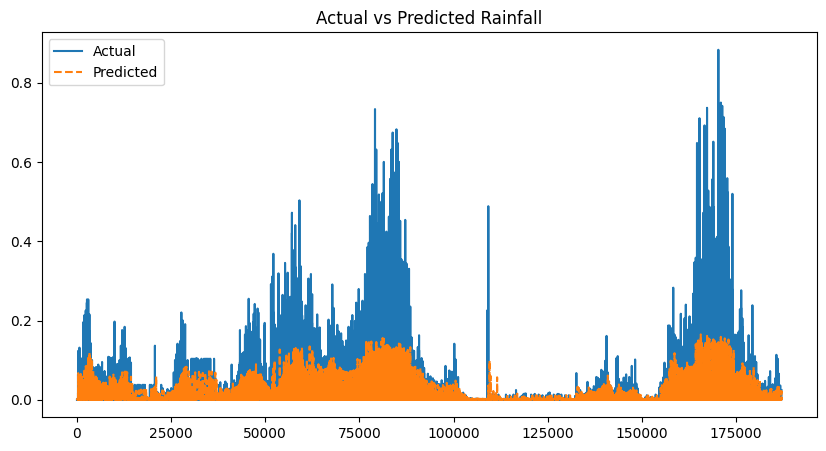

In [16]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)



plt.figure(figsize=(10, 5))
plt.plot(np.array(y_test), label="Actual")
plt.plot(np.array(y_pred), label="Predicted", linestyle="dashed")
plt.legend()
plt.title("Actual vs Predicted Rainfall")
plt.show()


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from datetime import datetime

dates = df['Datetime'].values  
assert len(dates) >= len(X_data), "Dates and X_data length mismatch"
dates = dates[-len(X_data):]  # Take the last len(X_data) dates to match

# Identify test set indices
split_index = int(len(X_data) * 0.8)
test_dates = dates[split_index:]


/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


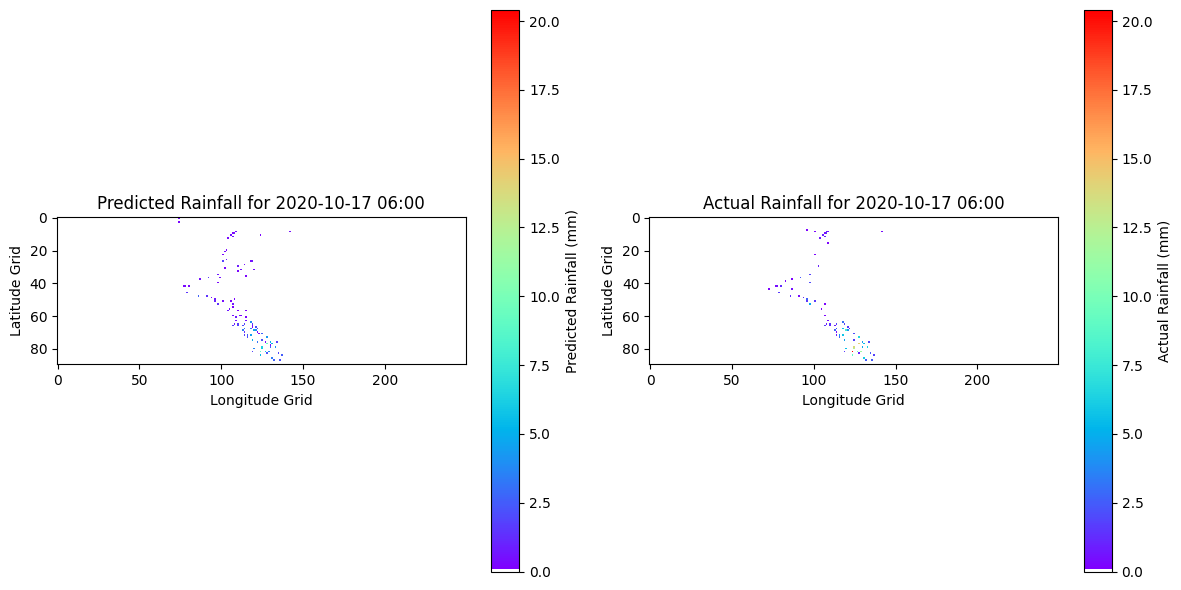

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error, mean_absolute_error
import uuid

def predict_rainfall(year, month, day, hour, full_data, X_data, y_data, scaler1, scaler2, X_train, X_test, y_train, y_test, model):
    
    
    # Reconstruct datetime for full_data
    full_data['Datetime'] = pd.to_datetime(full_data[['year', 'month', 'day', 'hour']].assign(minute=0, second=0))
    
    # Find indices in full_data corresponding to X_test
    test_size = len(X_test)
    total_size = len(X_data)
    test_indices = np.arange(total_size - test_size, total_size)
    
    # Create a DataFrame for test data with datetime
    test_data = full_data.iloc[test_indices].copy()
    
    # Filter for the specific day and hour
    mask = (test_data['year'] == year) & \
           (test_data['month'] == month) & \
           (test_data['day'] == day) & \
           (test_data['hour'] == hour)
    
    if not mask.any():
        raise ValueError(f"No data found for {year}-{month:02d}-{day:02d} {hour:02d}:00")
    
    # Get the corresponding X_test indices
    test_subset_indices = test_data[mask].index - (total_size - test_size)
    X_test_subset = X_test[test_subset_indices]
    y_test_subset = y_test[test_subset_indices]
    pred_positions = test_data[mask][['Row', 'Col']].values
    
    # Predict rainfall
    y_pred_scaled = model.predict(X_test_subset)
    
    # Inverse transform predictions and ground truth
    y_pred = scaler2.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = scaler2.inverse_transform(y_test_subset.reshape(-1, 1)).ravel()
    
    # Initialize grids
    rainfall_grid = np.full((90, 250), np.nan)
    actual_rainfall_grid = np.full((90, 250), np.nan)
    
    # Map predictions and ground truth to grids
    for (row, col), rain in zip(pred_positions, y_pred):
        rainfall_grid[int(row), int(col)] = rain
    
    for (row, col), rain in zip(pred_positions, y_true):
        actual_rainfall_grid[int(row), int(col)] = rain
    
    # Apply threshold to set small values to NaN
    rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
    
    # Determine value range for consistent scaling
    min_val = np.nanmin([rainfall_grid, actual_rainfall_grid])
    max_val = np.nanmax([rainfall_grid, actual_rainfall_grid])
    
    # Custom colormap (white for NaN, rainbow for values)
    cmap = plt.cm.rainbow
    colors = [(1, 1, 1)] + [cmap(i) for i in np.linspace(0, 1, 256)]
    new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_rainbow", colors, N=256)
    
    # Create timestamp for plot title
    timestamp = f"{year}-{month:02d}-{day:02d} {hour:02d}:00"
    
    # Plot heatmaps
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Predicted Rainfall
    plt.subplot(1, 2, 1)
    plt.imshow(rainfall_grid, cmap=new_cmap, interpolation="nearest", vmin=min_val, vmax=max_val)
    plt.colorbar(label="Predicted Rainfall (mm)")
    plt.title(f"Predicted Rainfall for {timestamp}")
    plt.xlabel("Longitude Grid")
    plt.ylabel("Latitude Grid")
    
    # Plot 2: Actual Rainfall
    plt.subplot(1, 2, 2)
    plt.imshow(actual_rainfall_grid, cmap=new_cmap, interpolation="nearest", vmin=min_val, vmax=max_val)
    plt.colorbar(label="Actual Rainfall (mm)")
    plt.title(f"Actual Rainfall for {timestamp}")
    plt.xlabel("Longitude Grid")
    plt.ylabel("Latitude Grid")
    
    # Adjust layout and save plot
    plt.tight_layout()
    plt.show()


predict_rainfall(2020, 10, 17, 6, full_data, X_data, y_data, scaler1, scaler2, X_train, X_test, y_train, y_test, model)

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


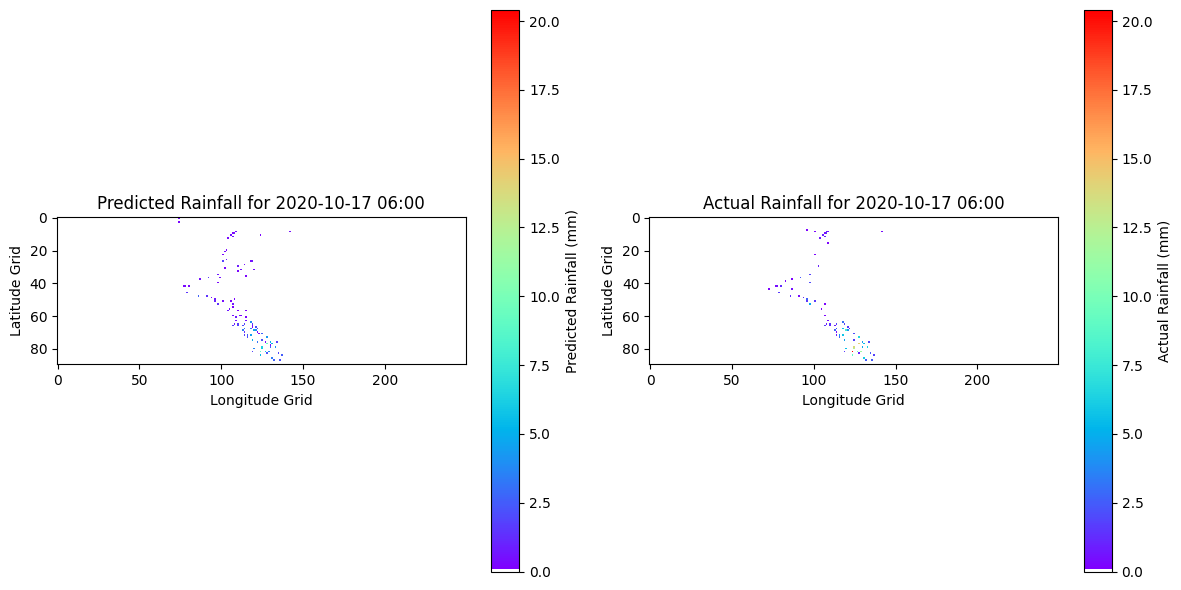

In [19]:
predict_rainfall(2020, 10, 17, 6, full_data, X_data, y_data, scaler1, scaler2, X_train, X_test, y_train, y_test, model)

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


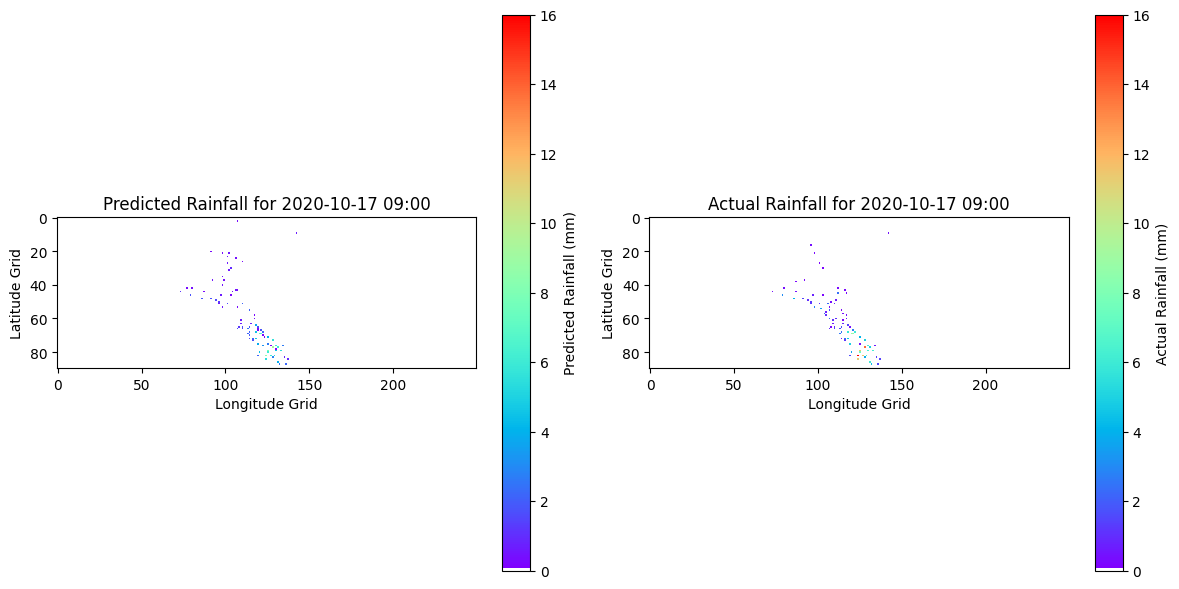

In [20]:
predict_rainfall(2020, 10, 17, 9, full_data, X_data, y_data, scaler1, scaler2, X_train, X_test, y_train, y_test, model)

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


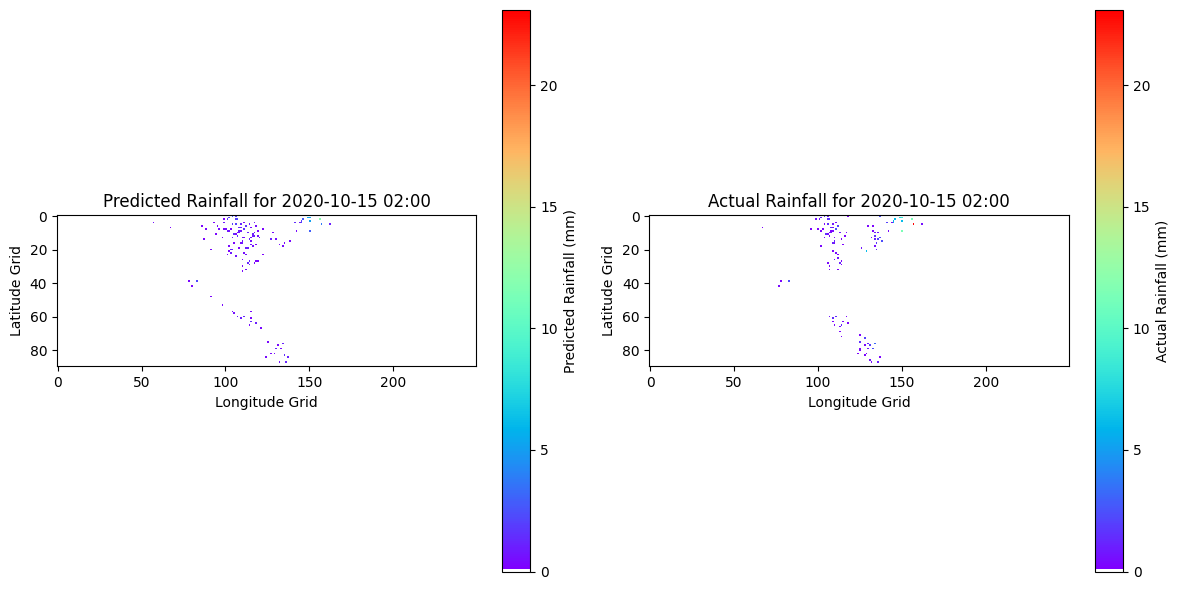

In [21]:
predict_rainfall(2020, 10, 15, 2, full_data, X_data, y_data, scaler1, scaler2, X_train, X_test, y_train, y_test, model)

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


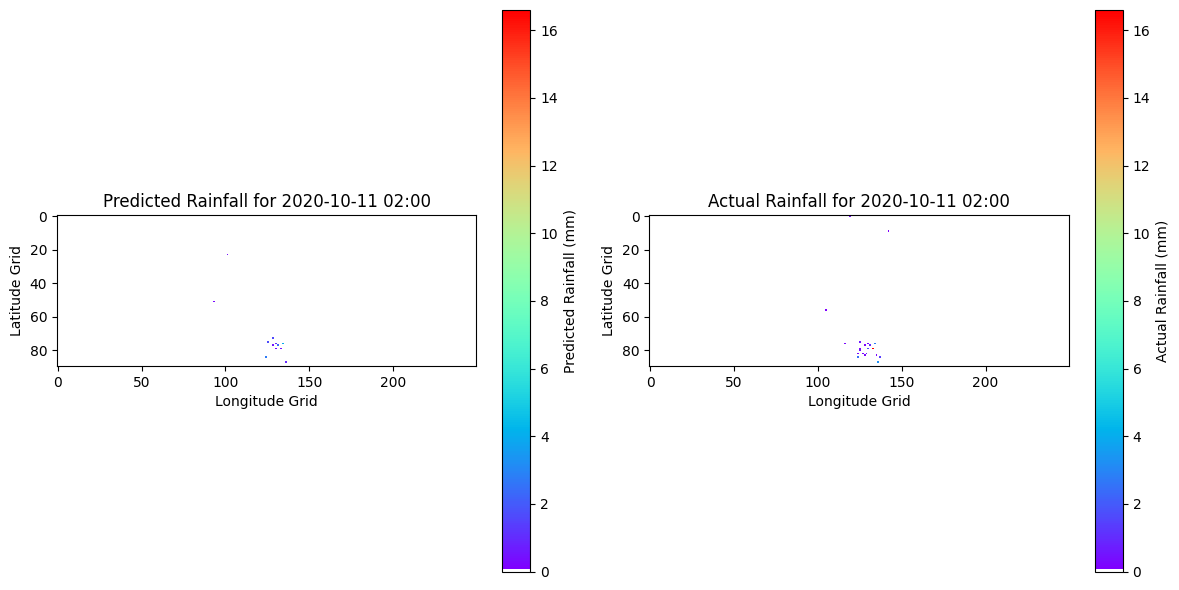

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


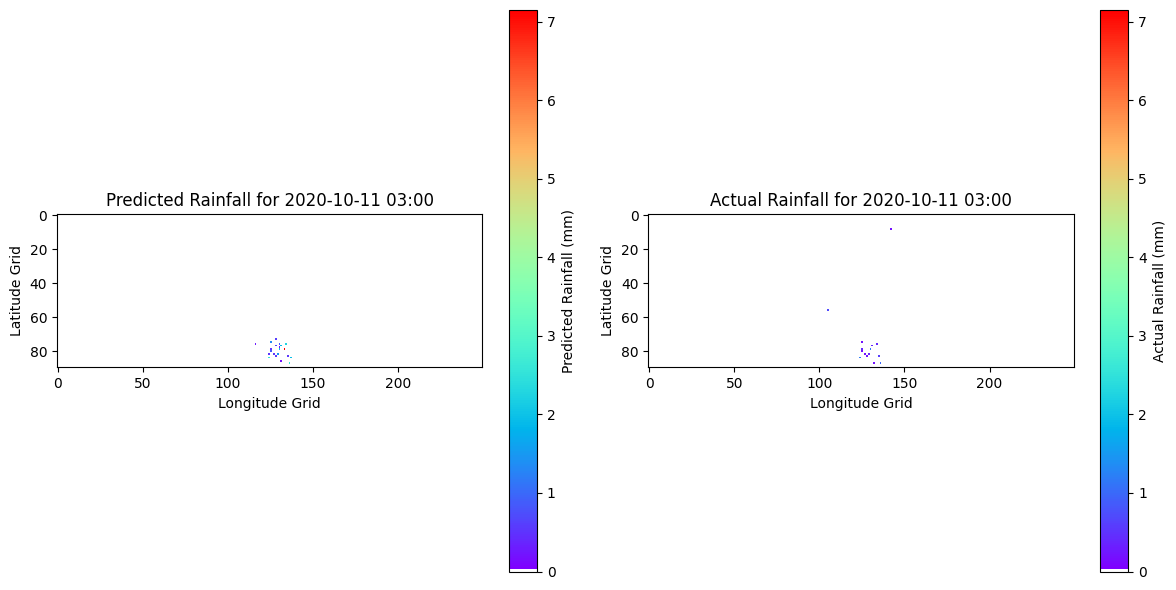

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


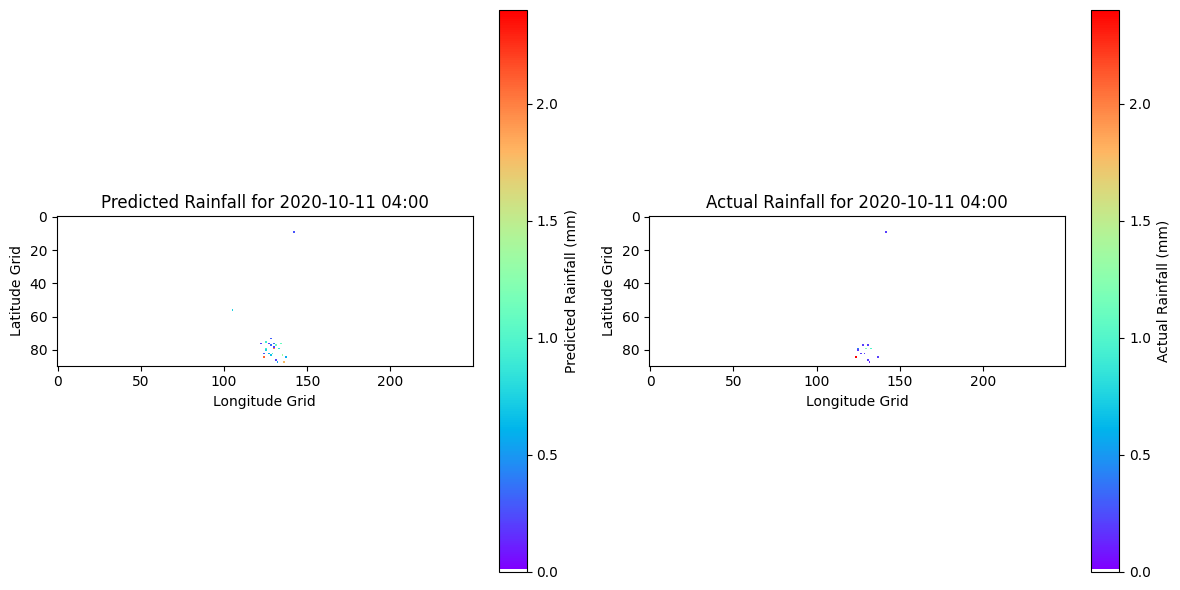

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


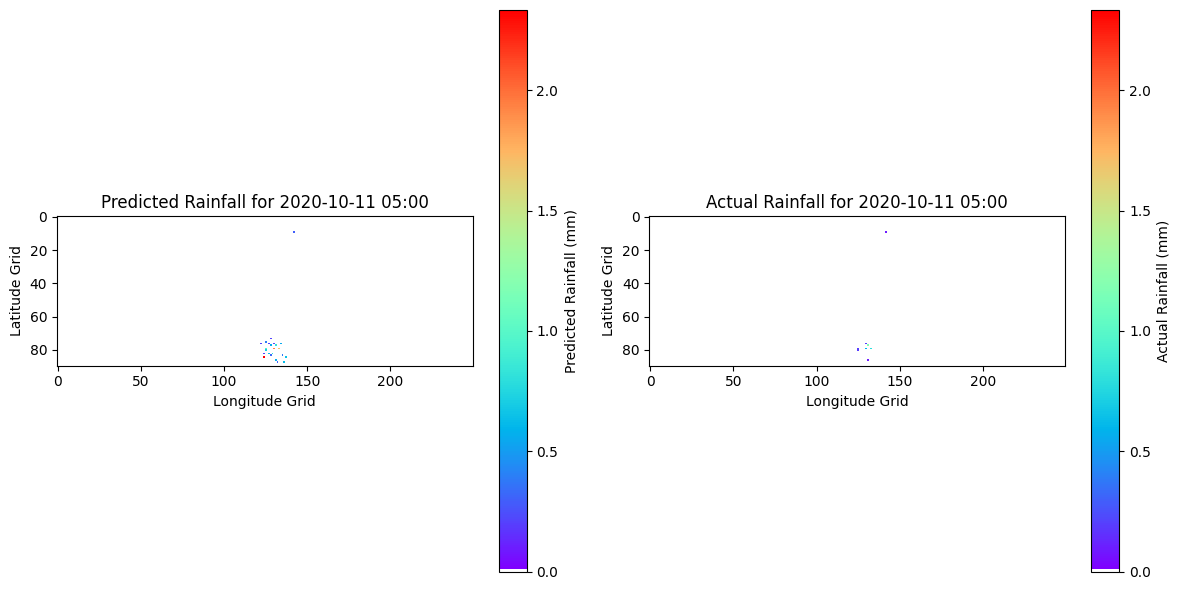

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


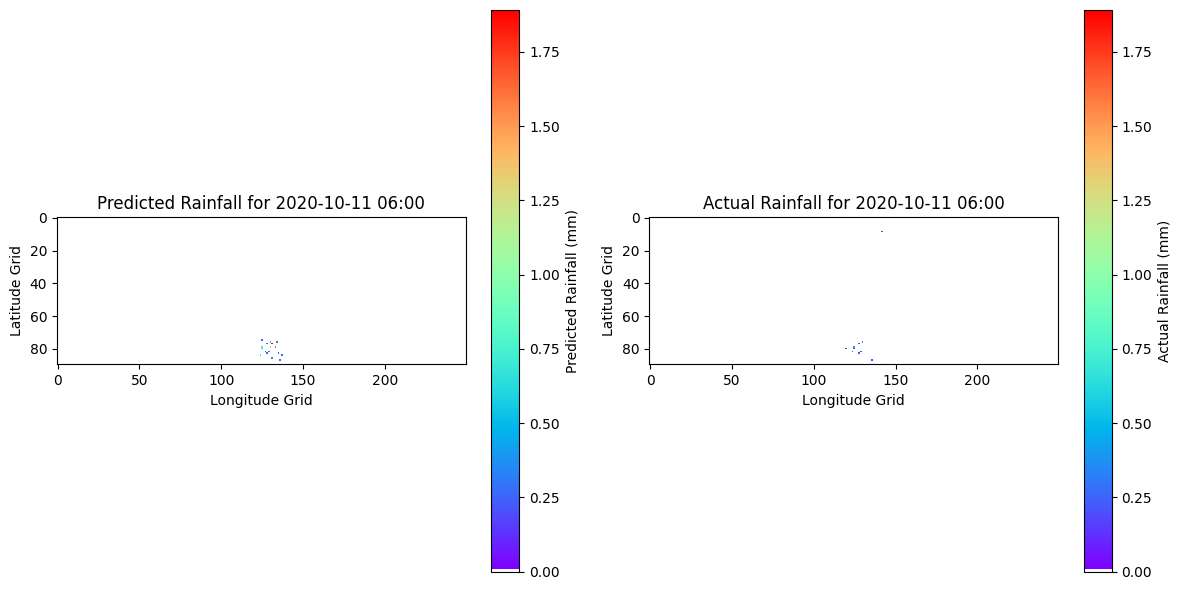

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


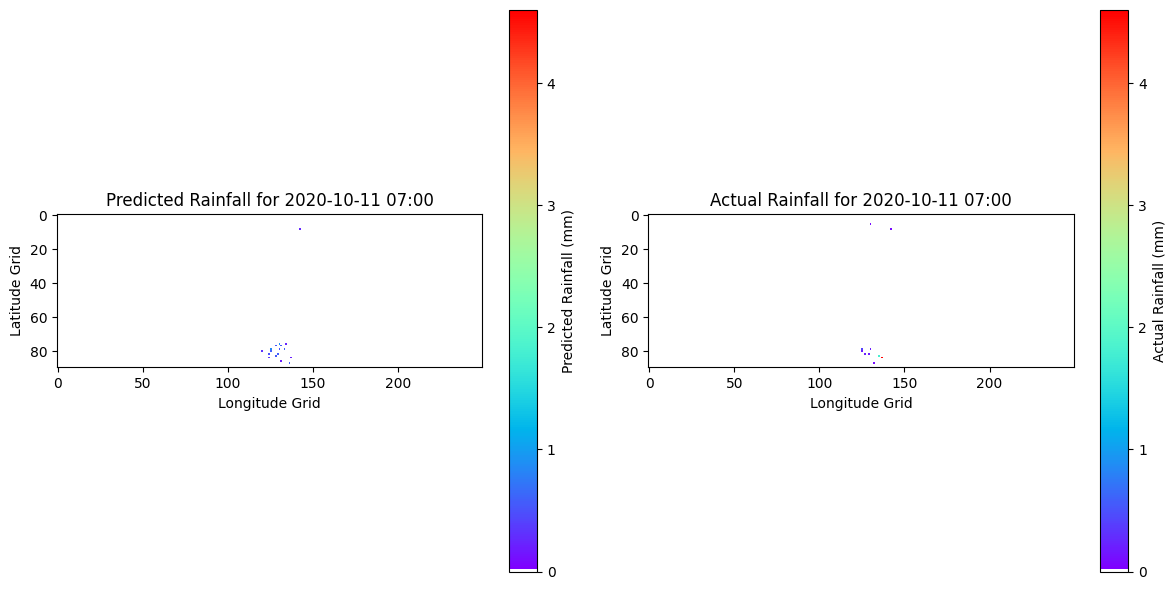

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


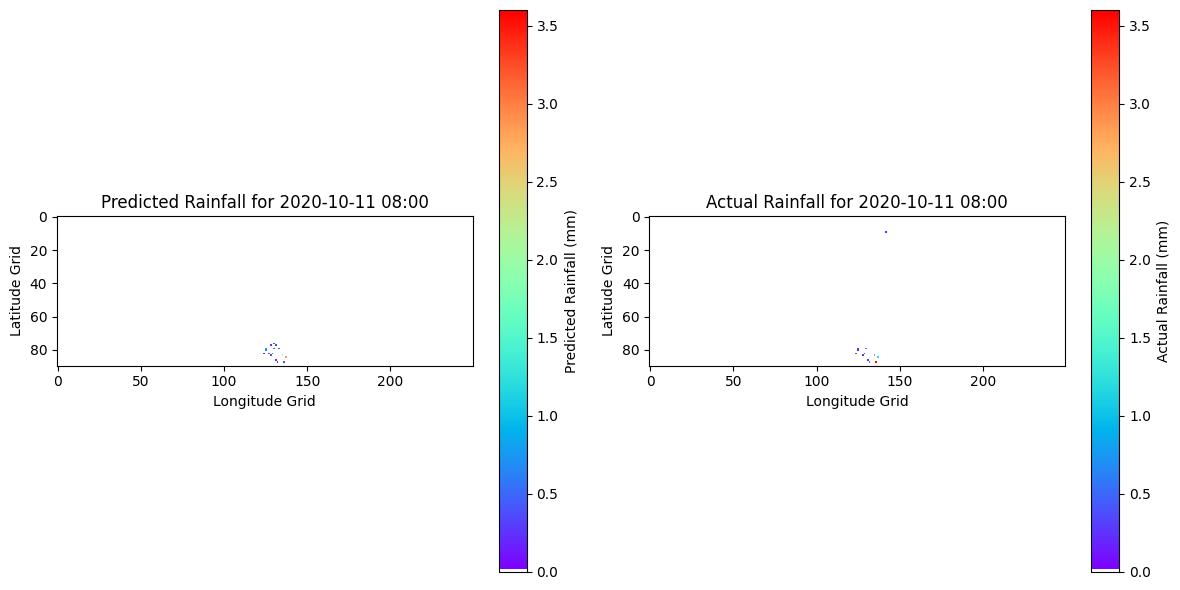

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


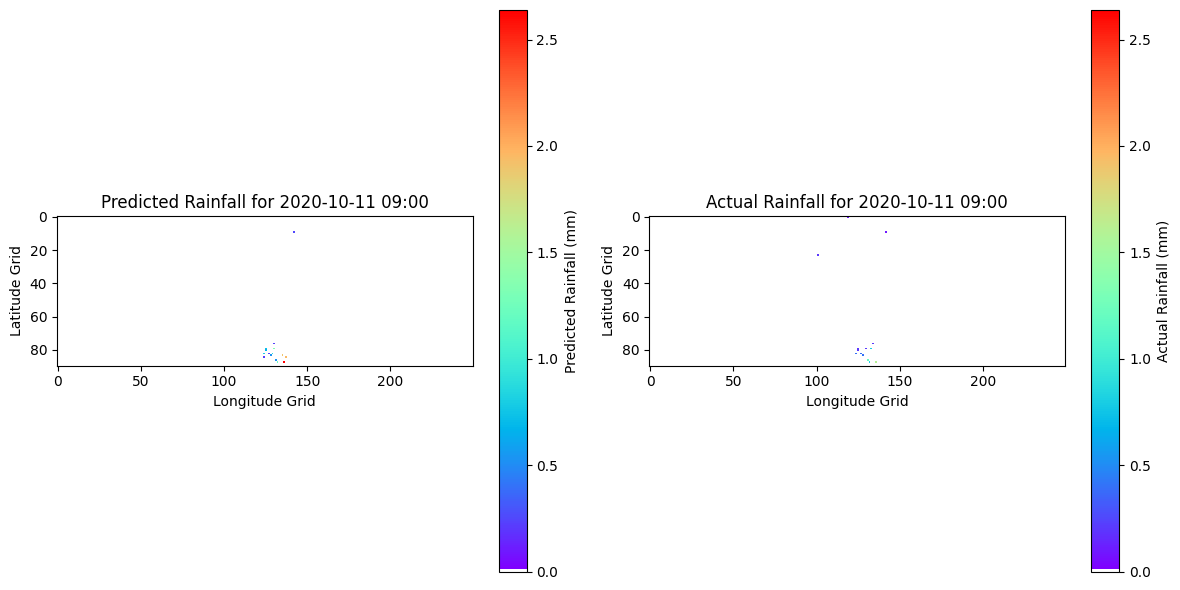

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


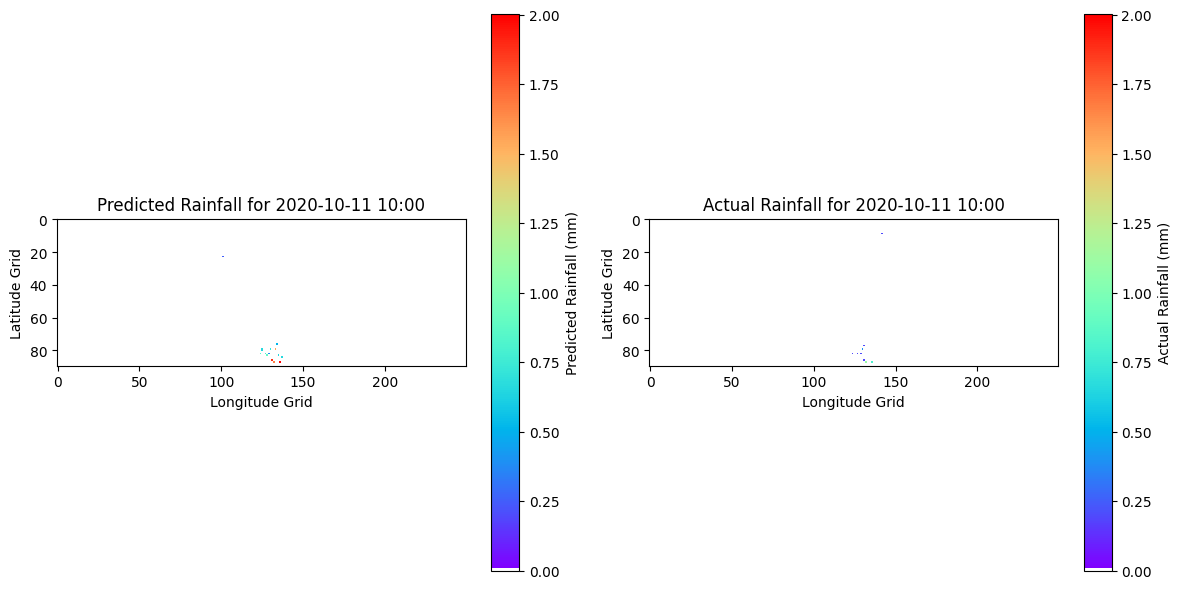

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


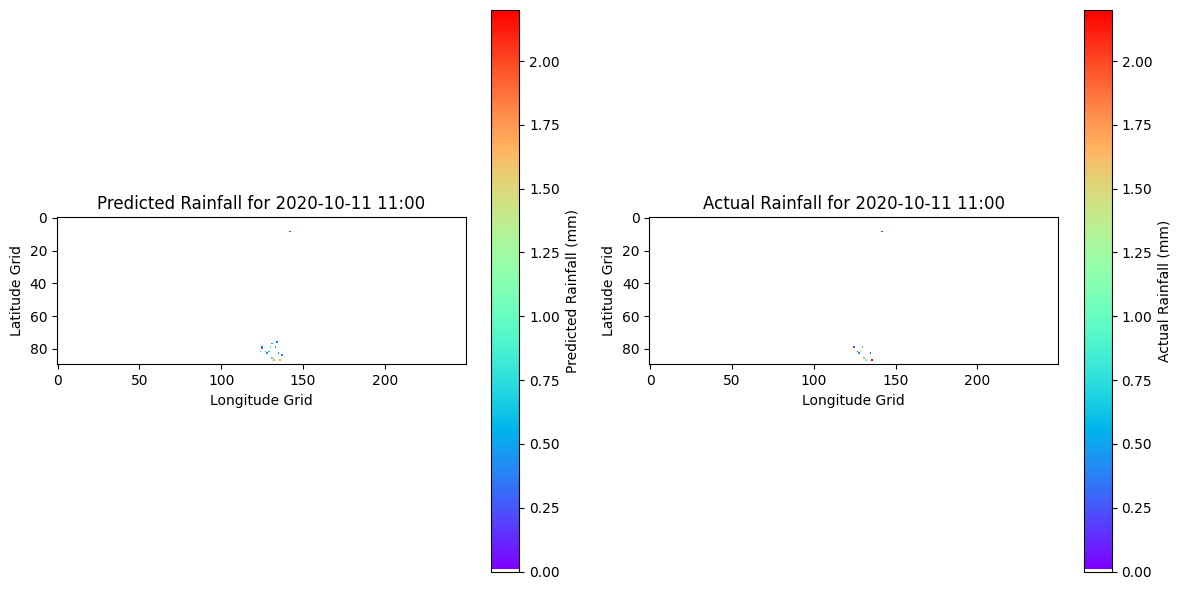

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


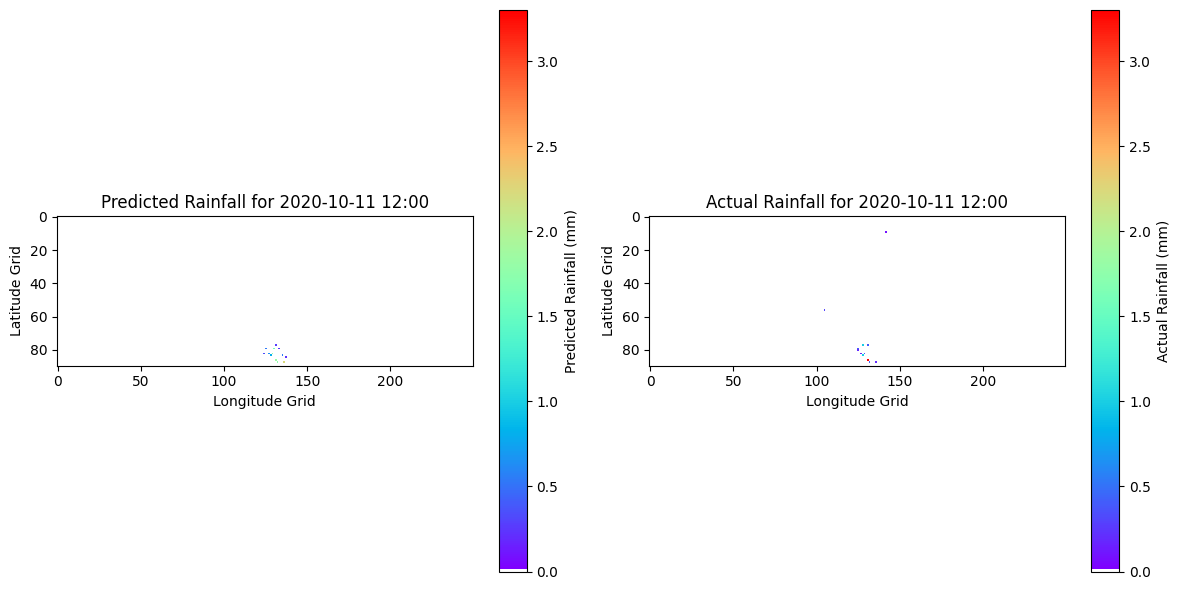

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


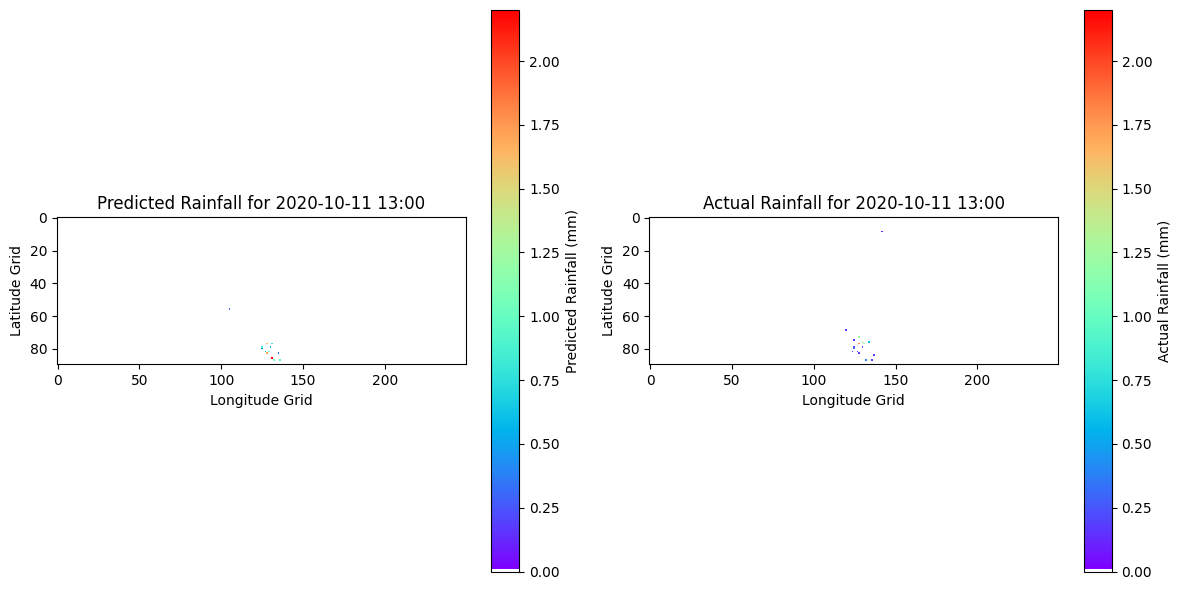

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


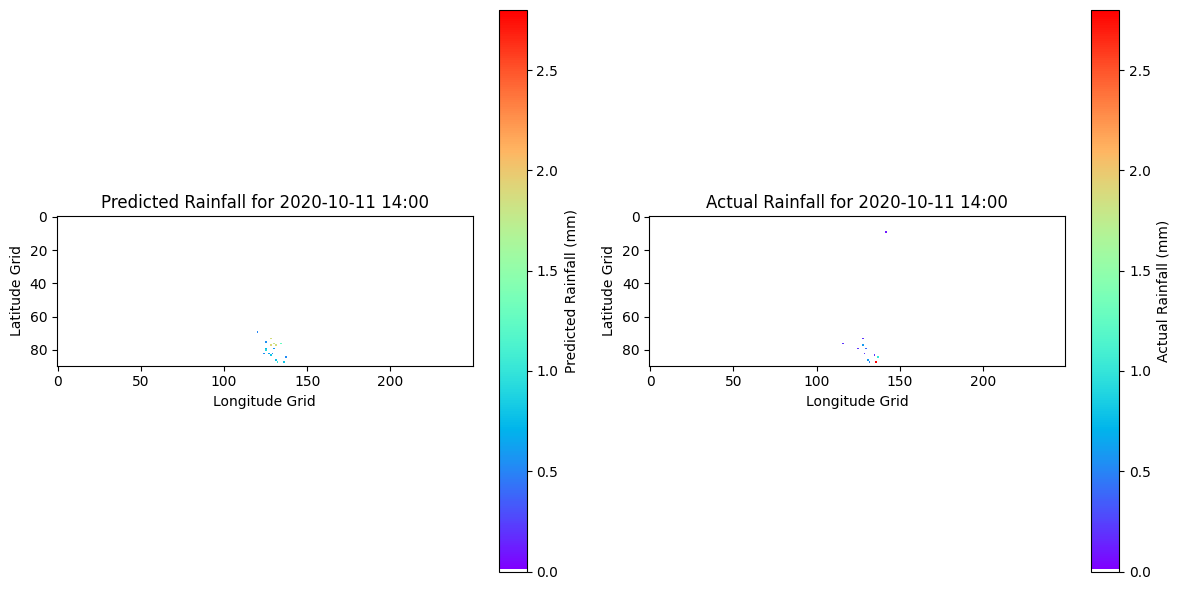

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


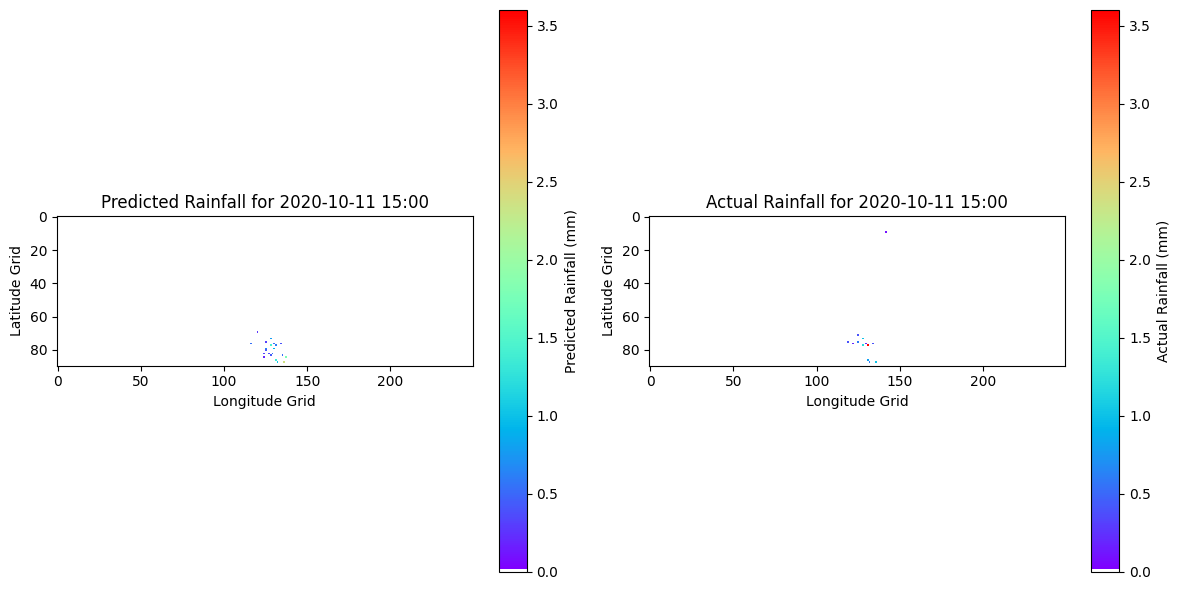

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


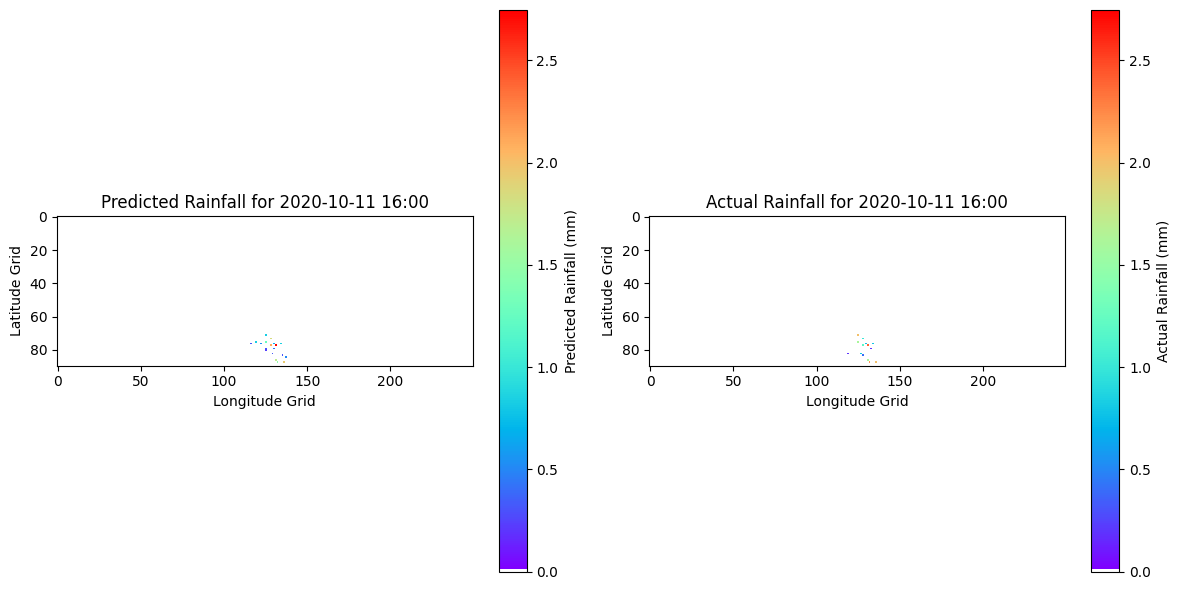

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


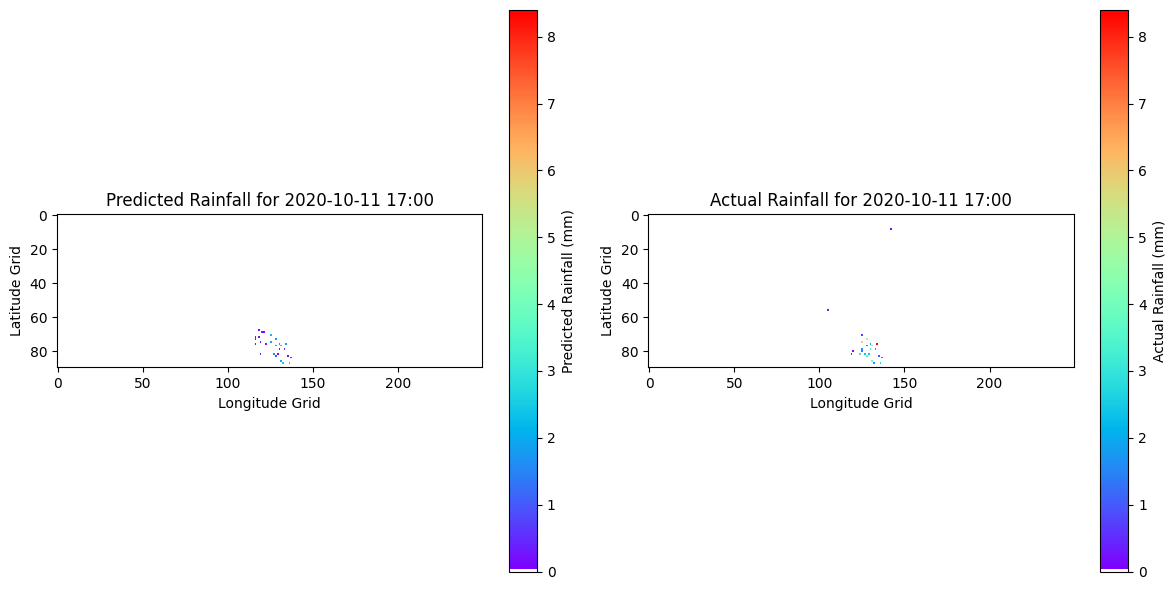

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


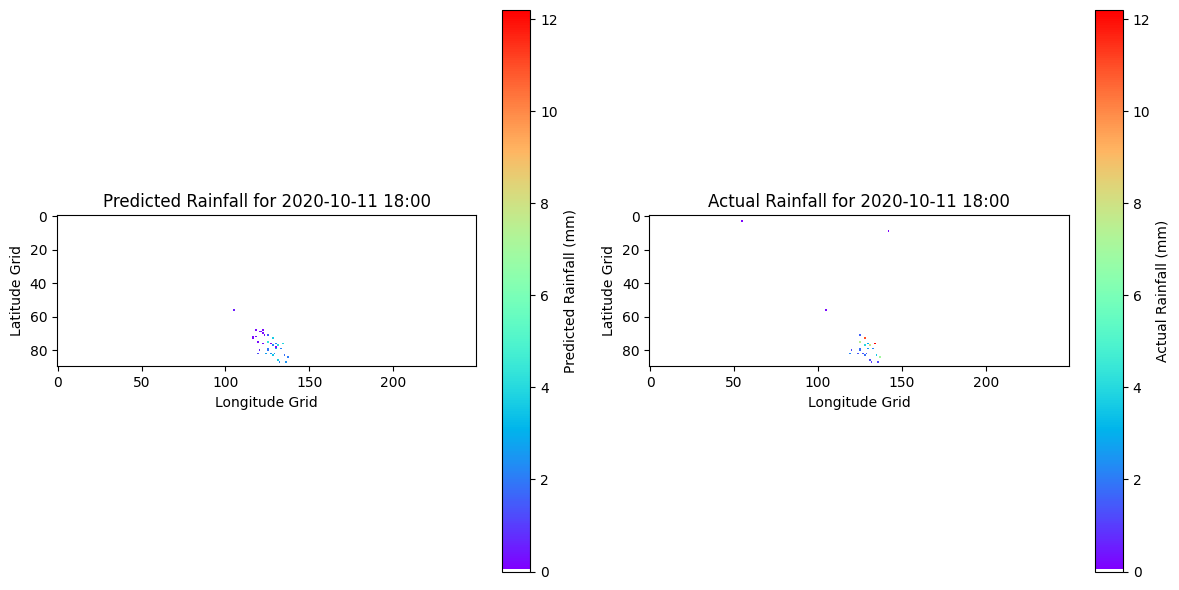

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


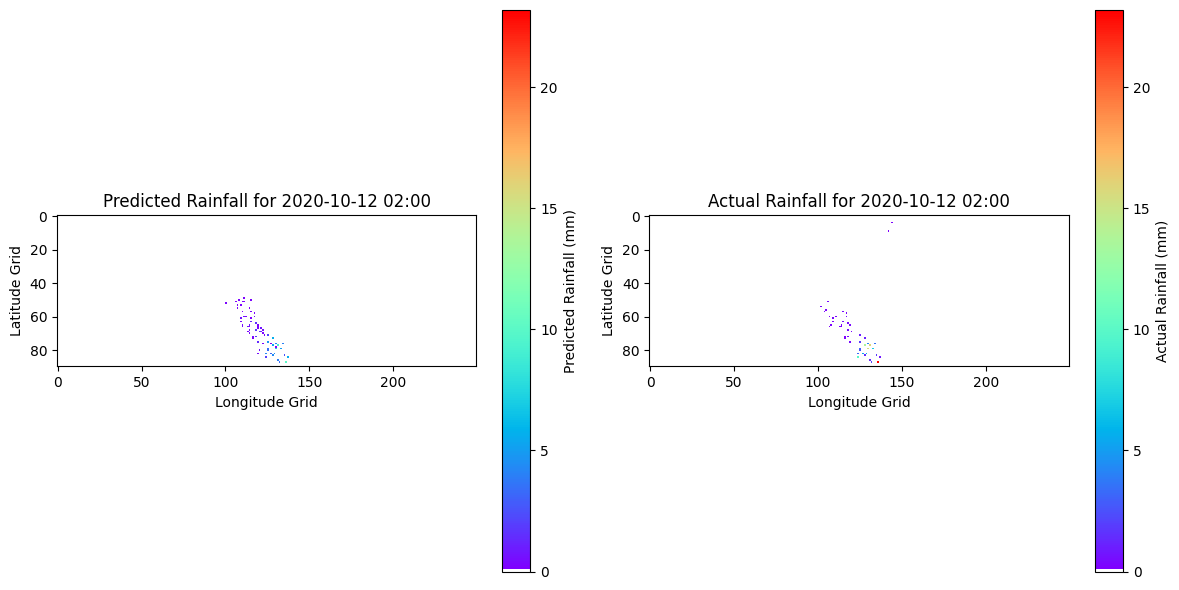

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


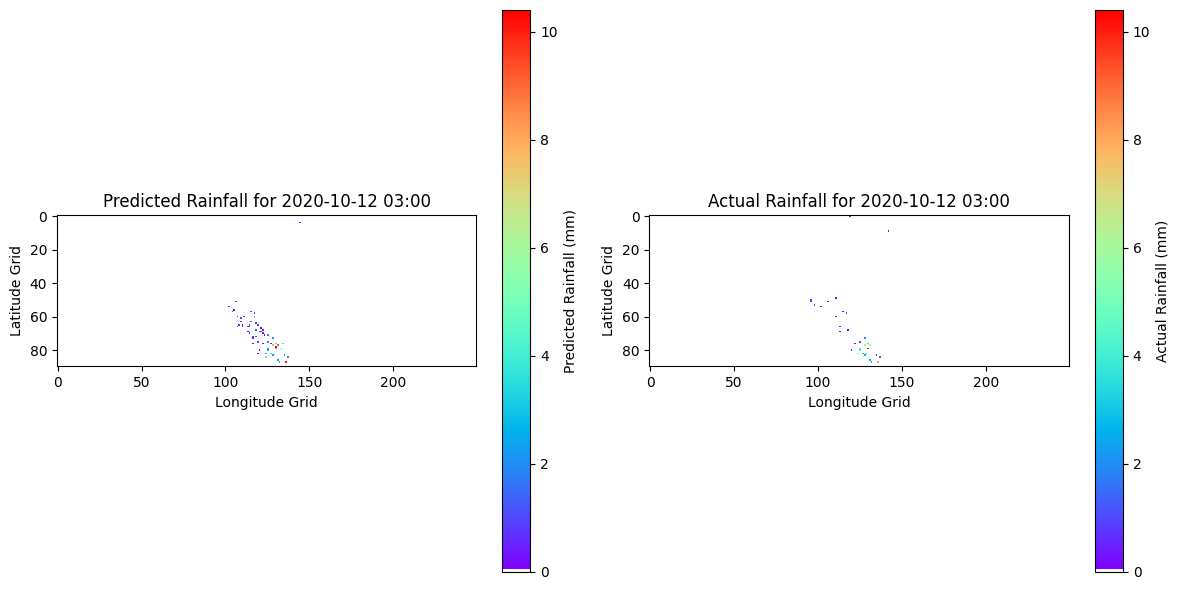

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


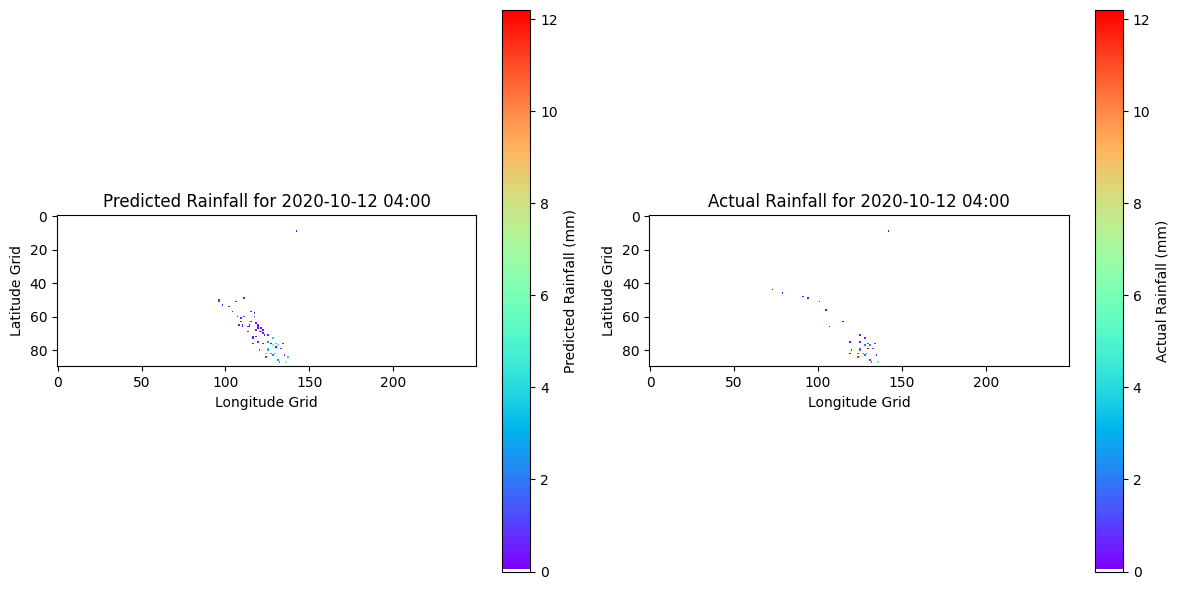

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


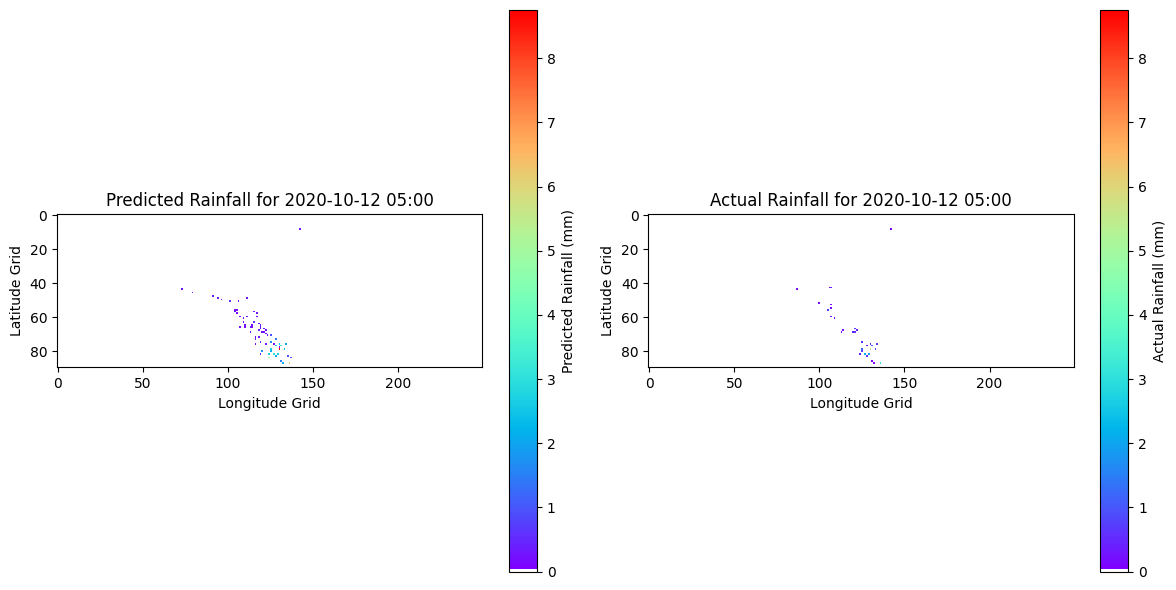

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


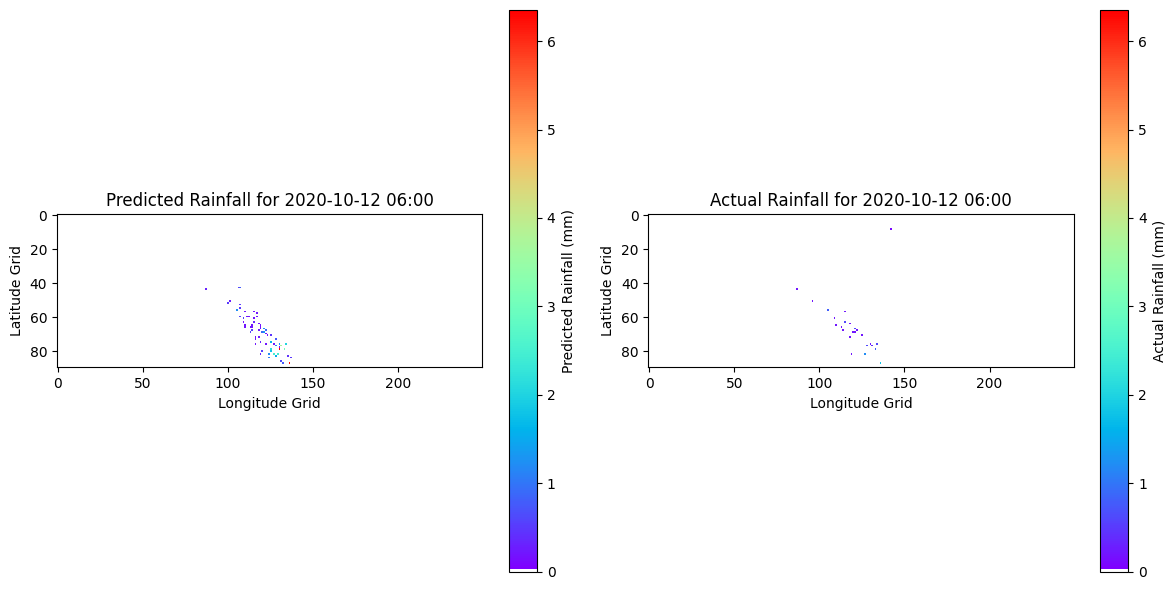

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


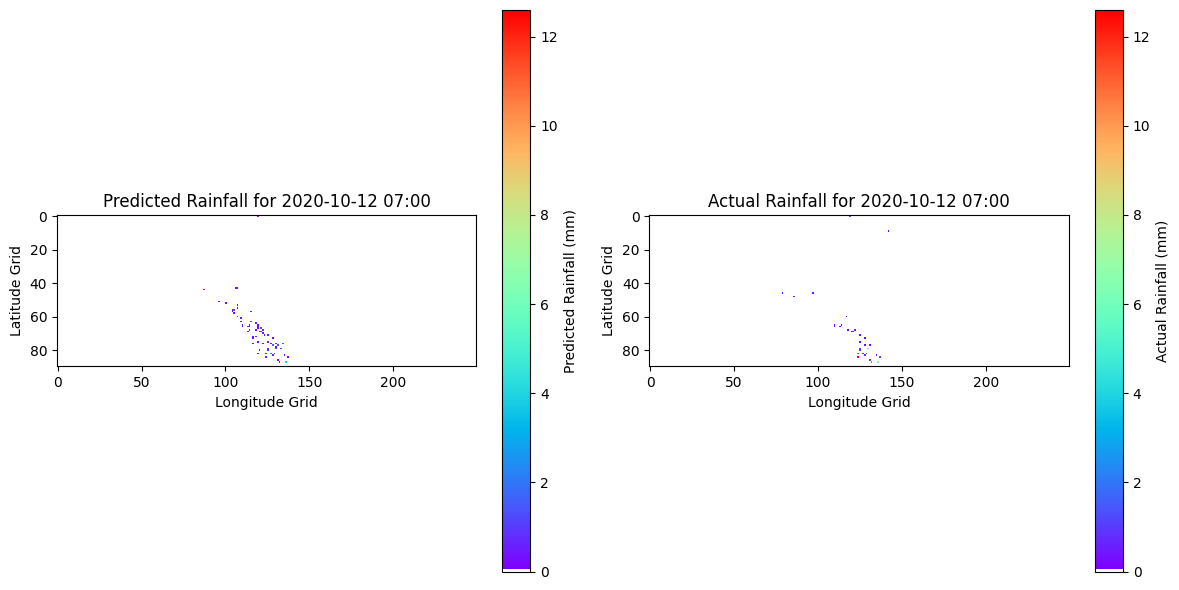

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


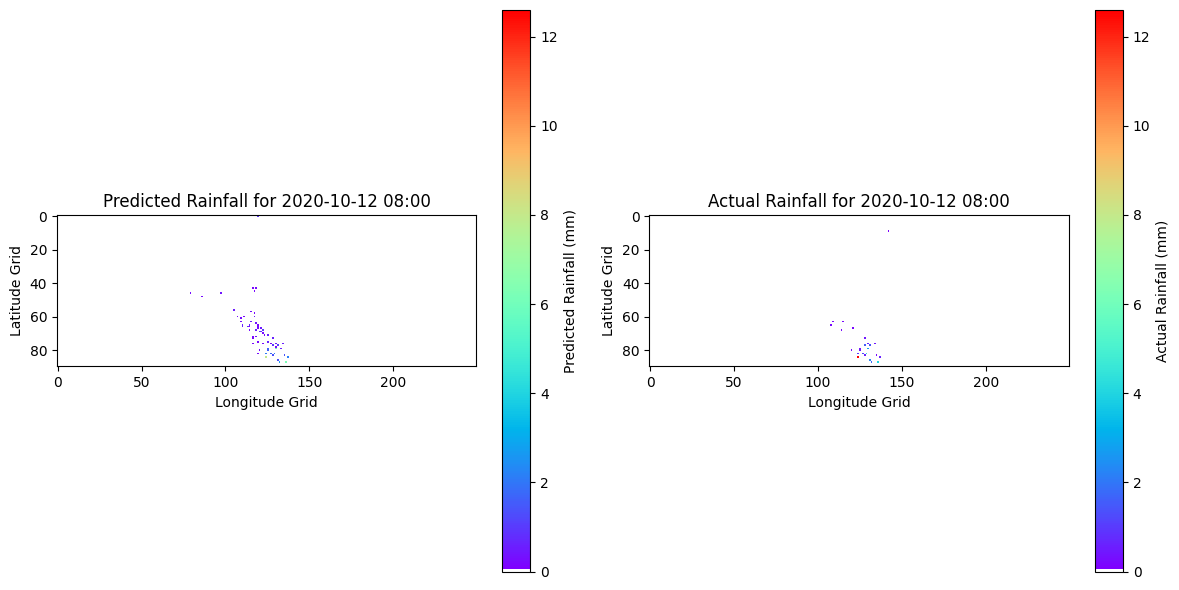

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


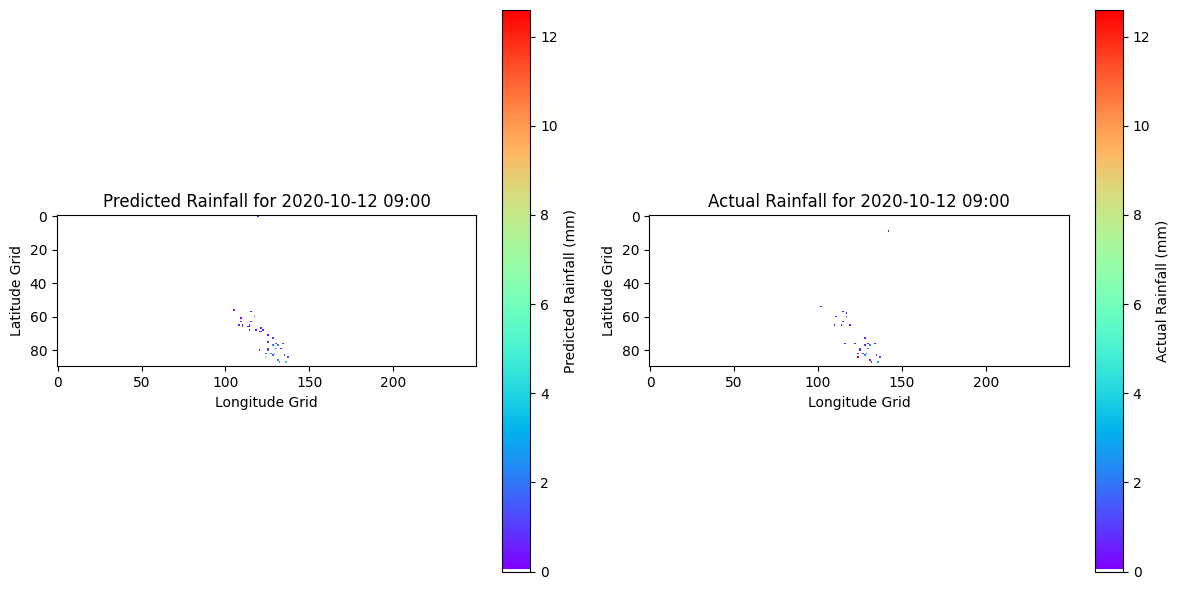

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


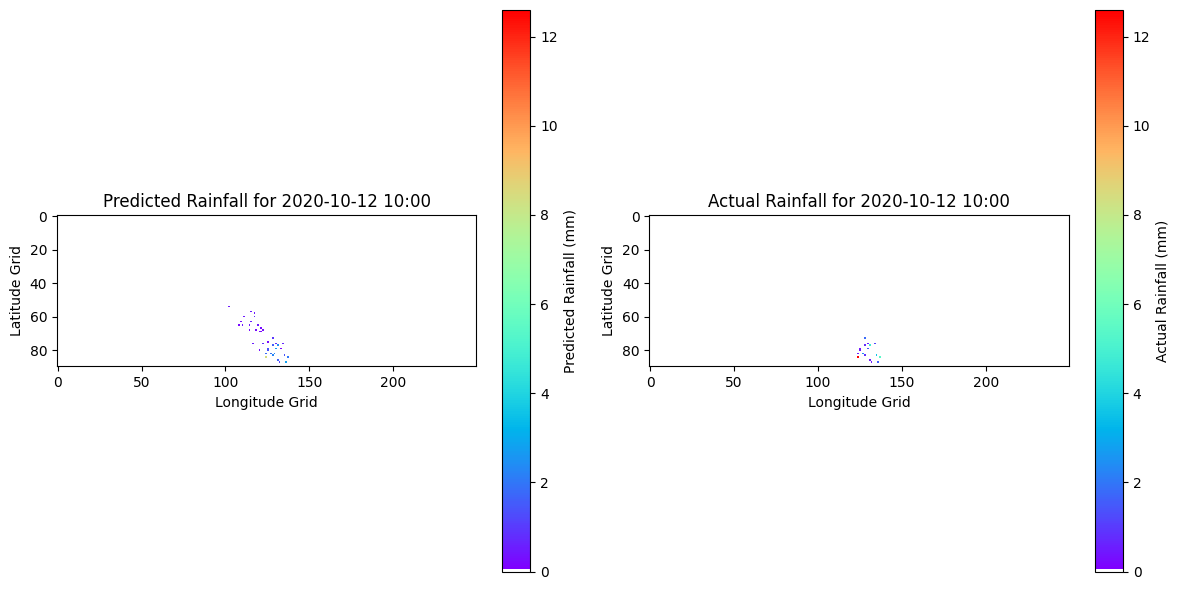

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


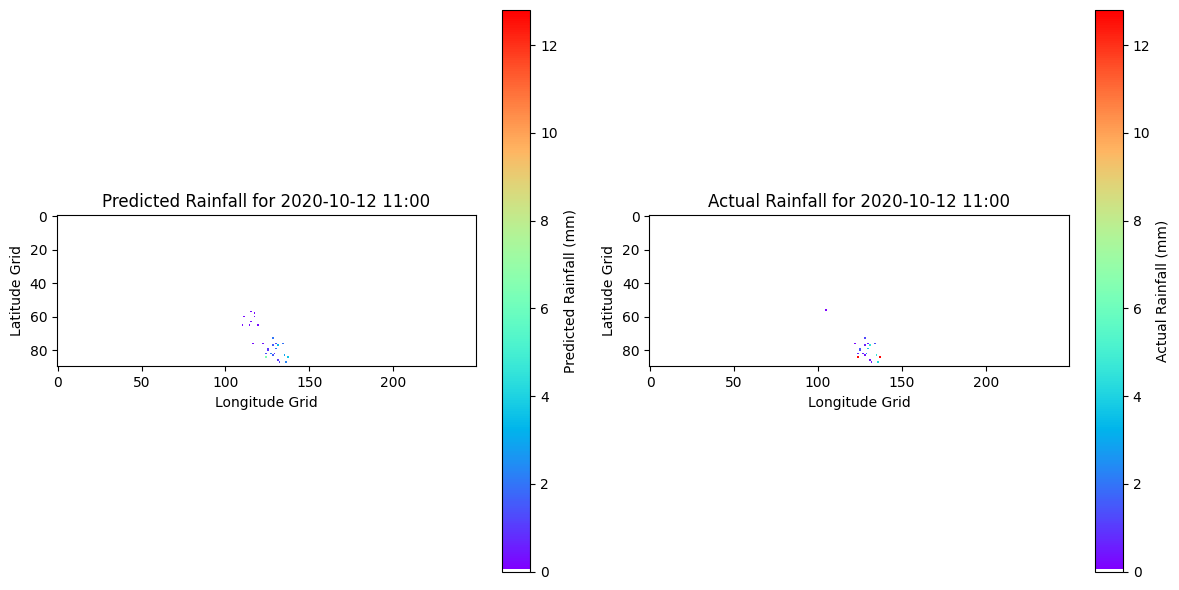

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


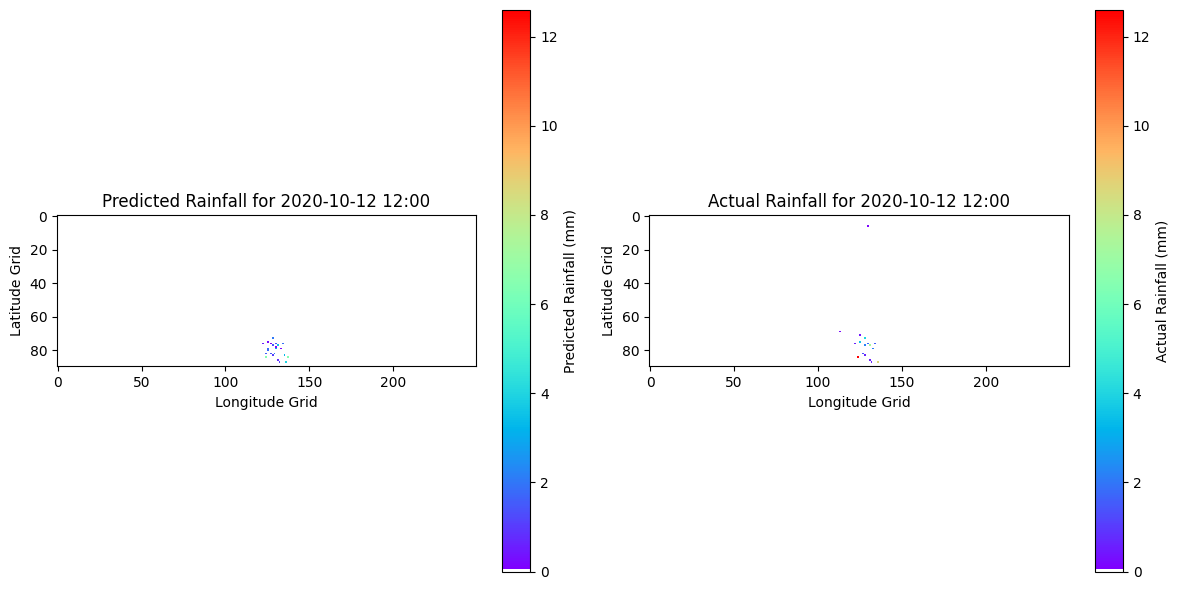

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


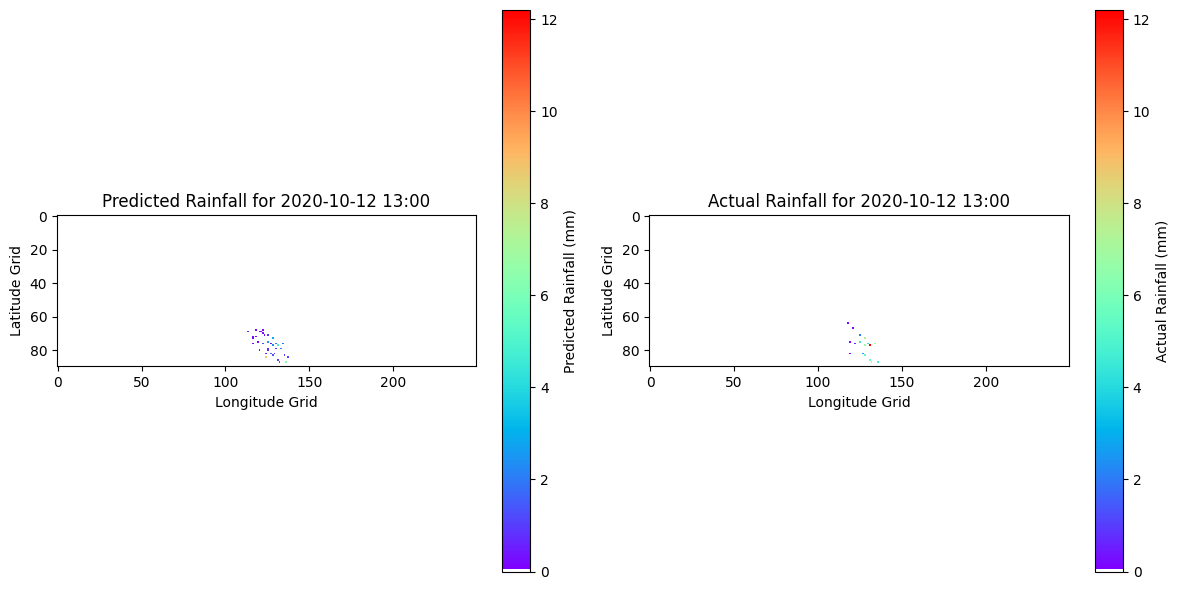

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


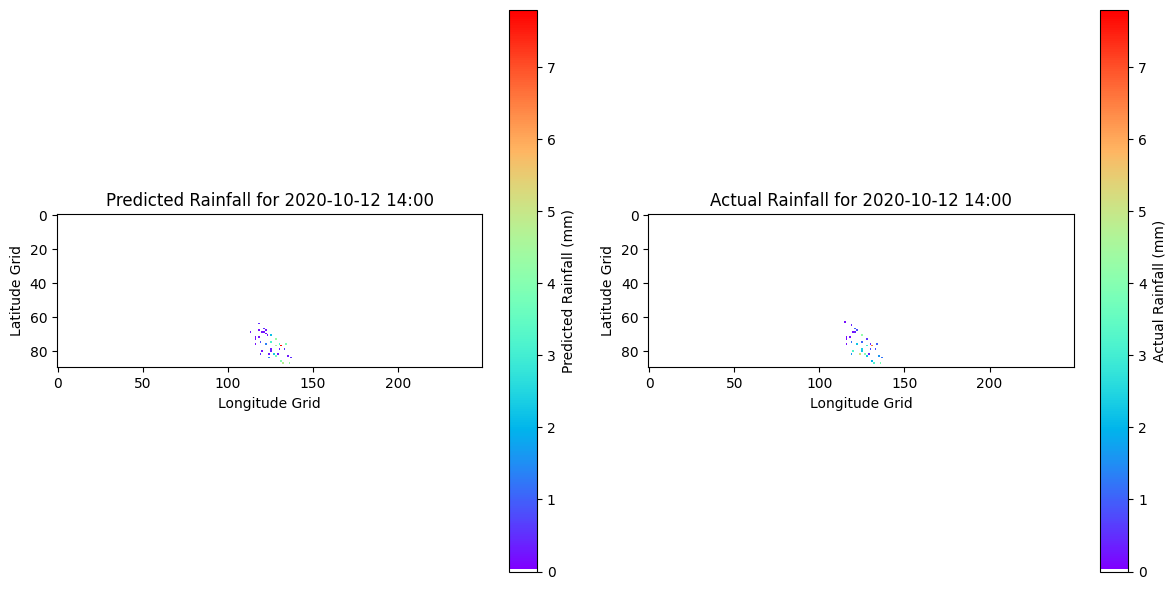

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


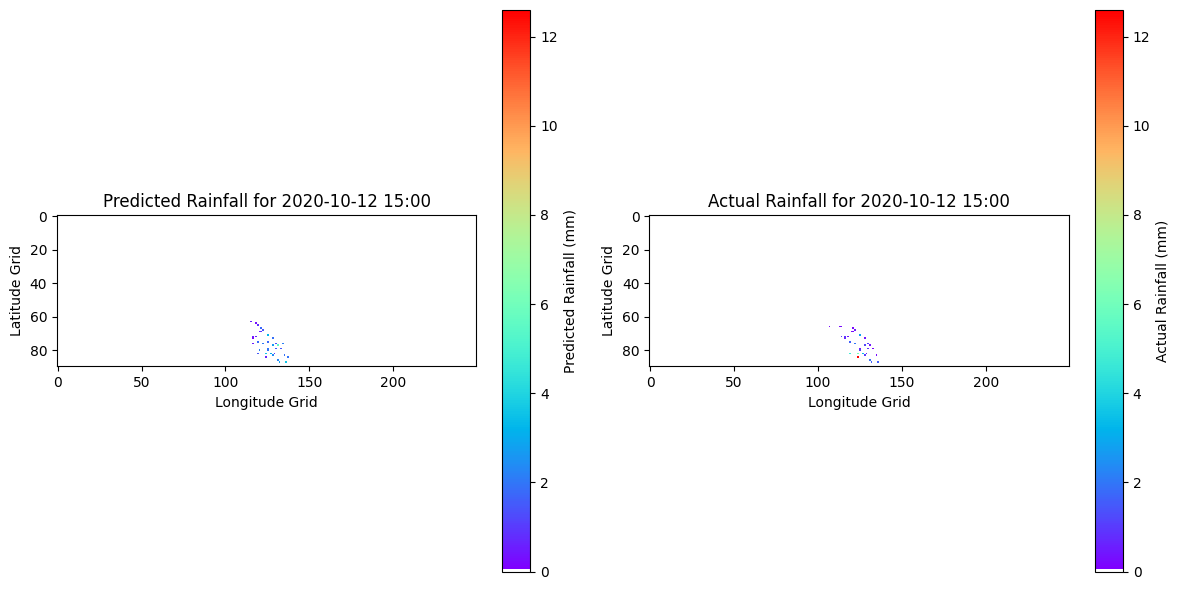

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


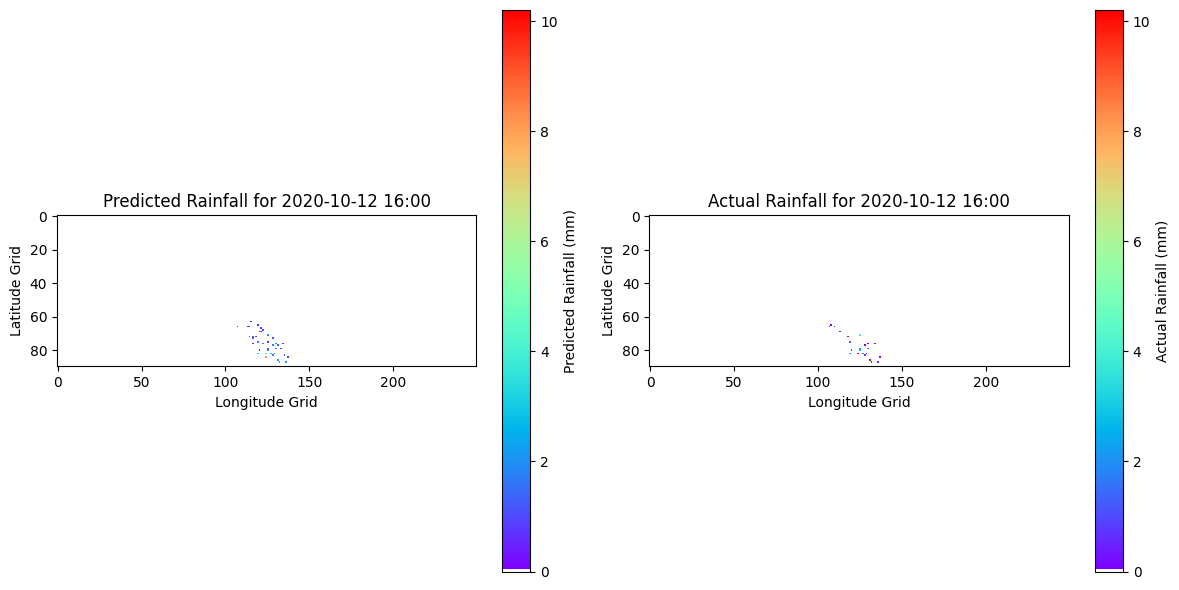

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


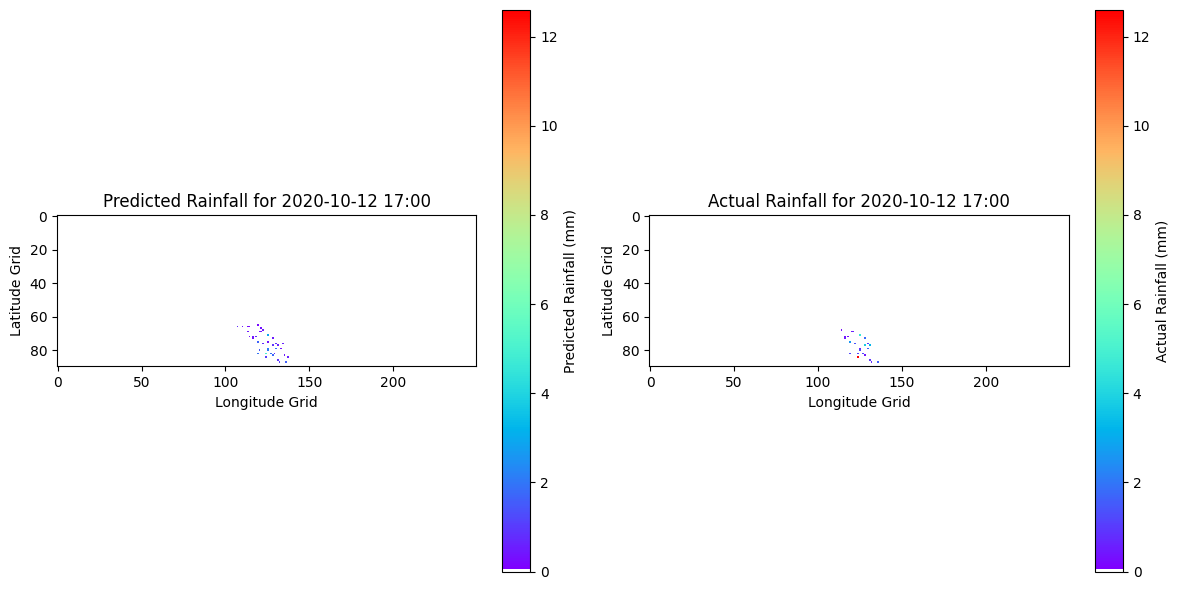

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


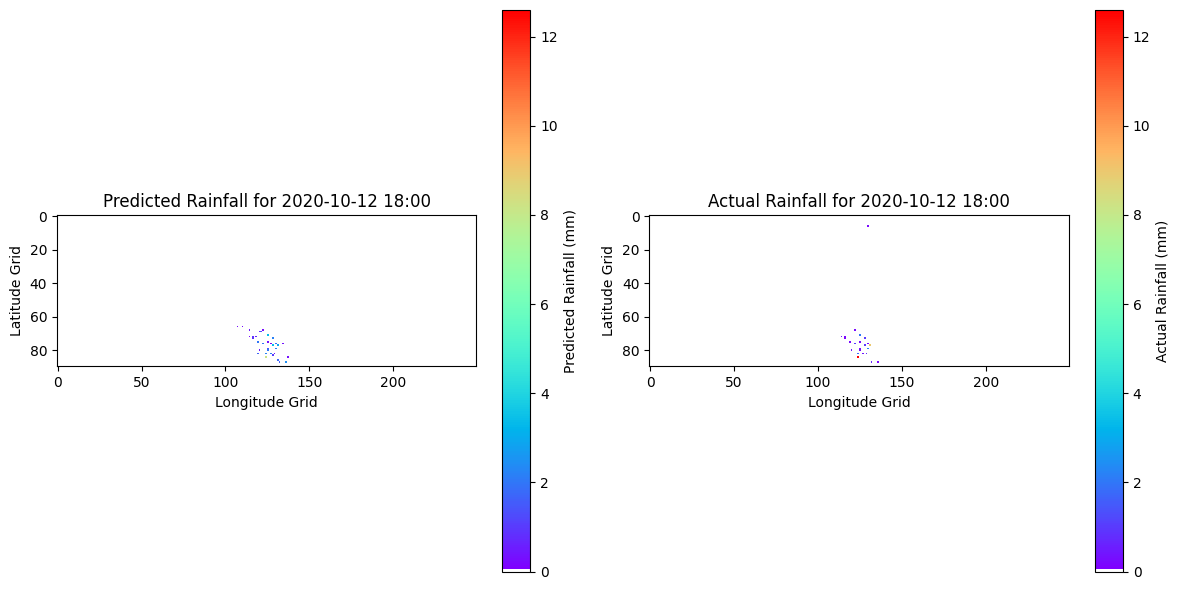

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


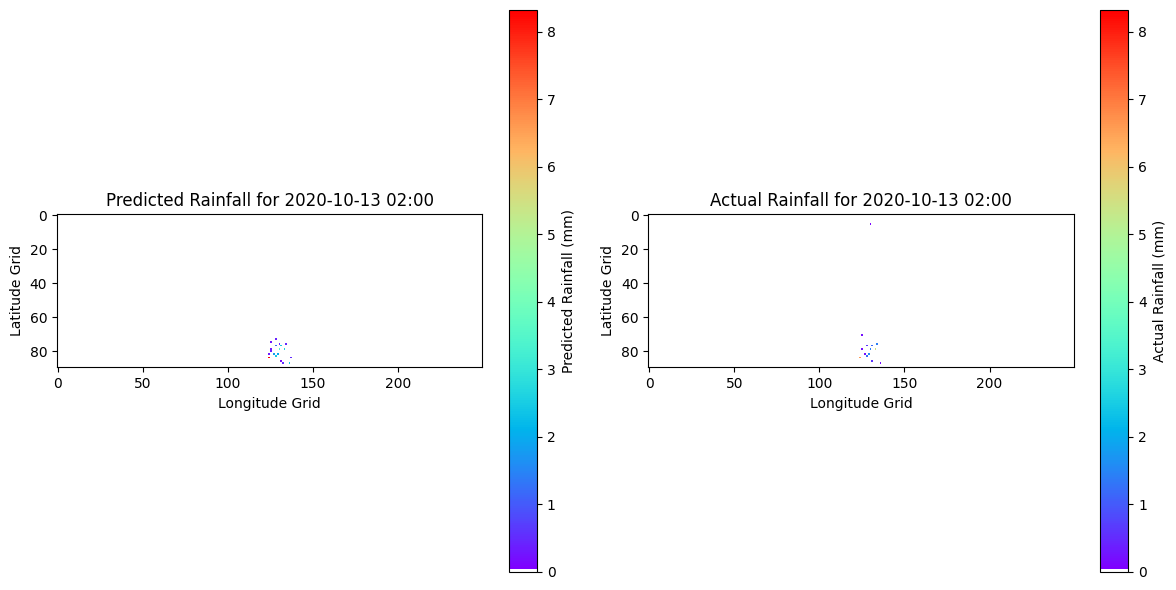

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


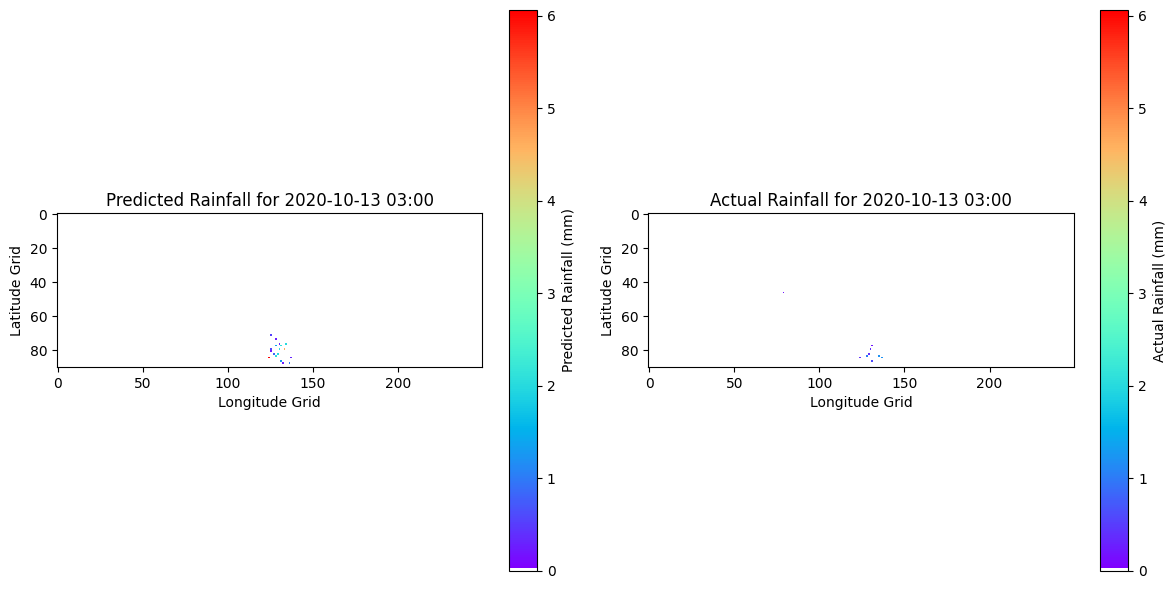

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


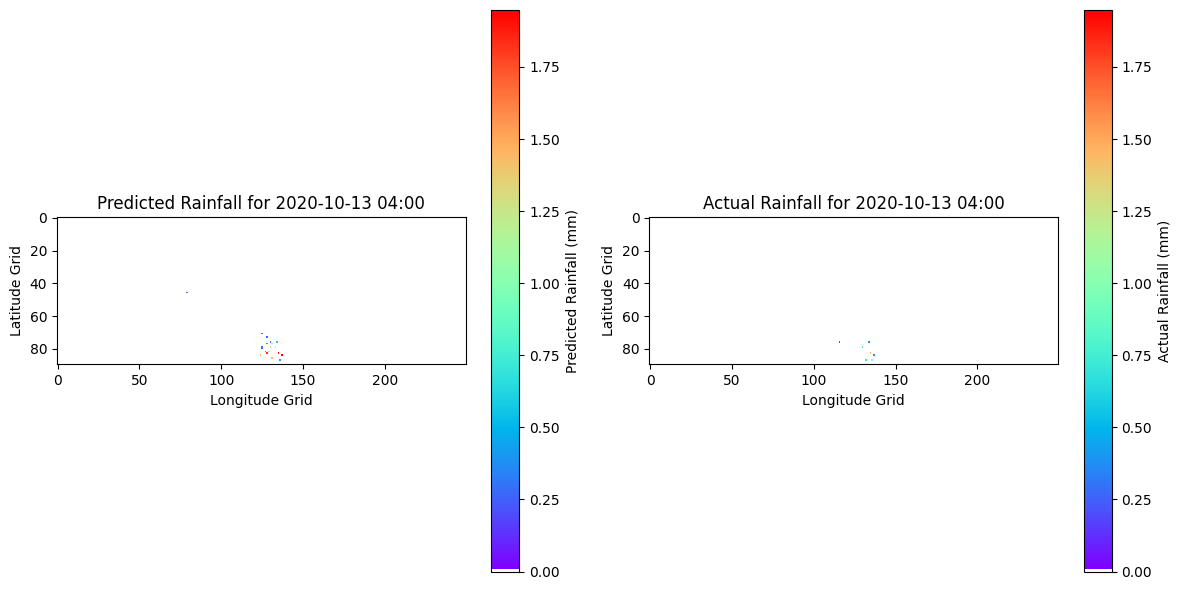

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


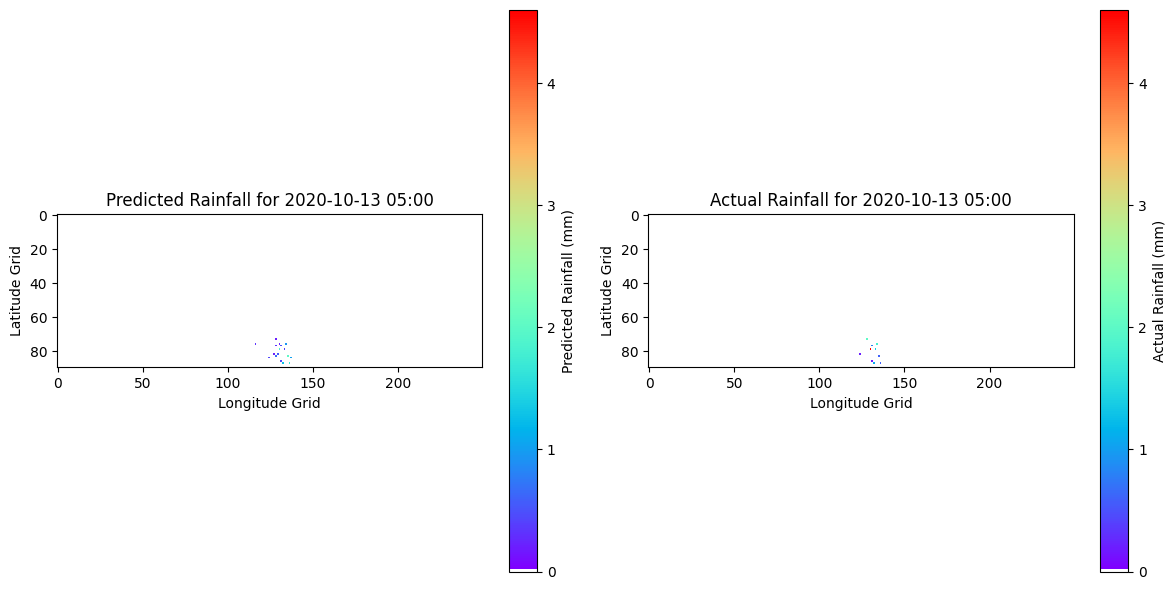

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


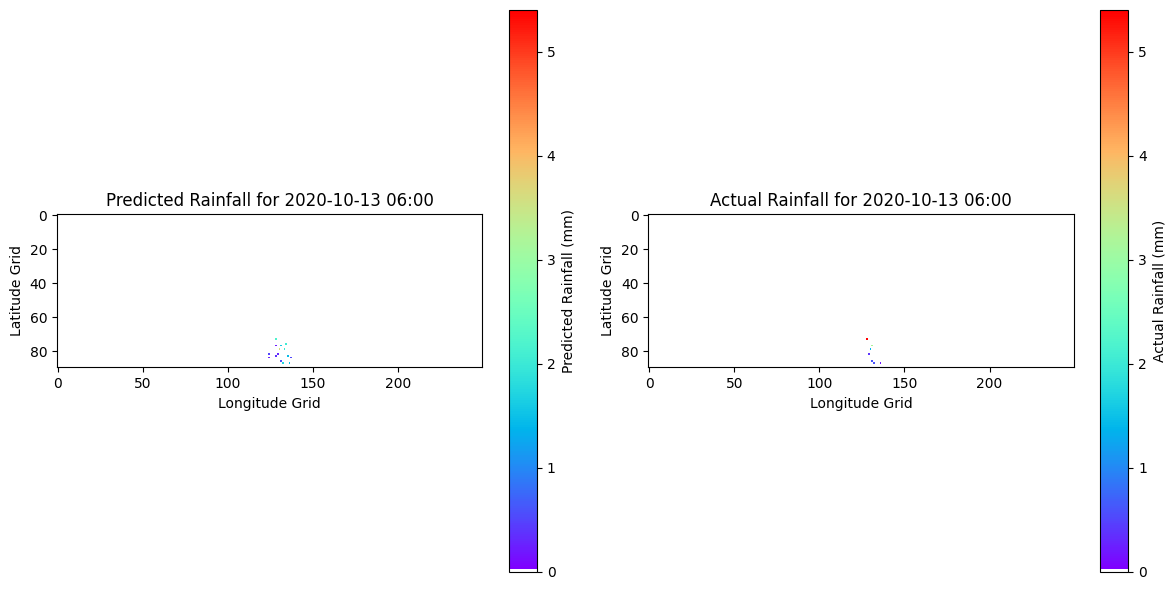

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


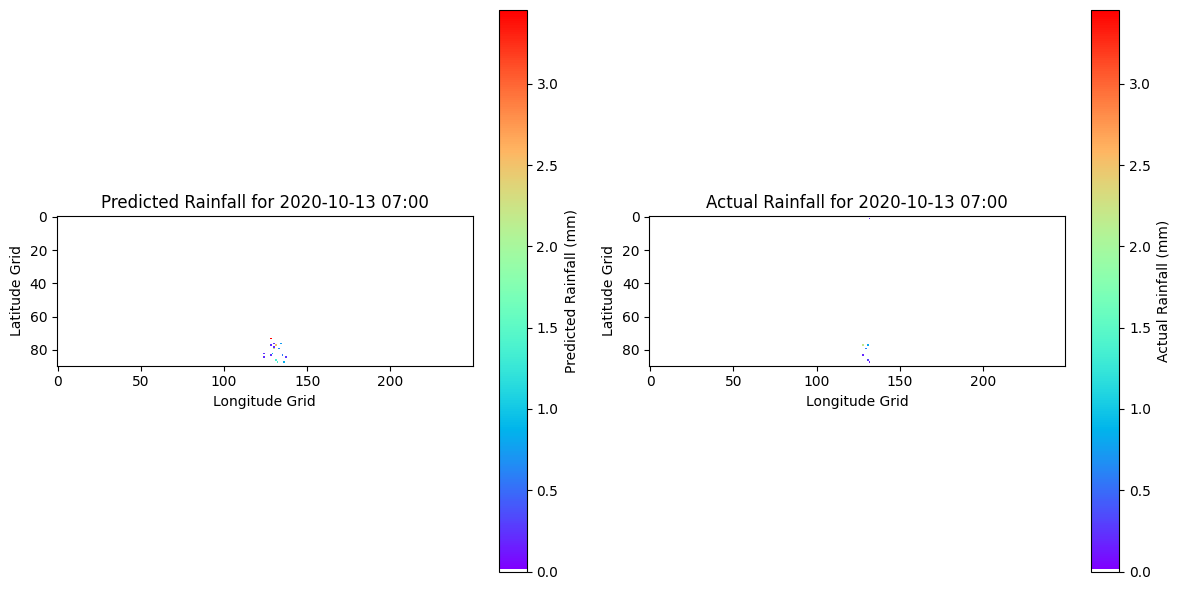

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


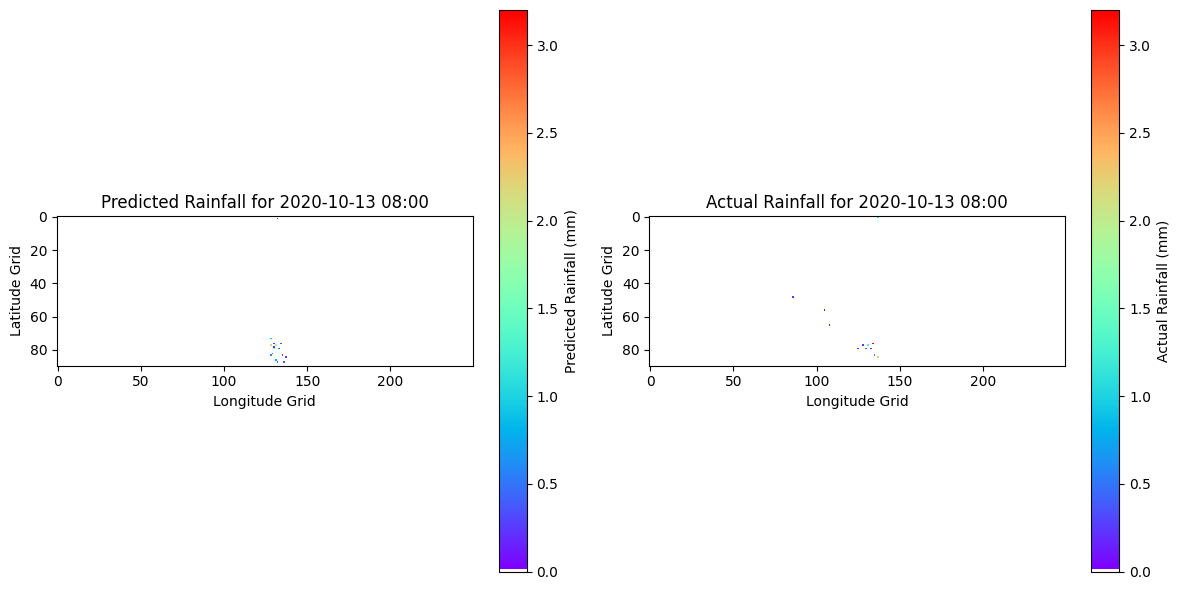

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


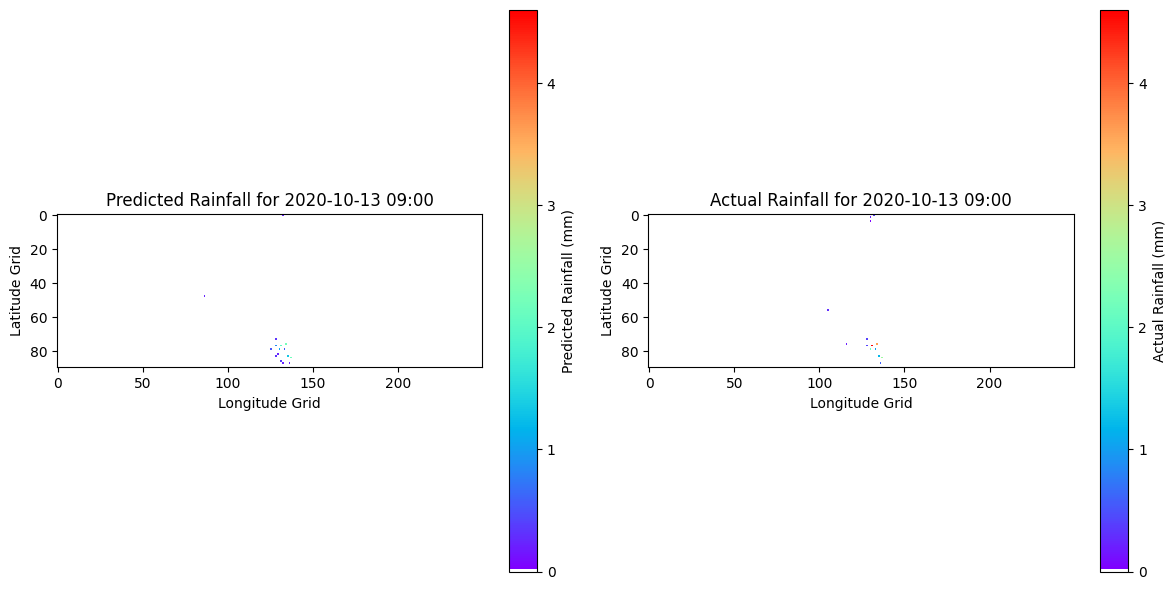

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


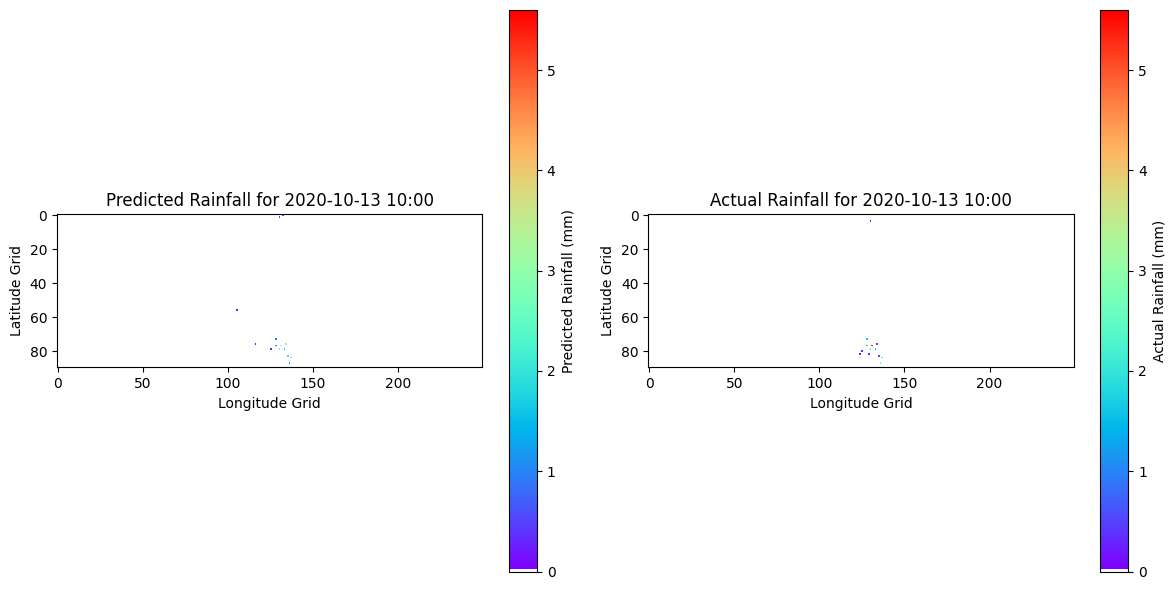

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


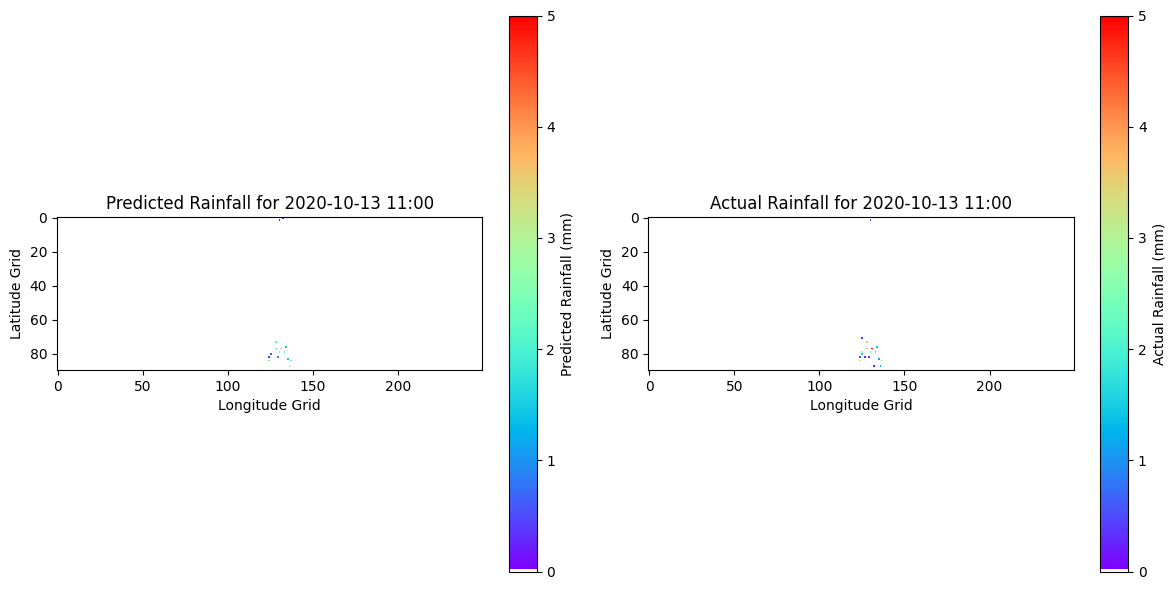

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


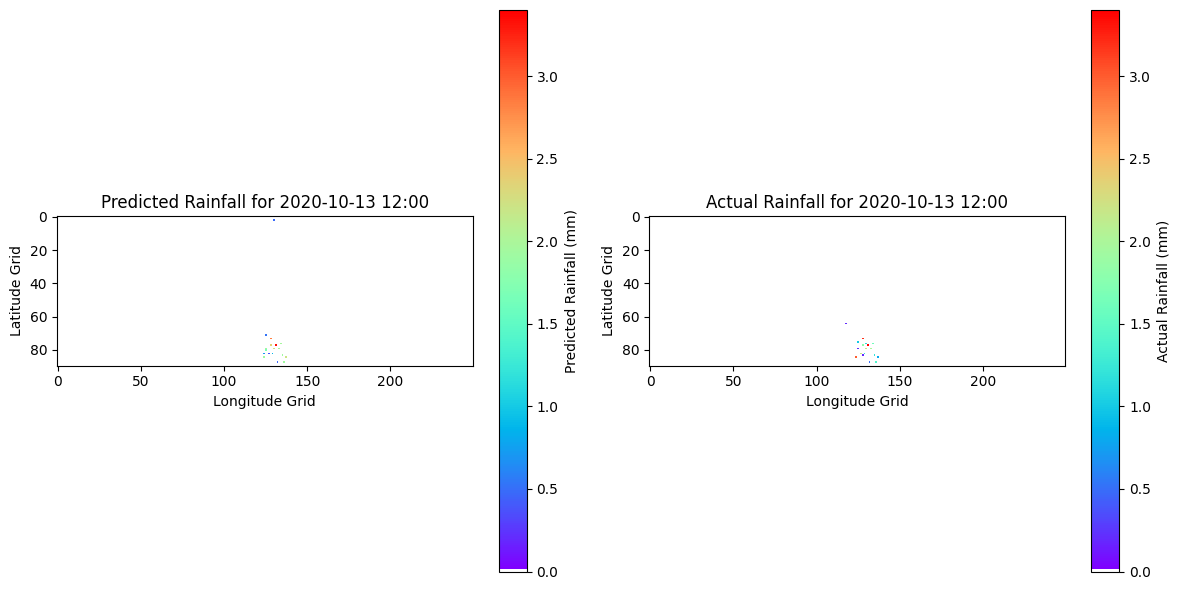

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


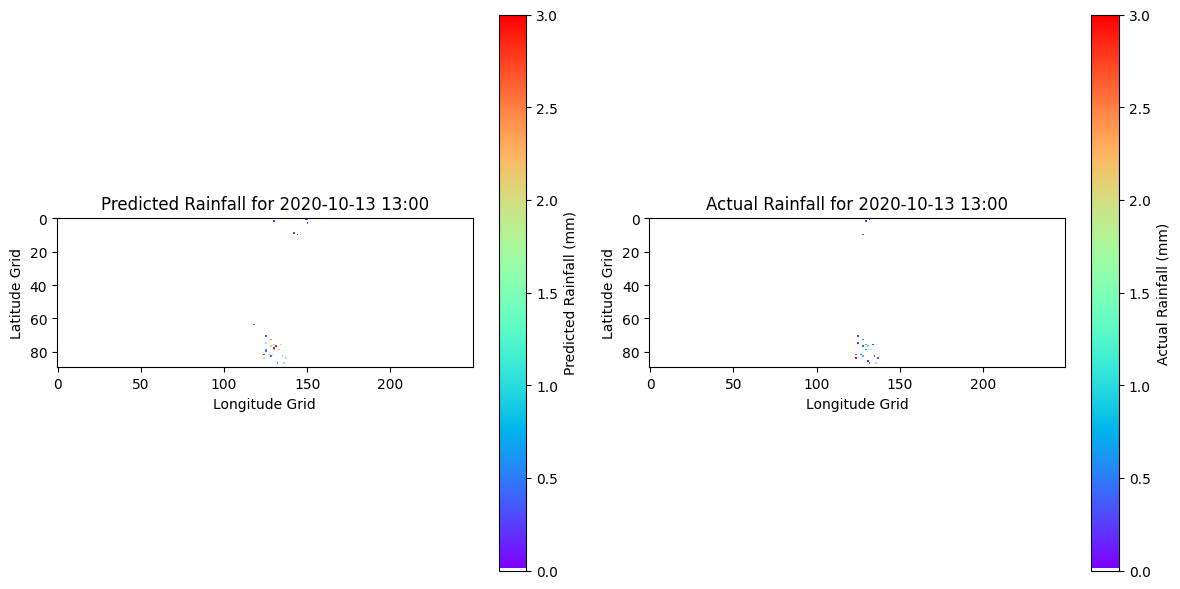

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


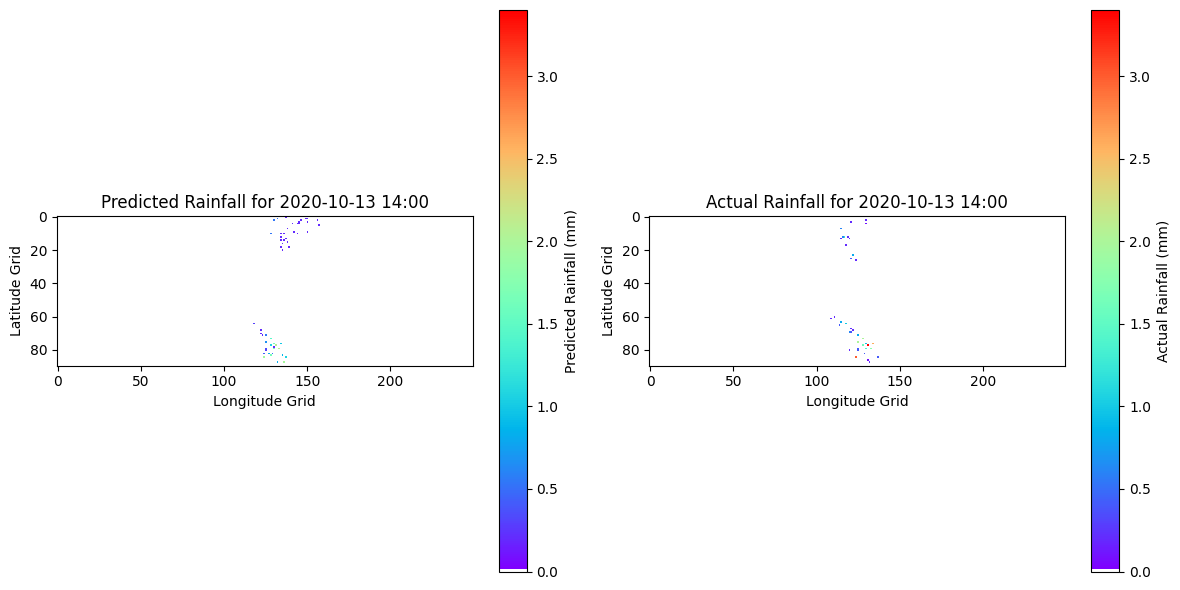

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


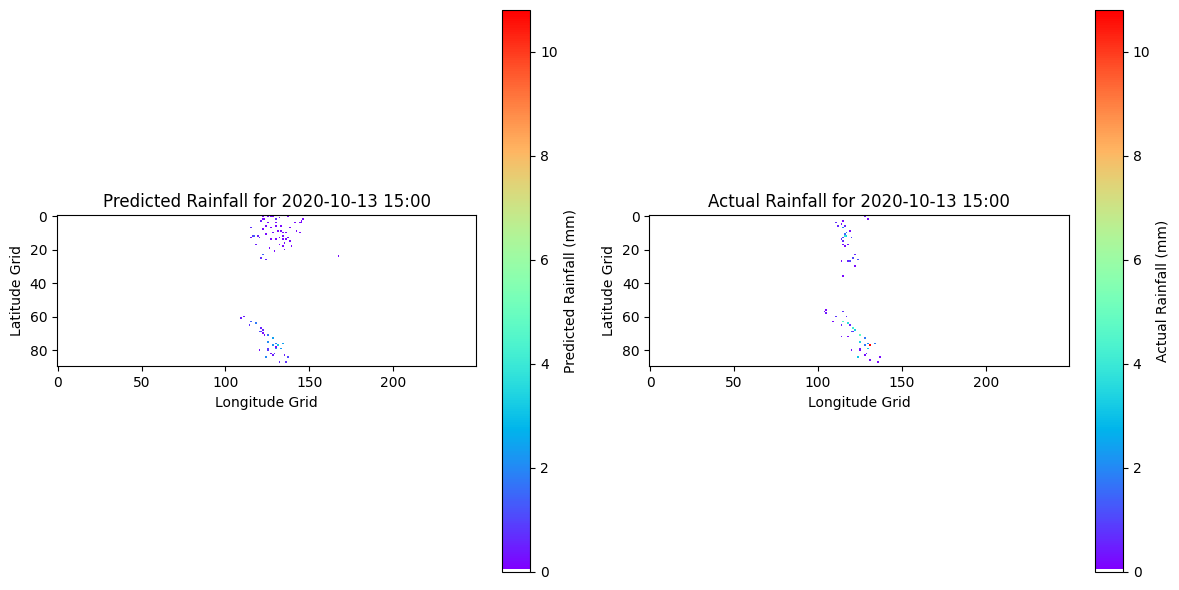

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


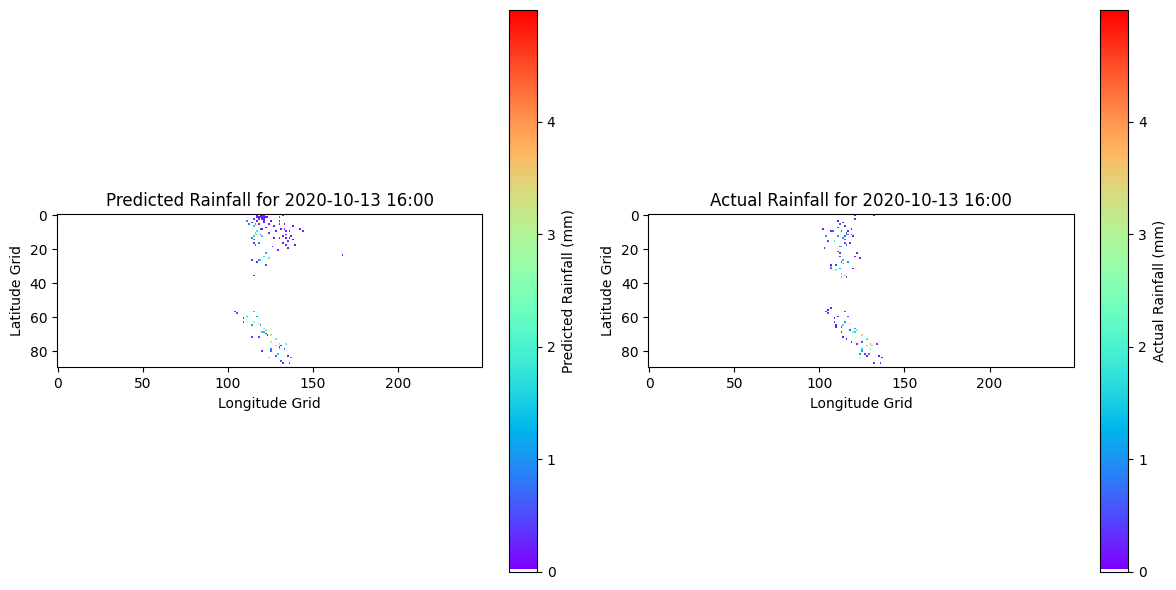

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


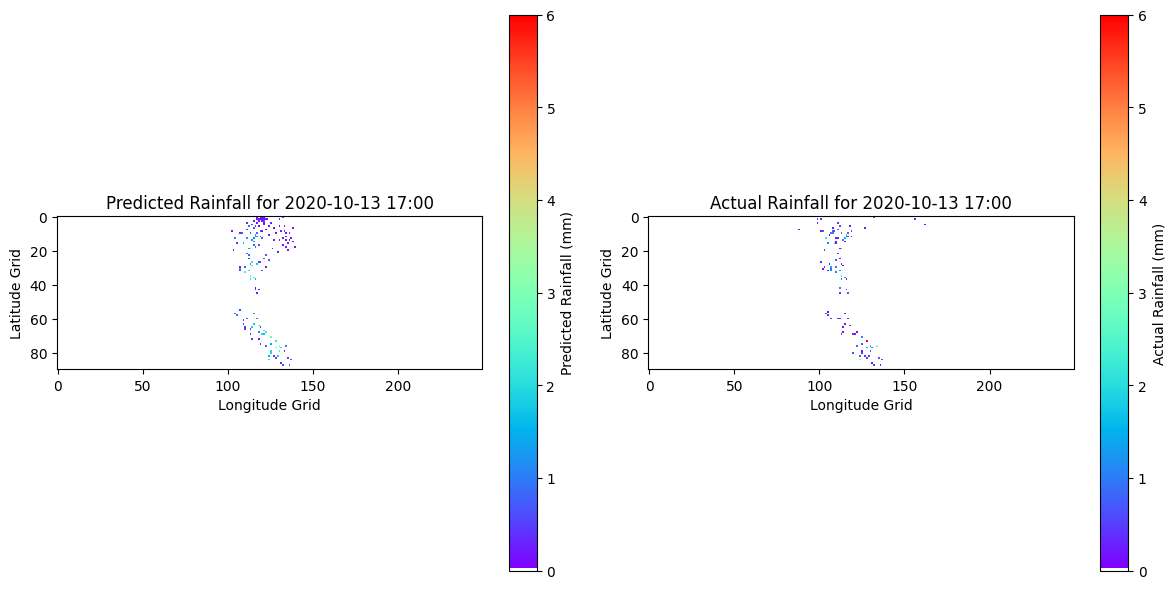

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


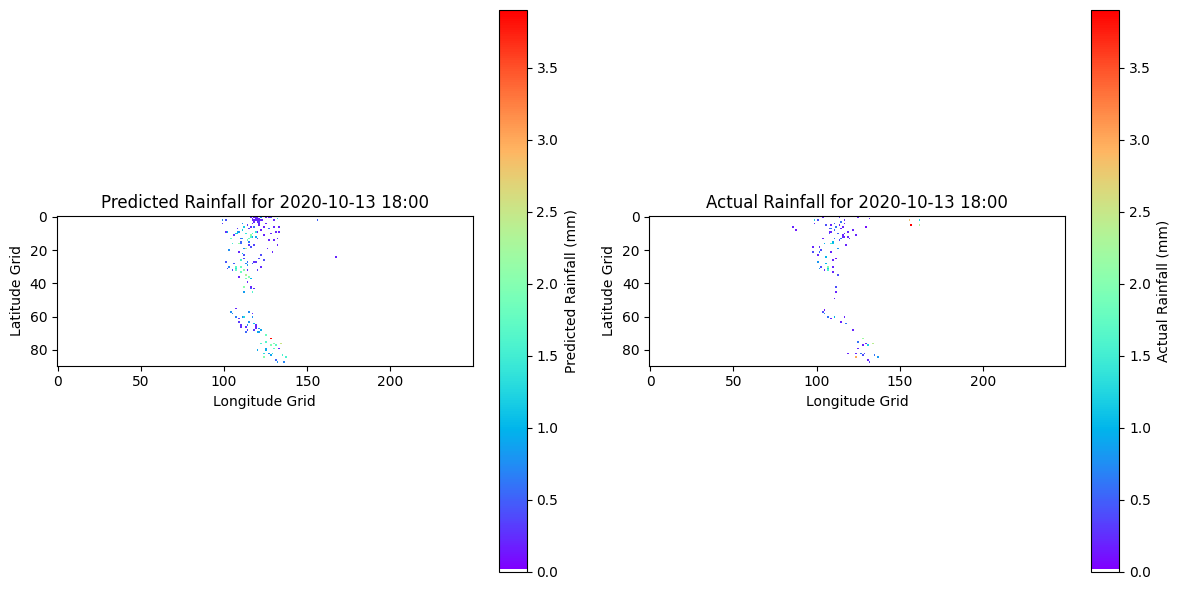

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


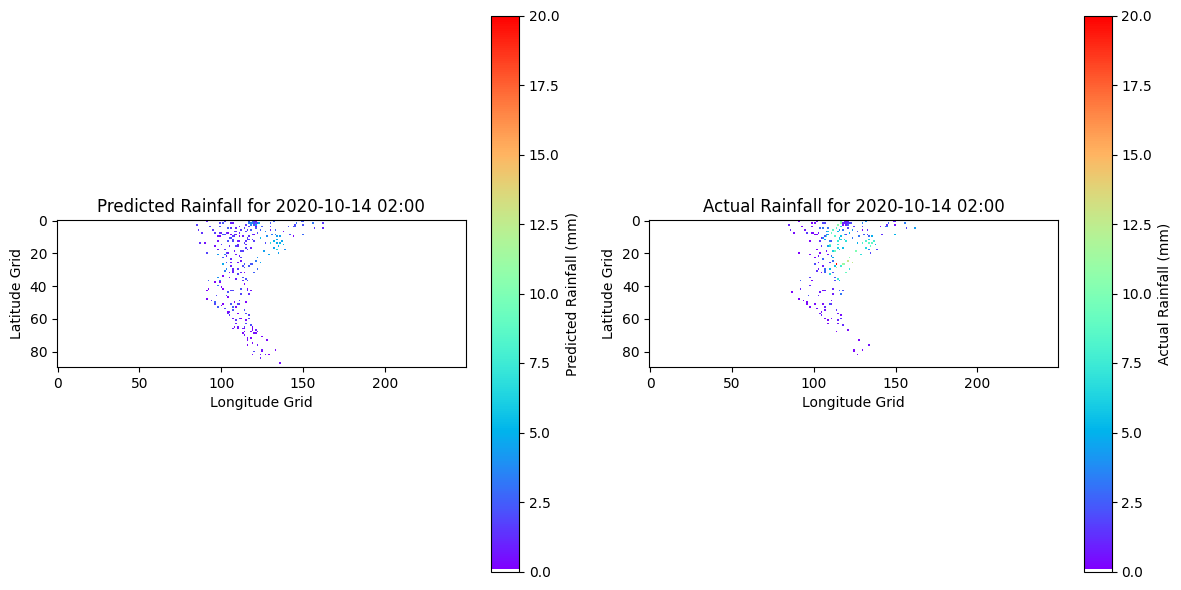

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


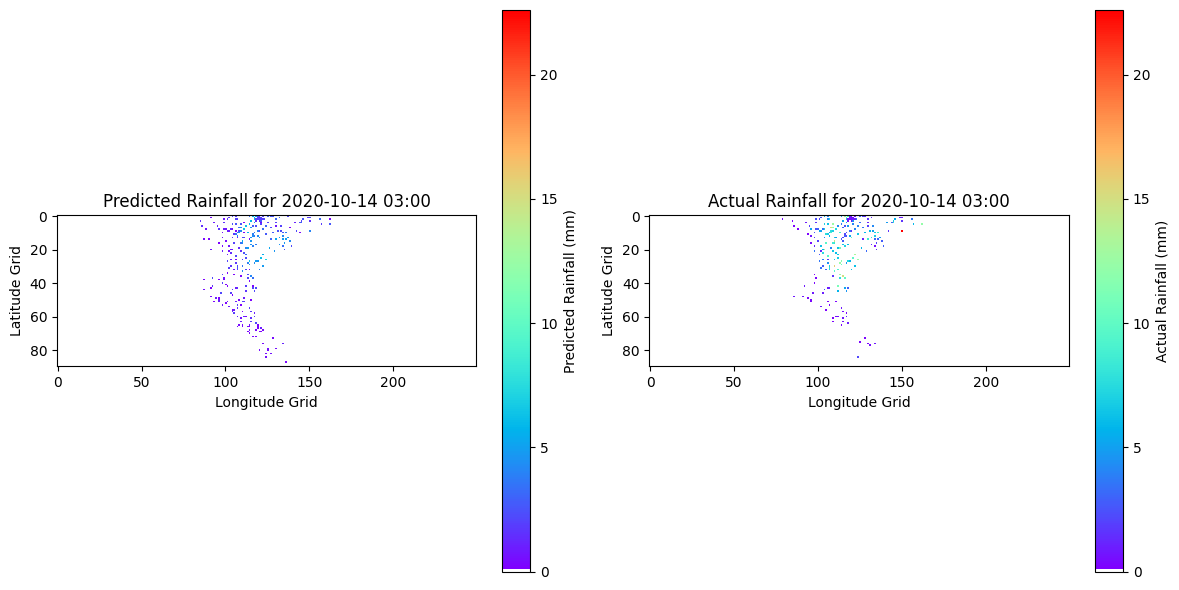

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


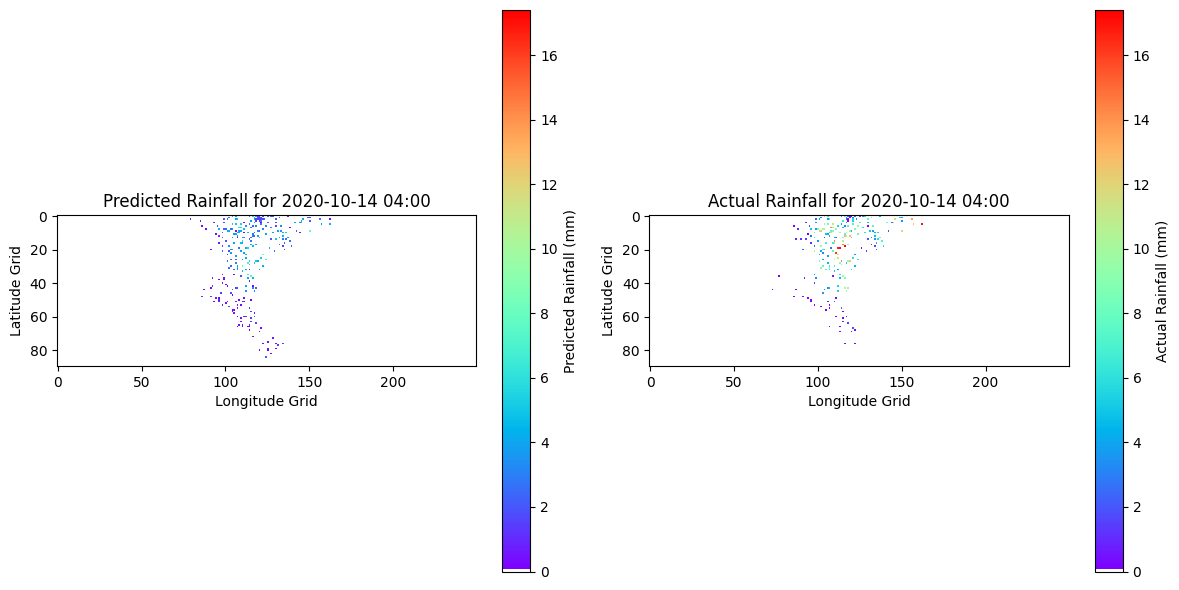

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


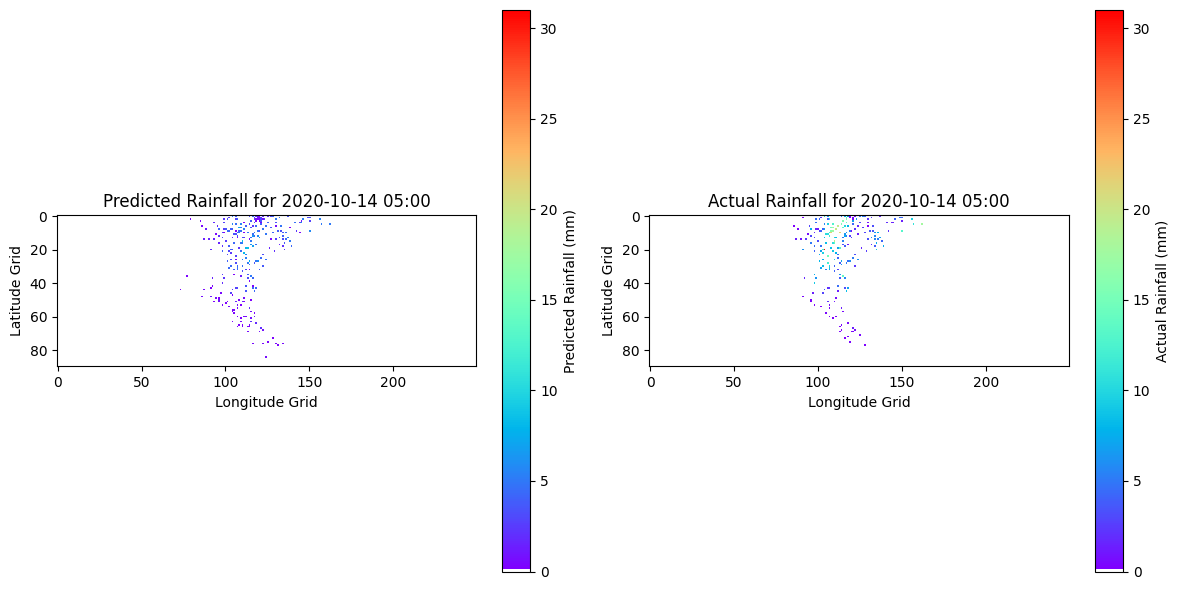

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


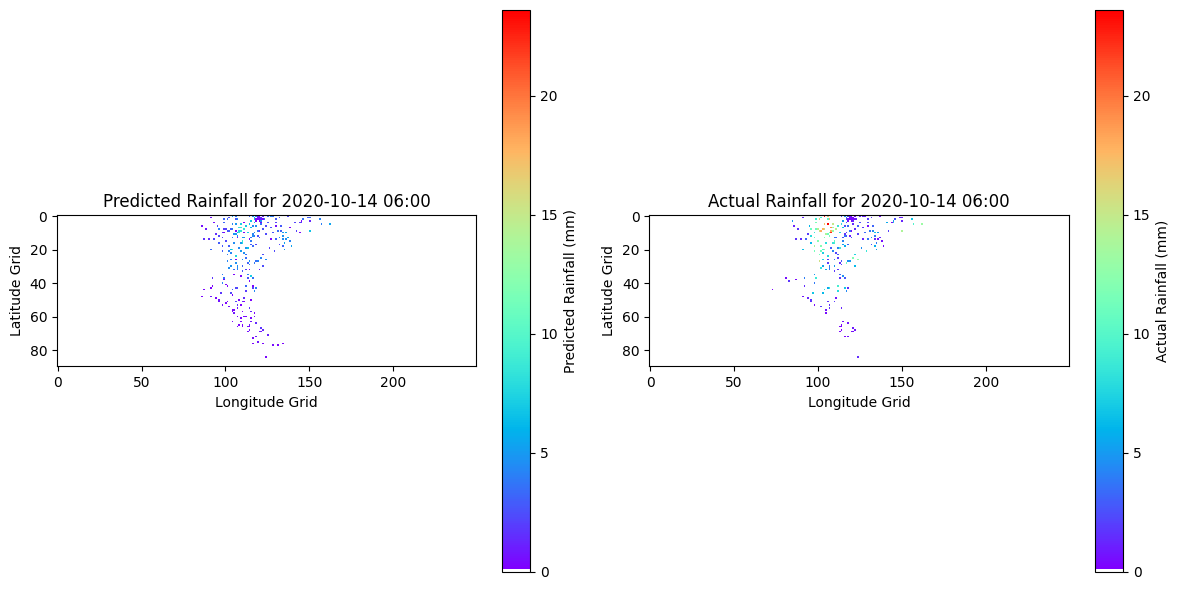

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


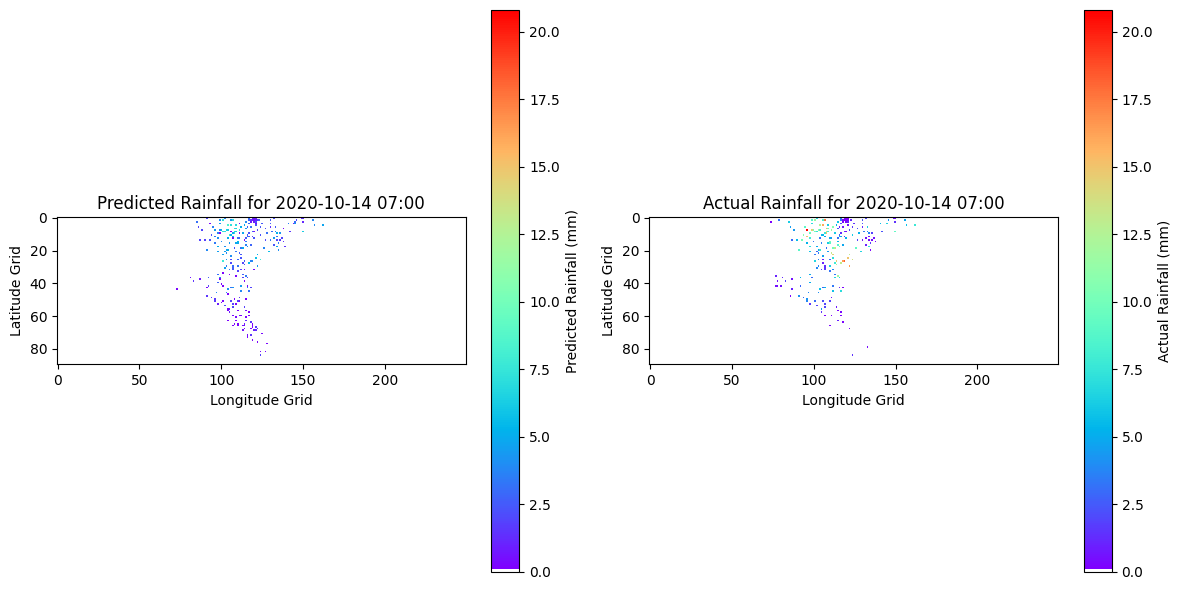

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


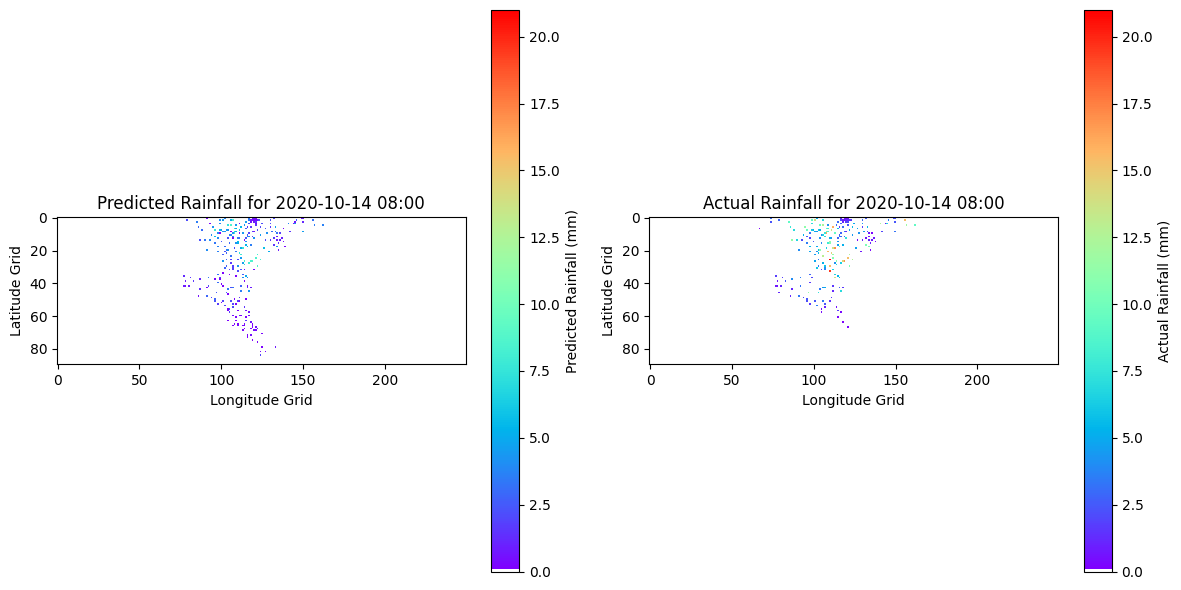

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


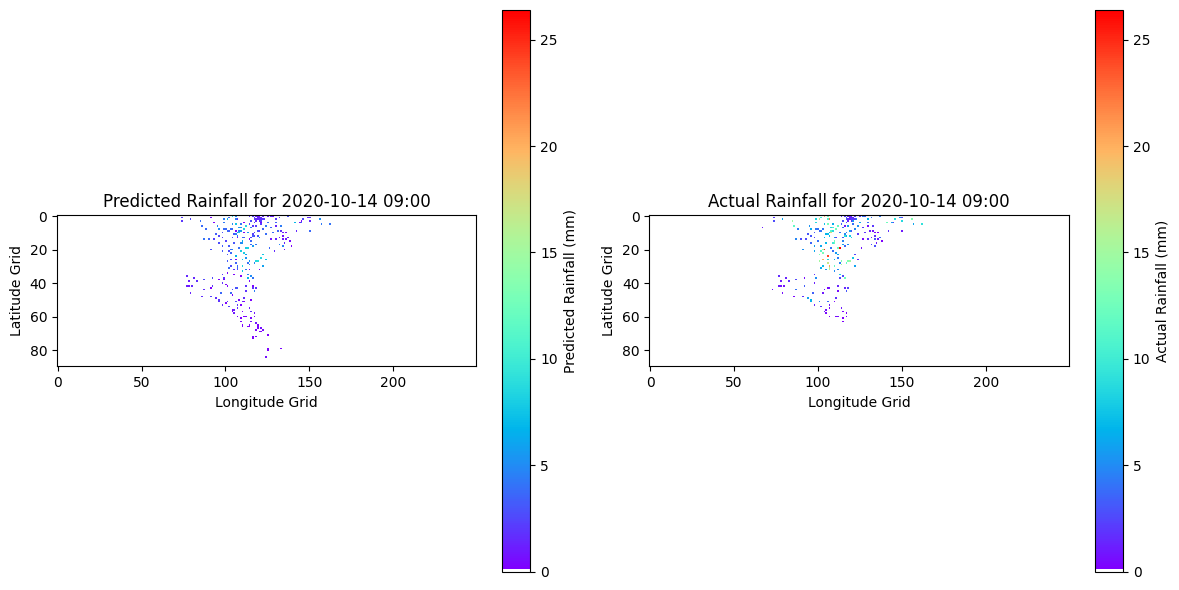

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


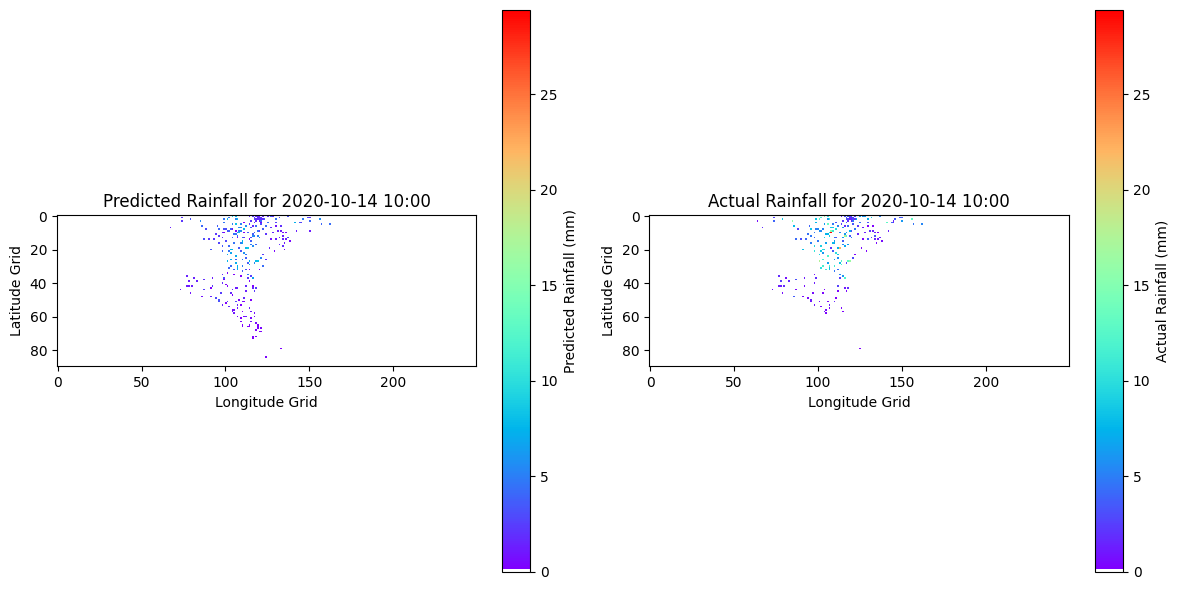

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


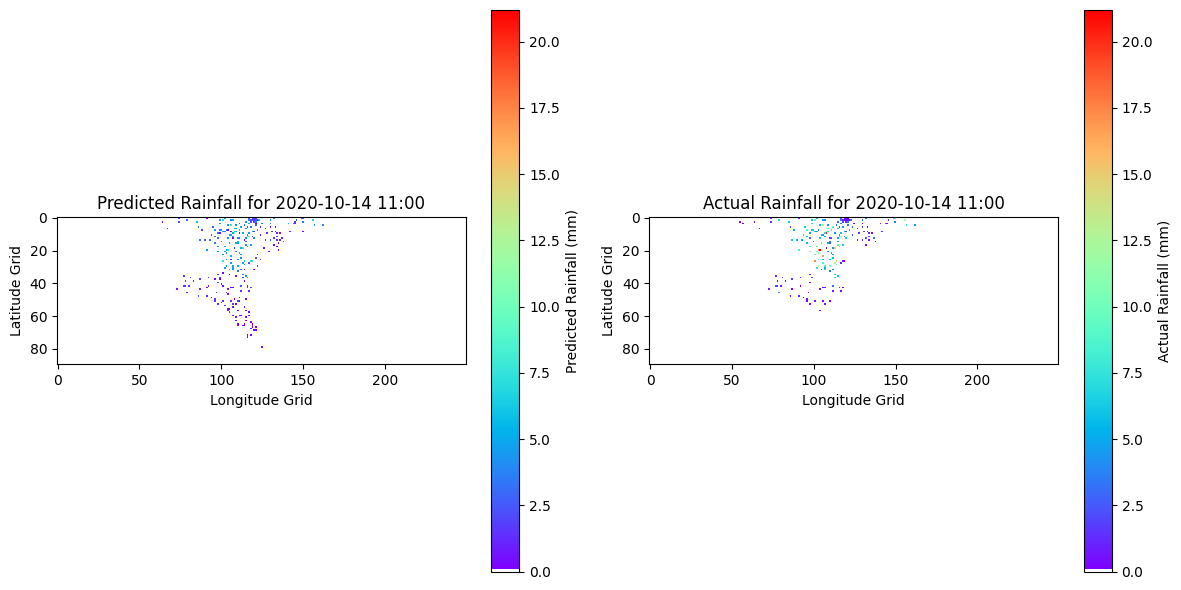

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


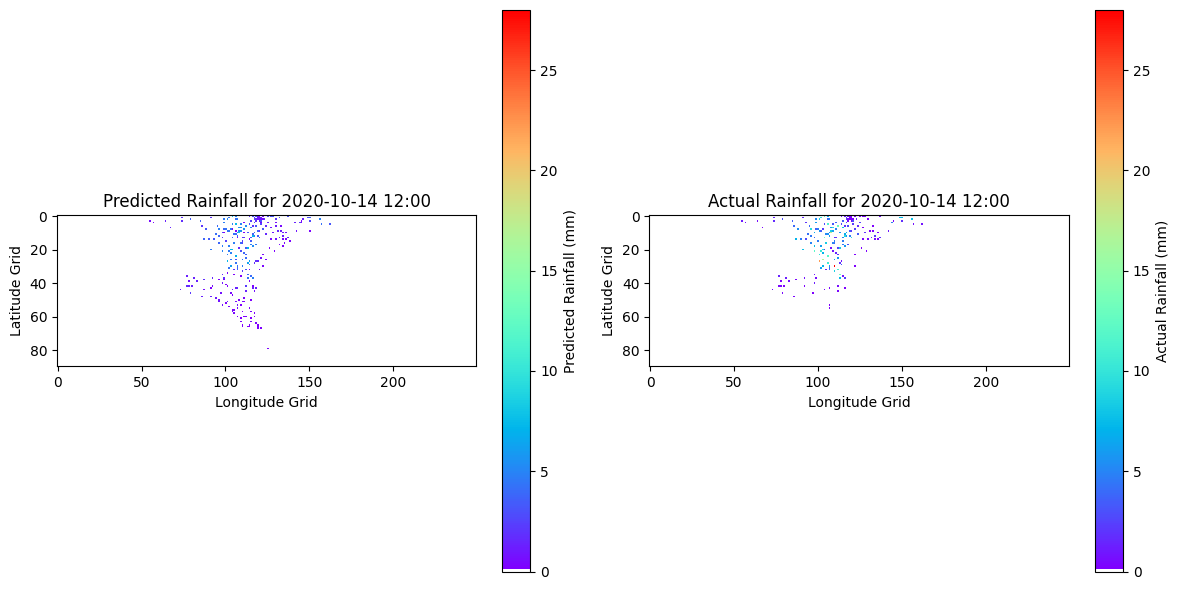

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


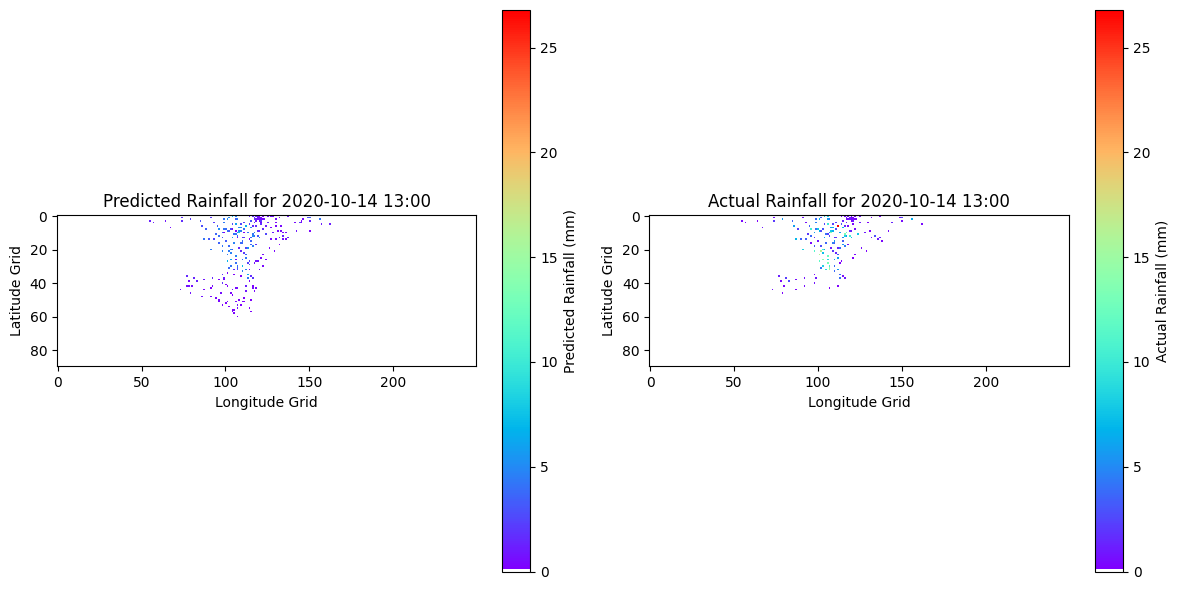

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


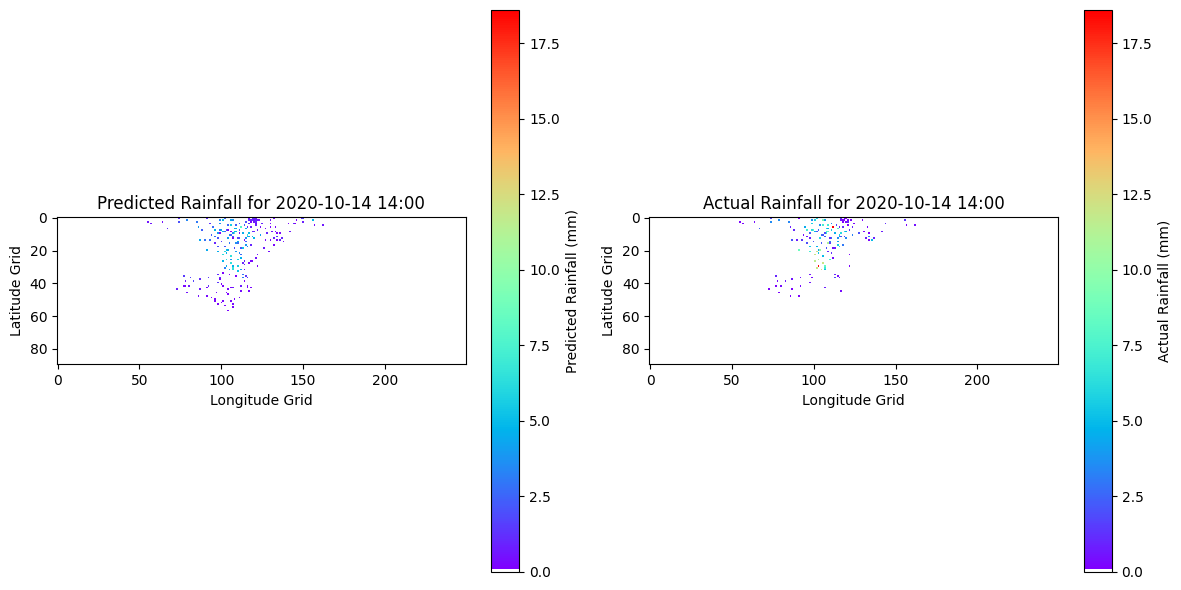

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


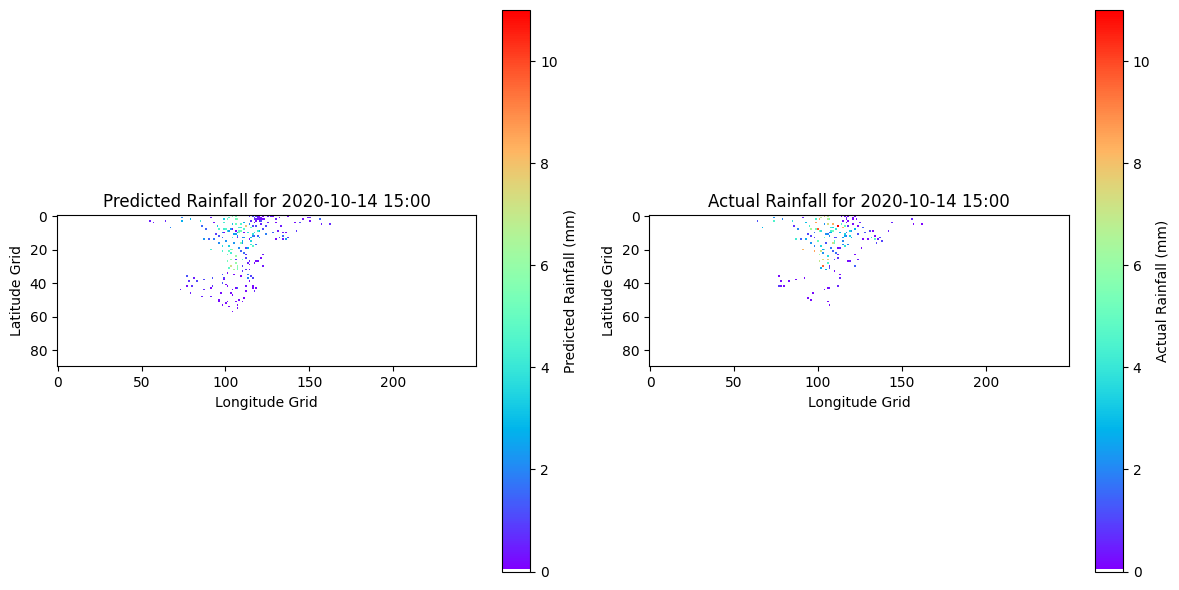

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


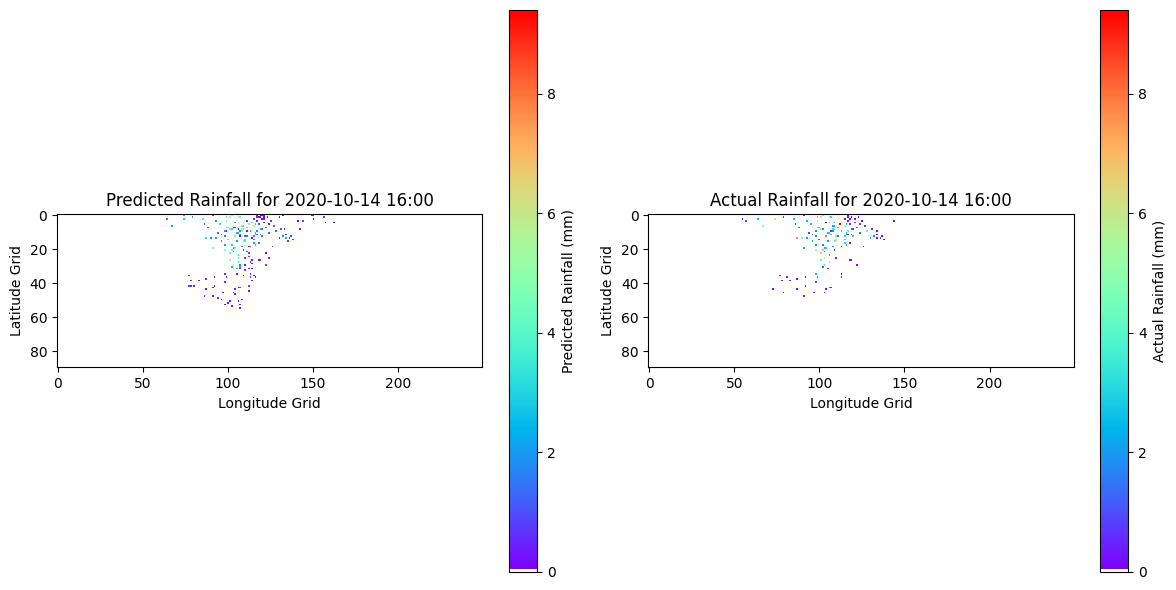

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


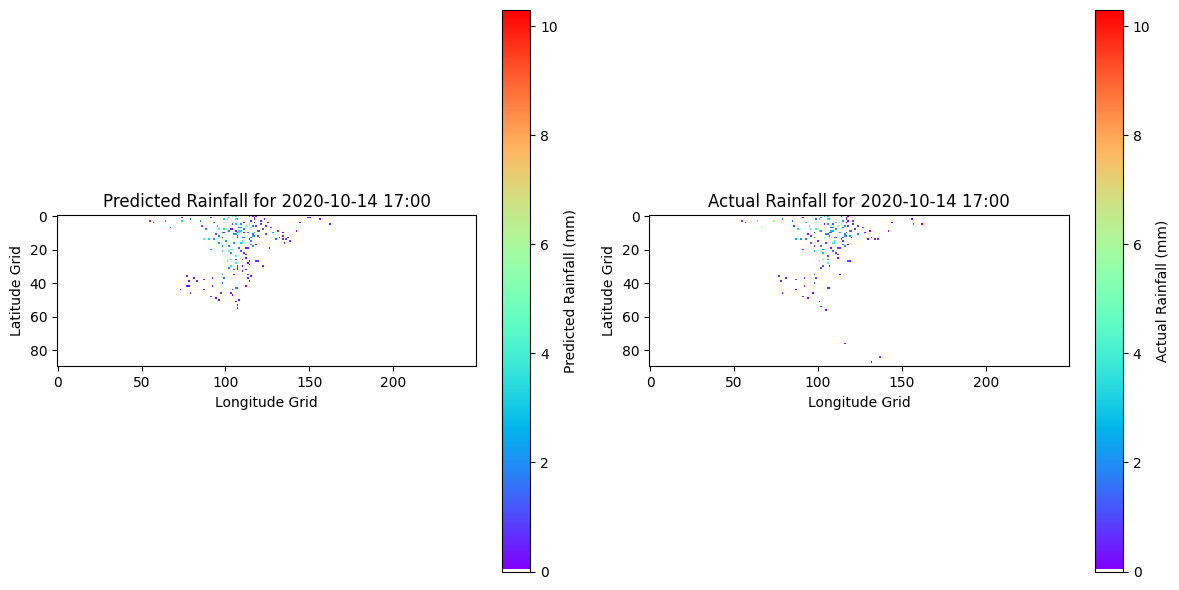

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


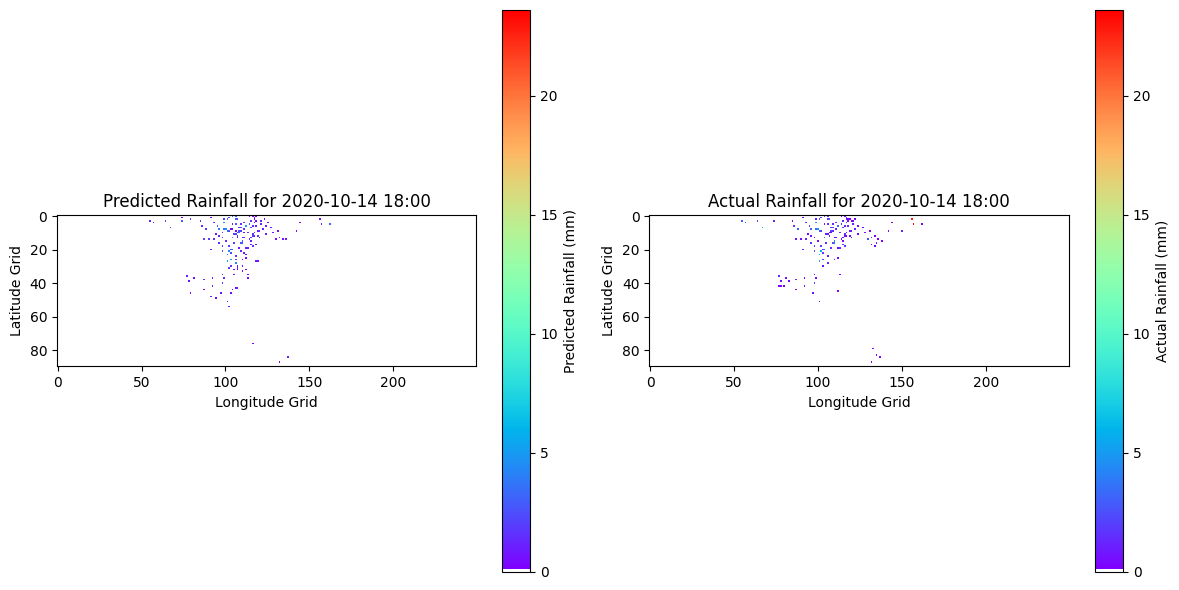

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


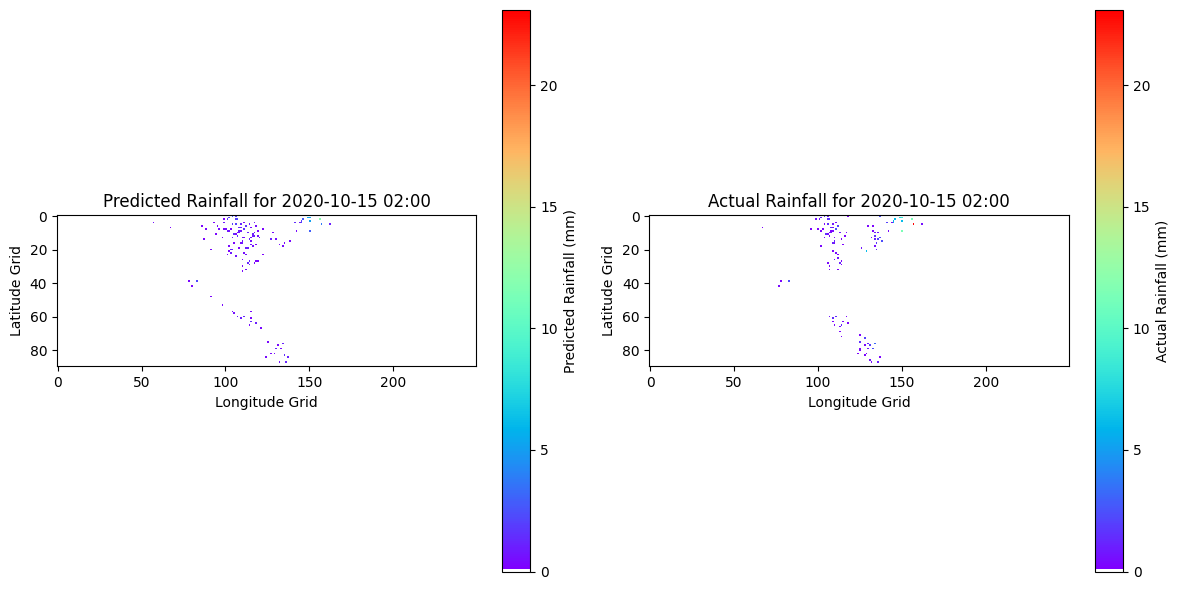

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


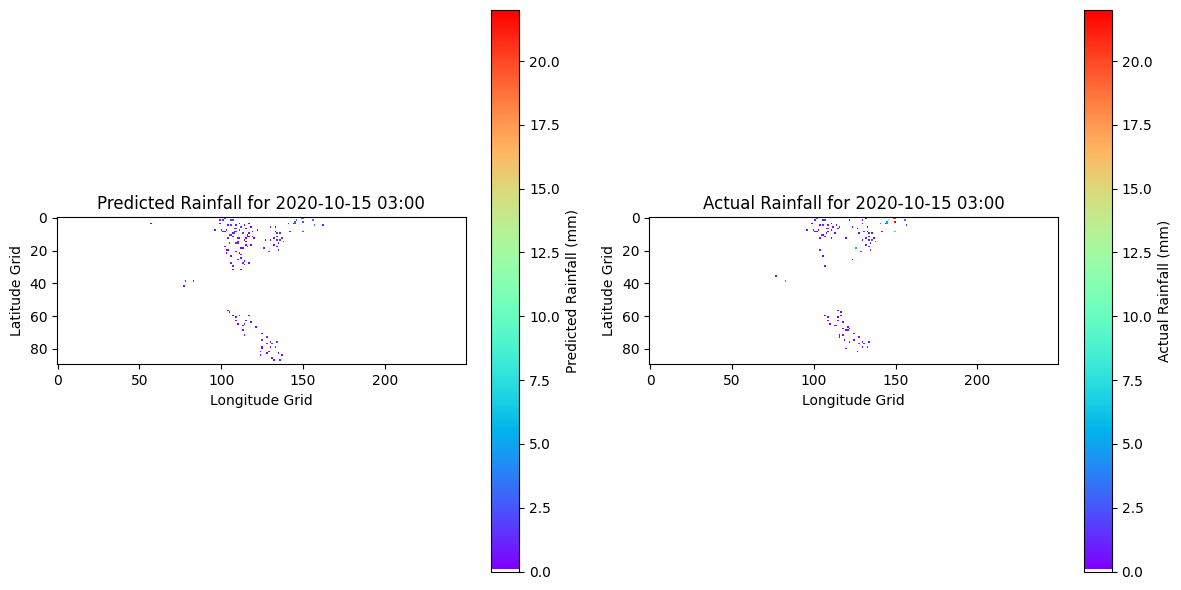

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


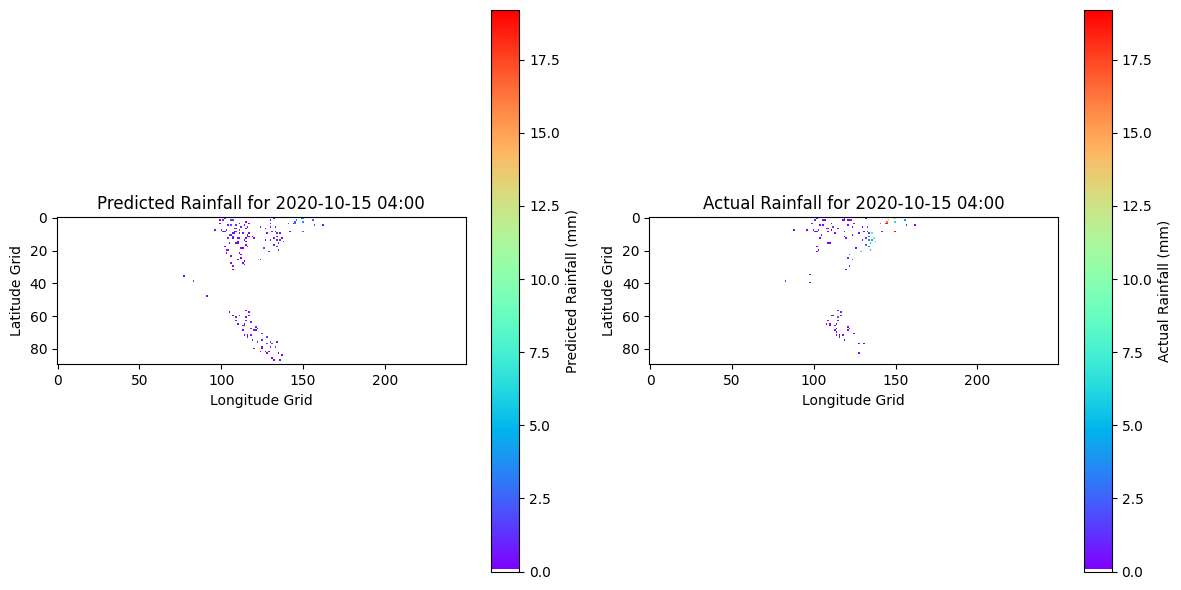

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


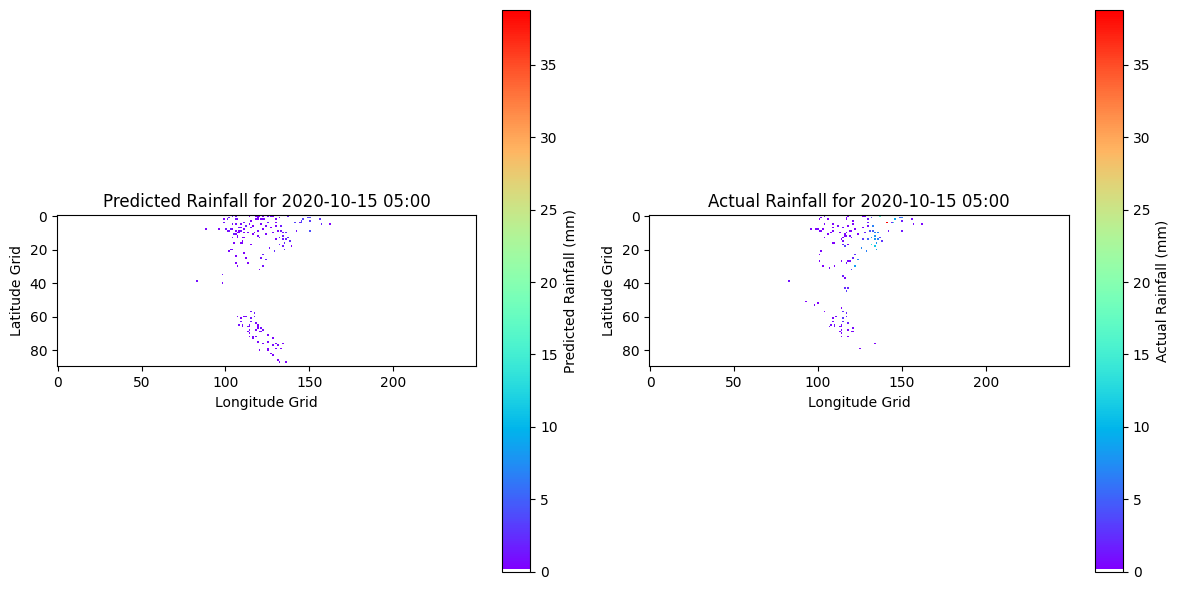

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


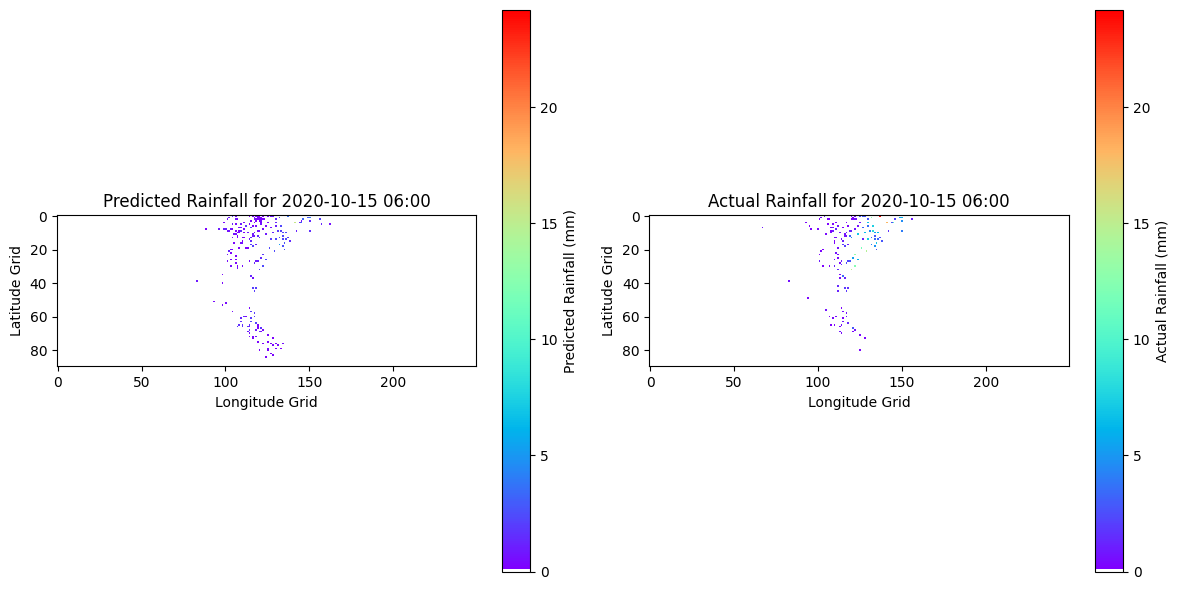

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


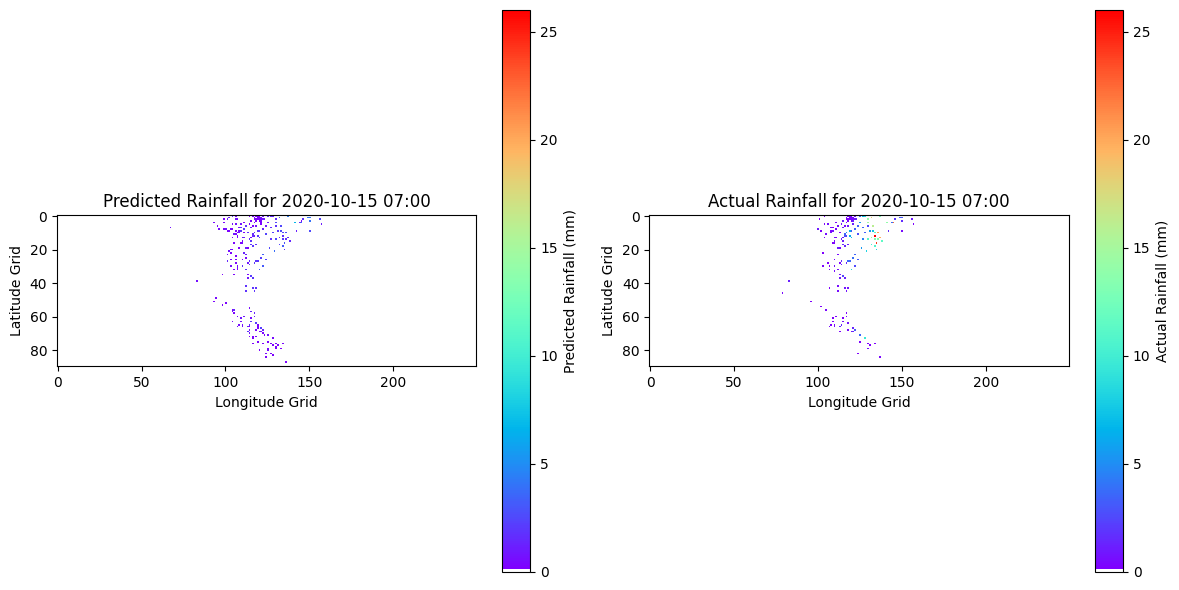

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


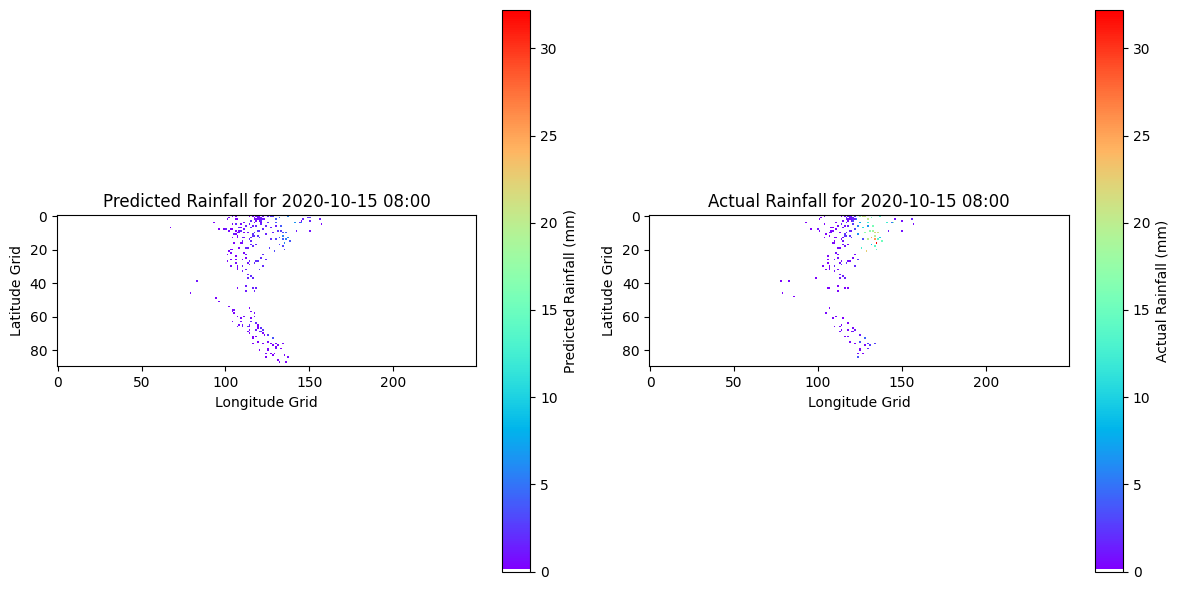

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


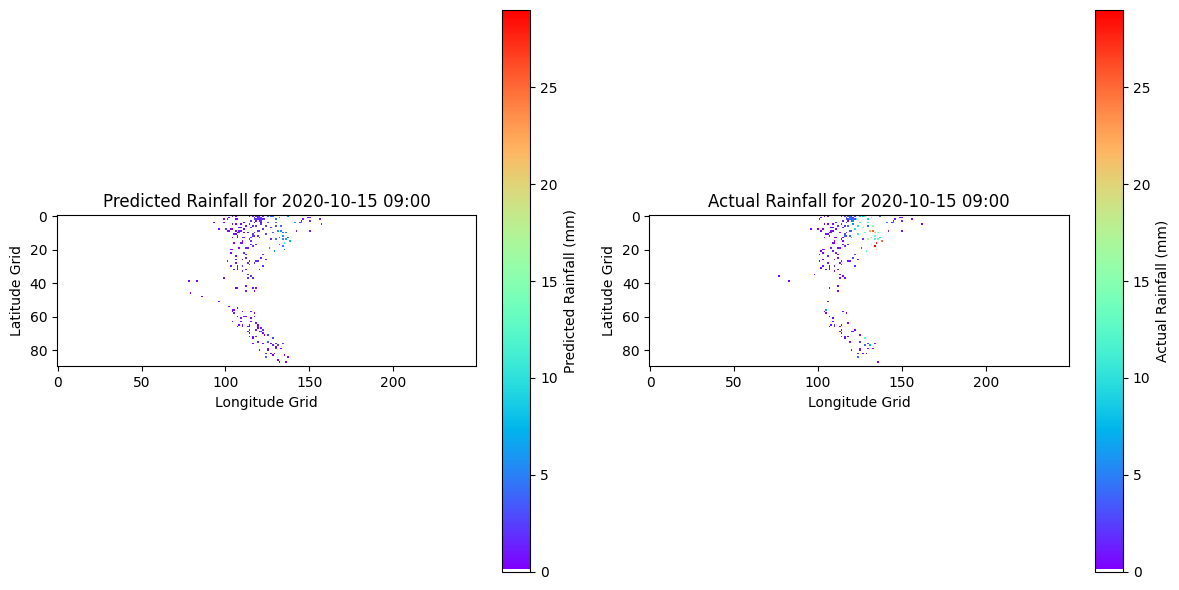

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


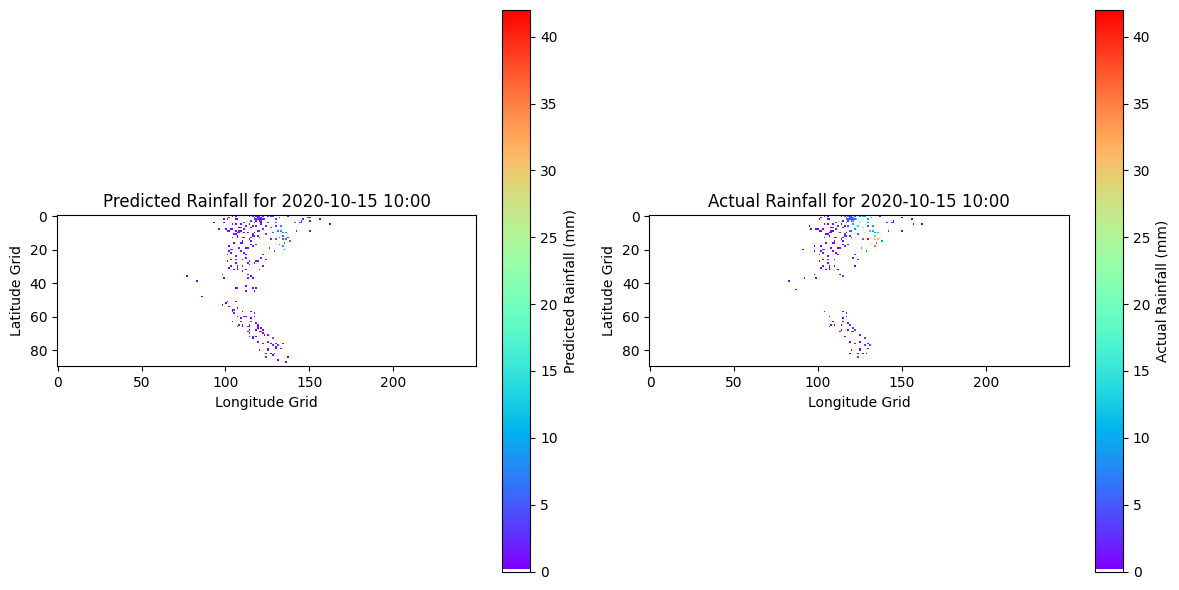

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


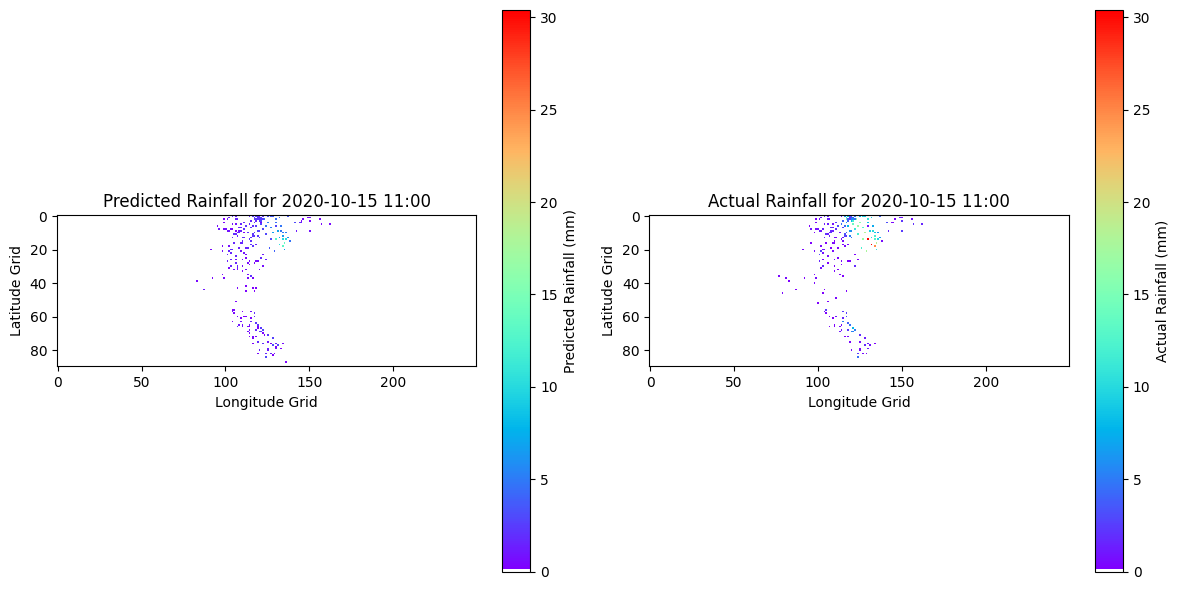

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


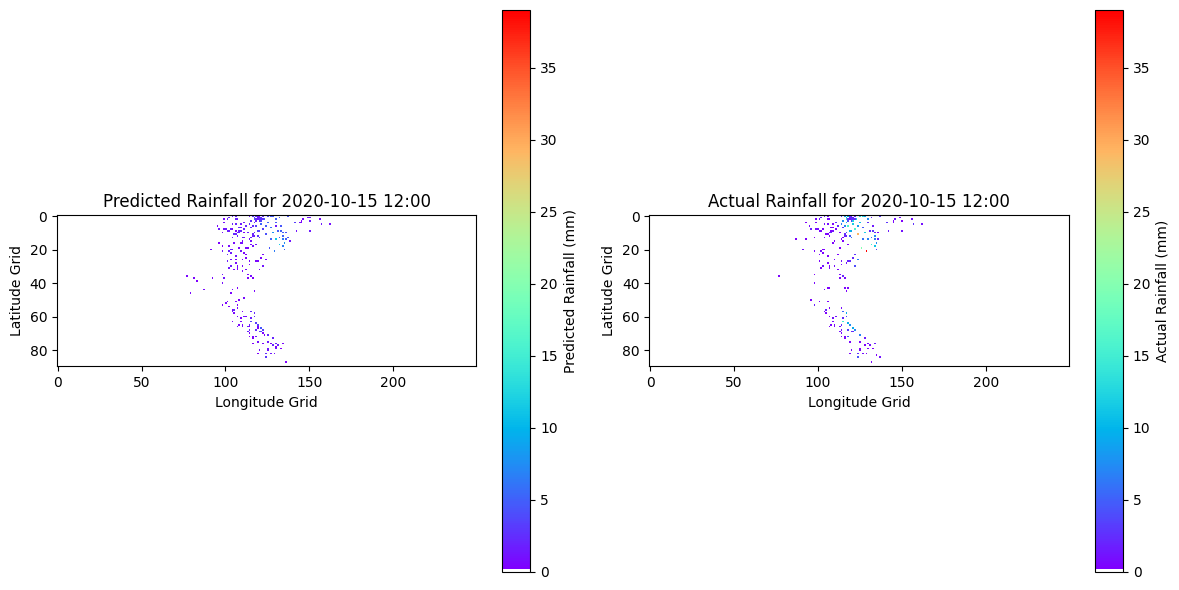

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


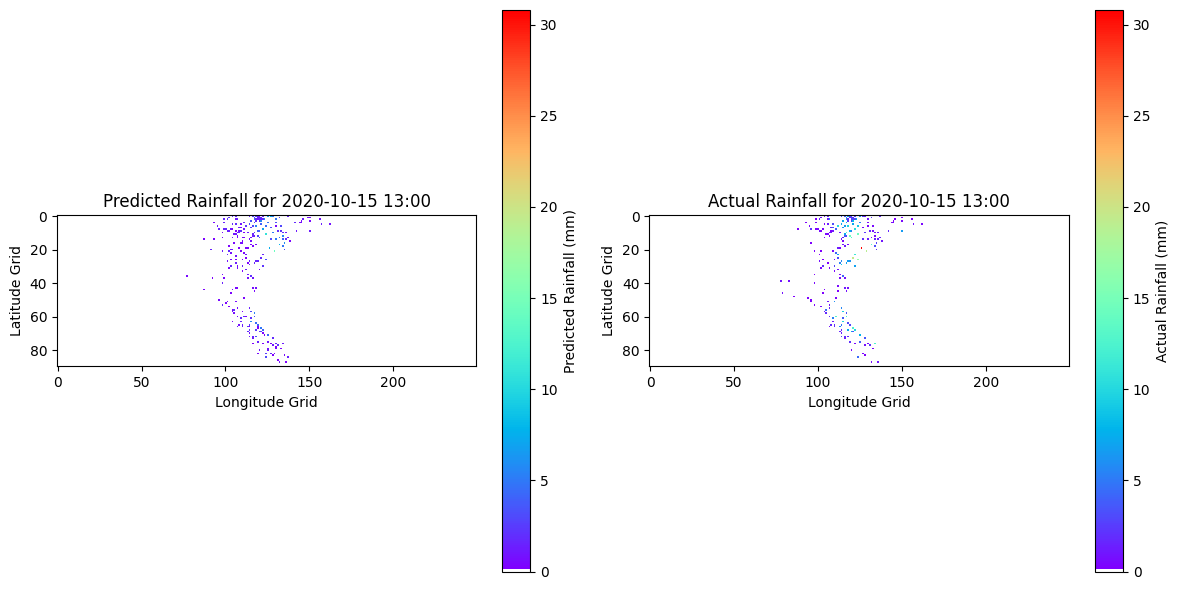

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


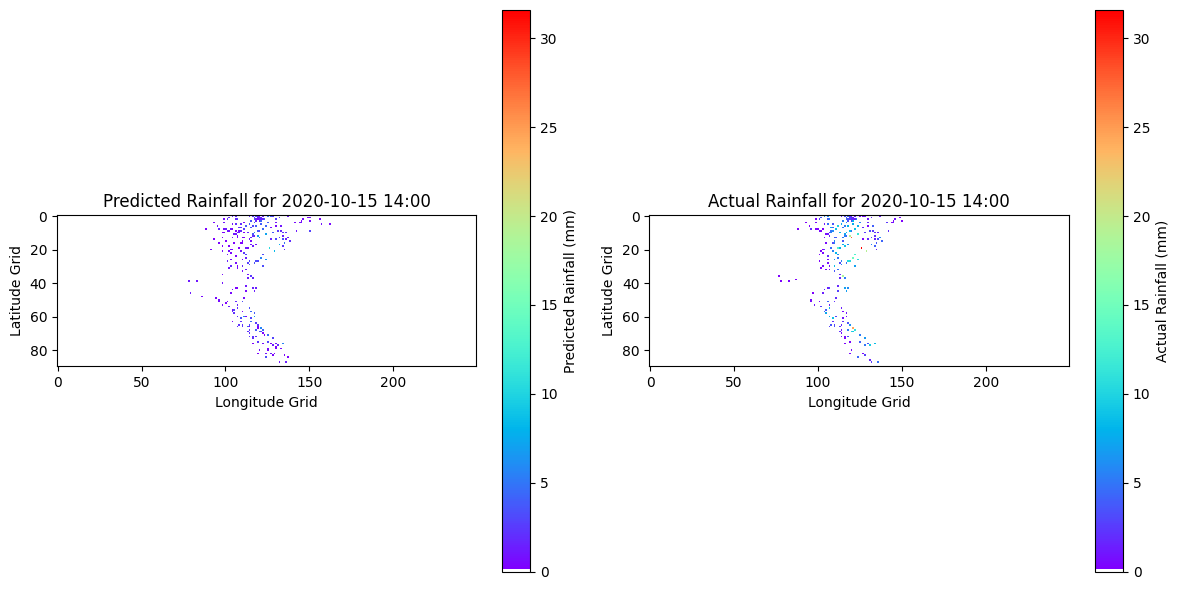

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


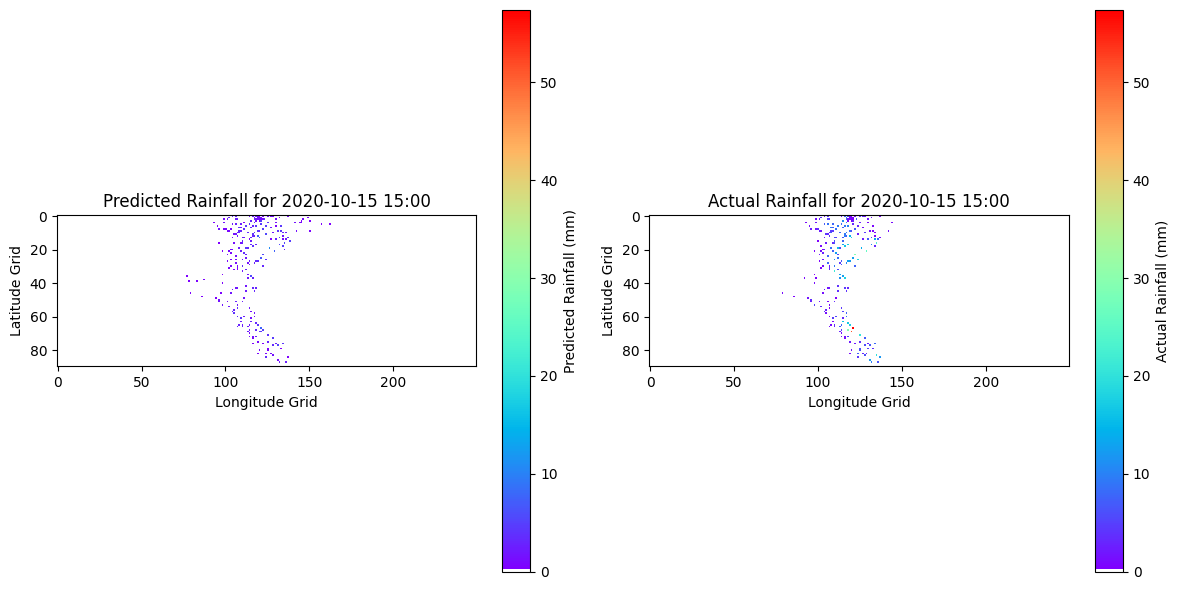

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


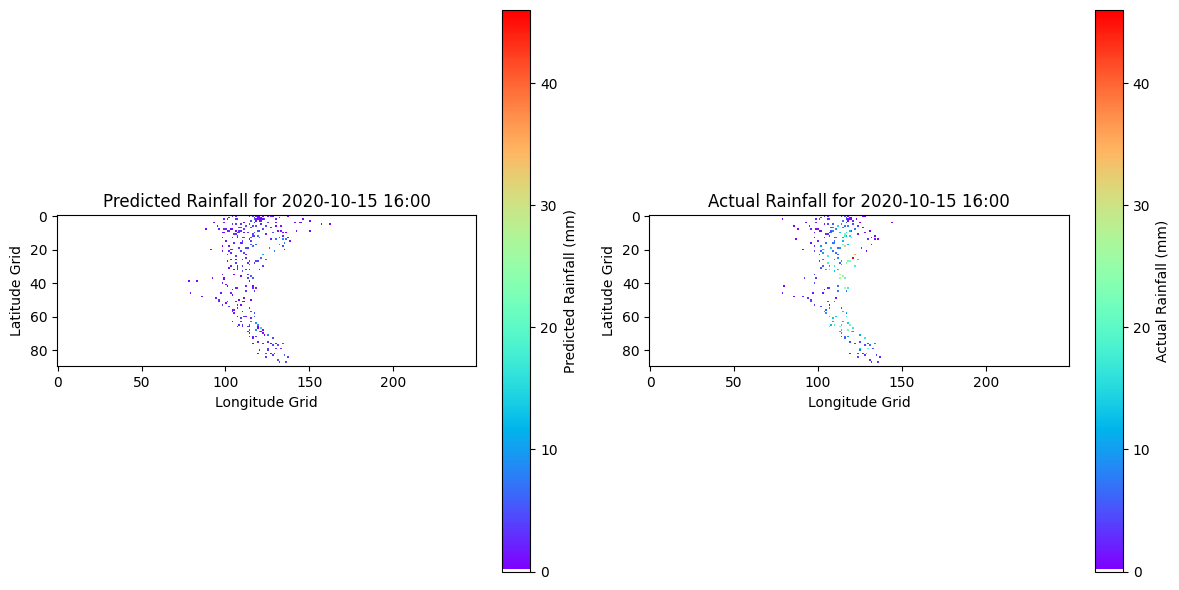

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


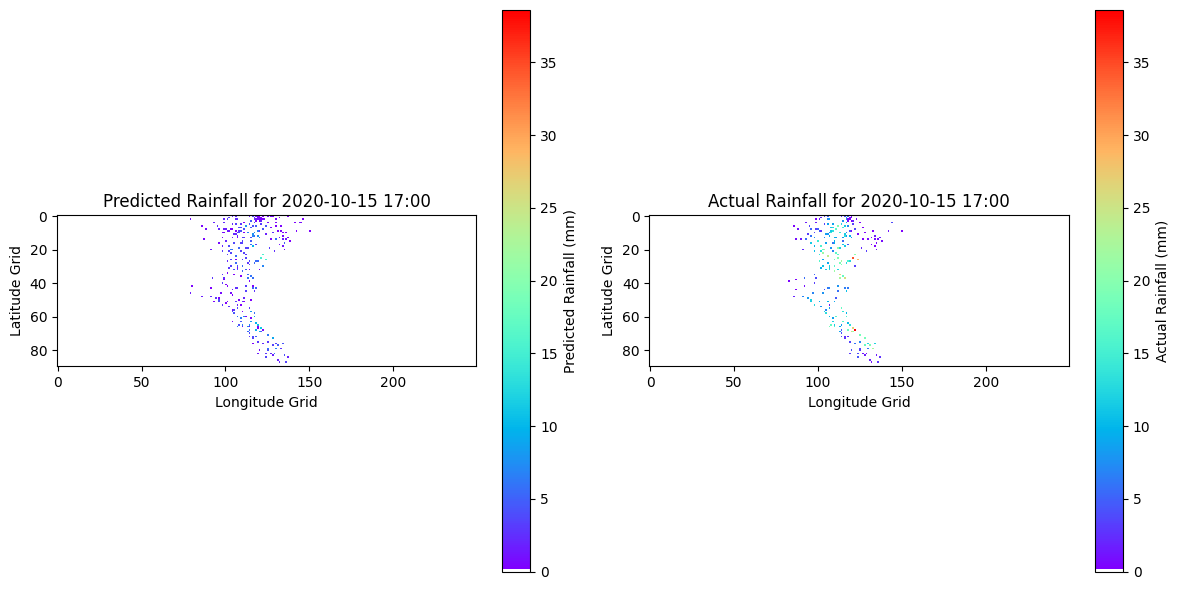

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


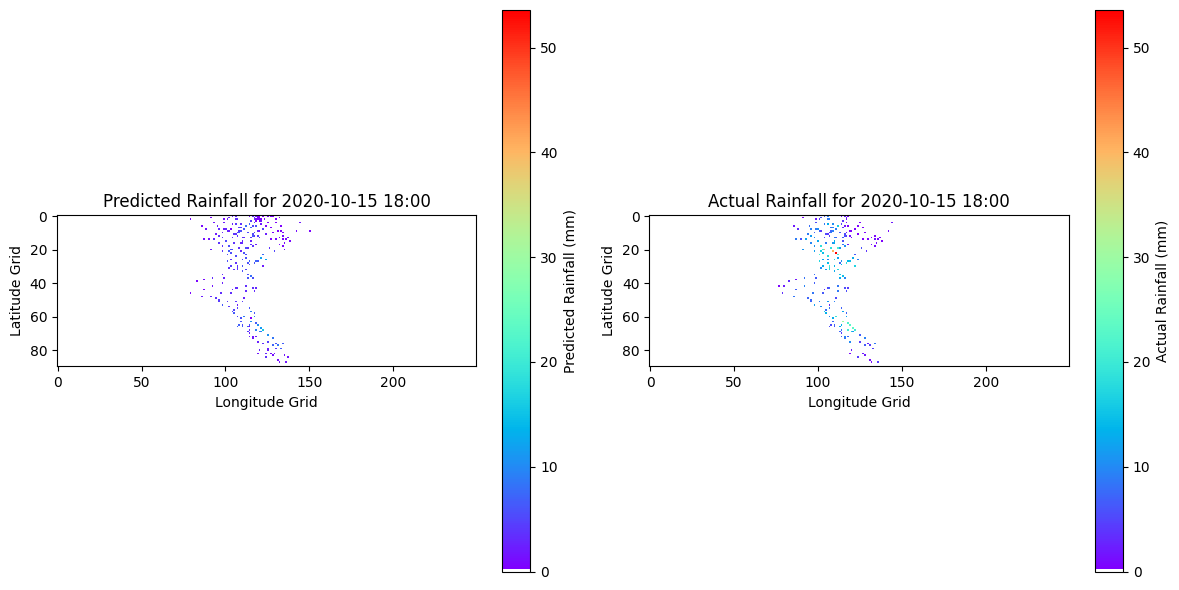

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


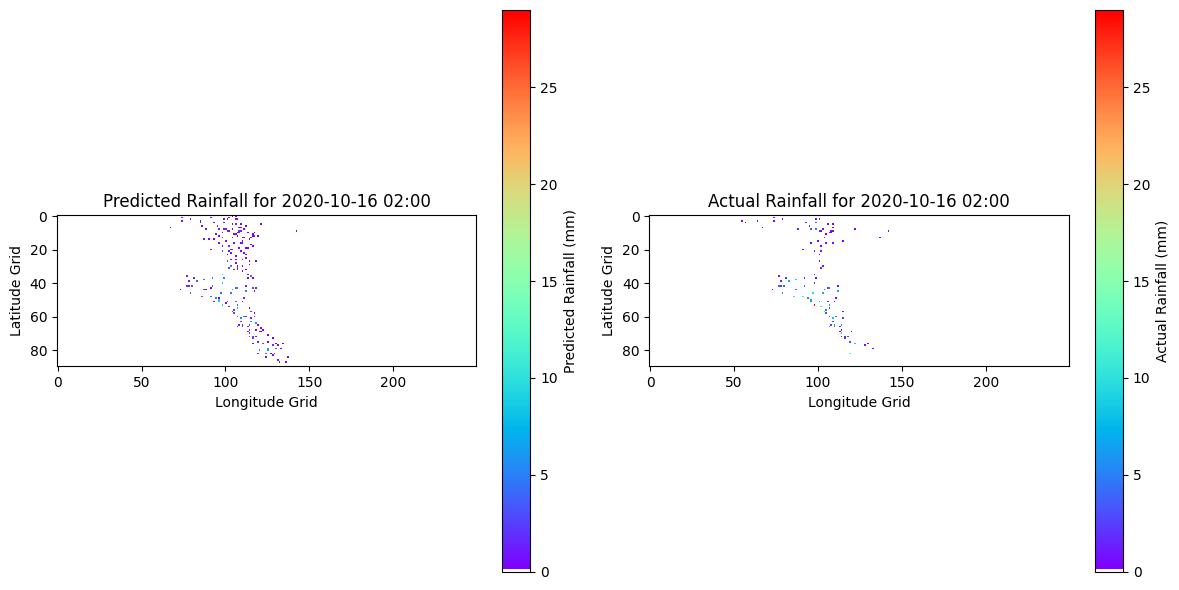

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


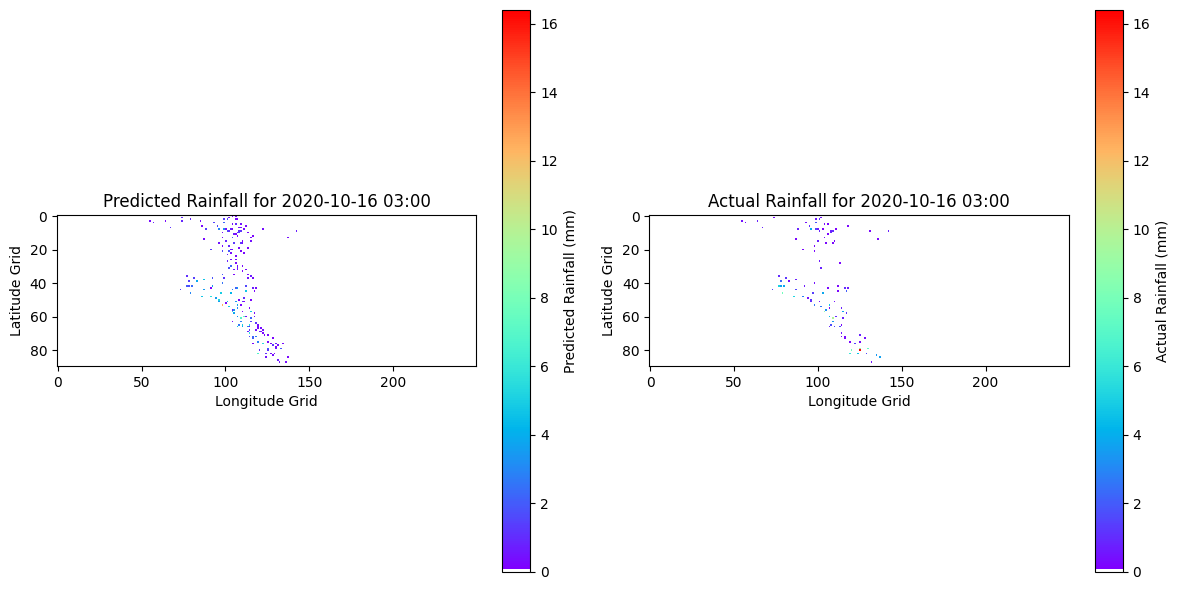

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


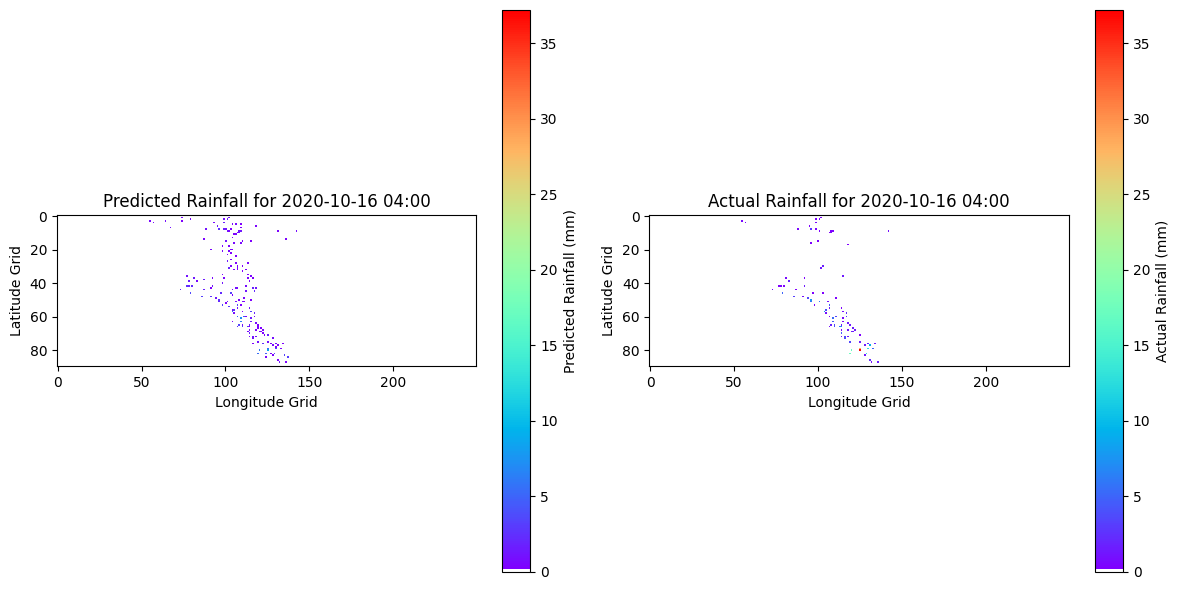

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


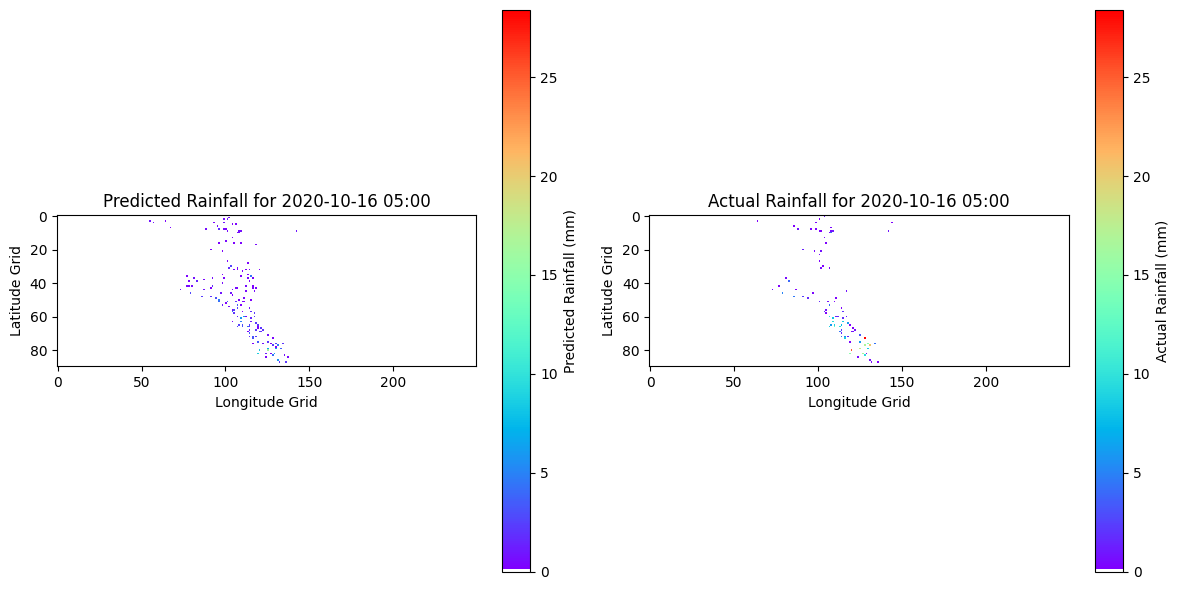

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


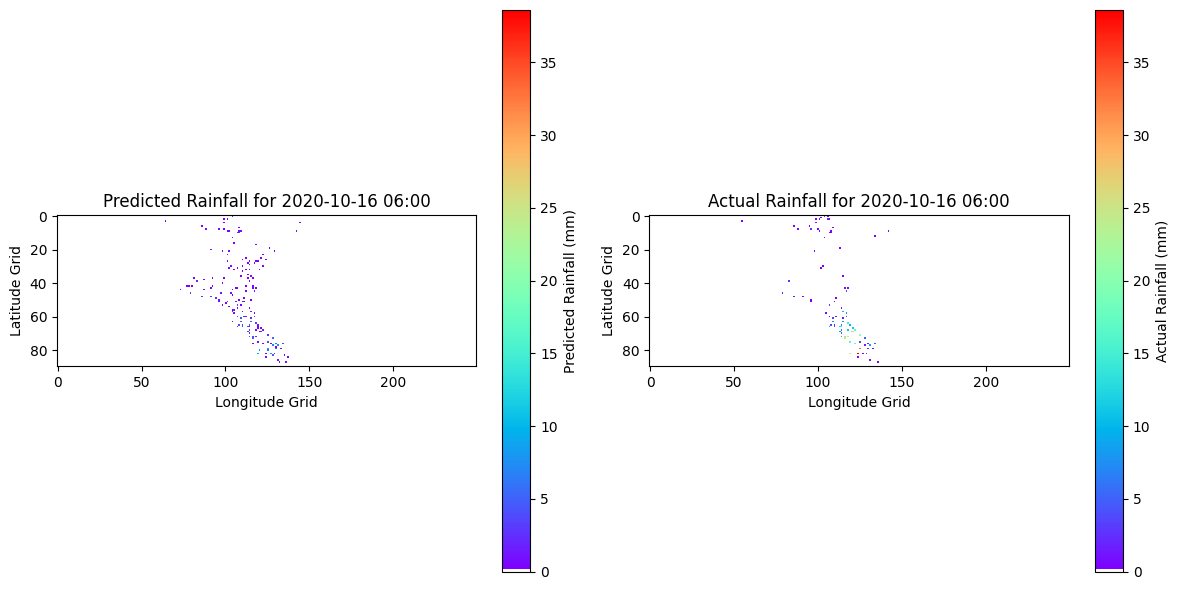

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


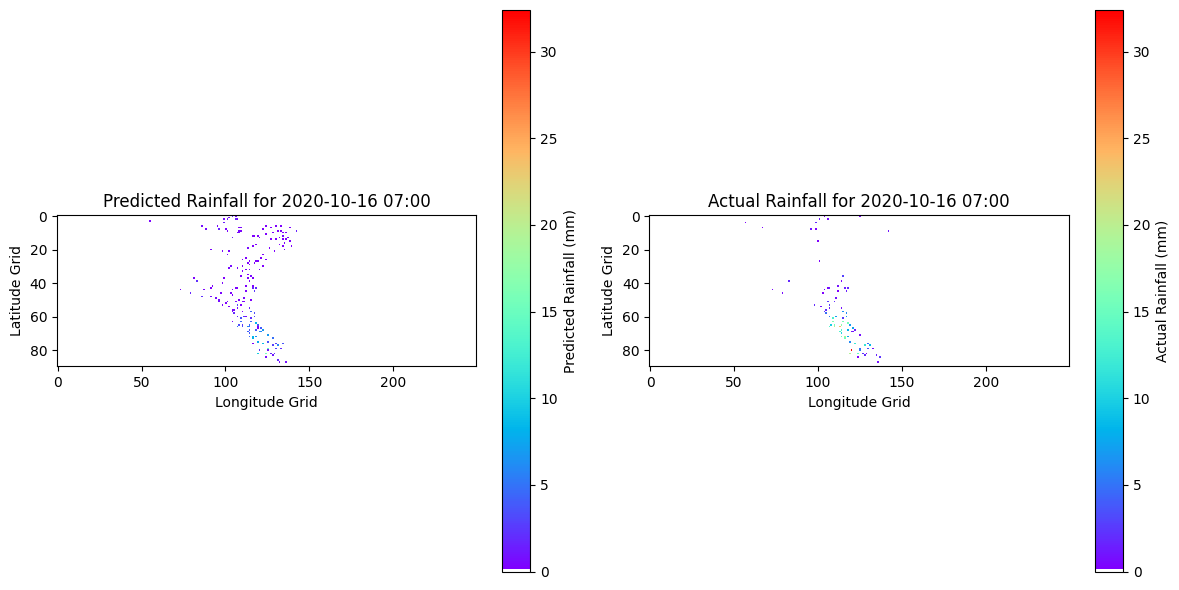

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


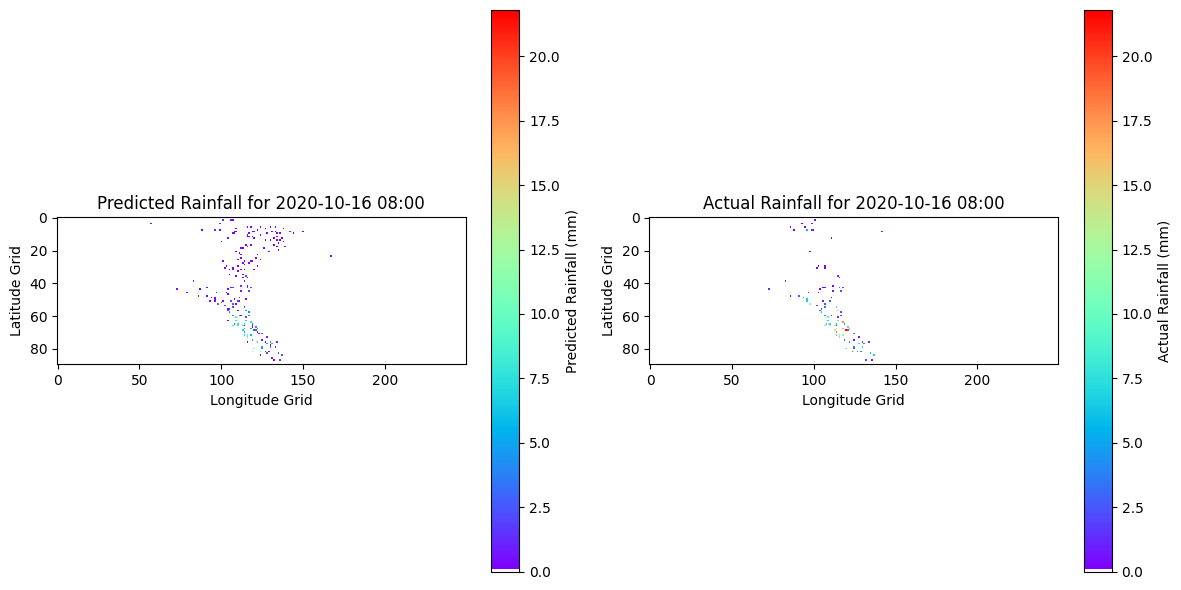

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


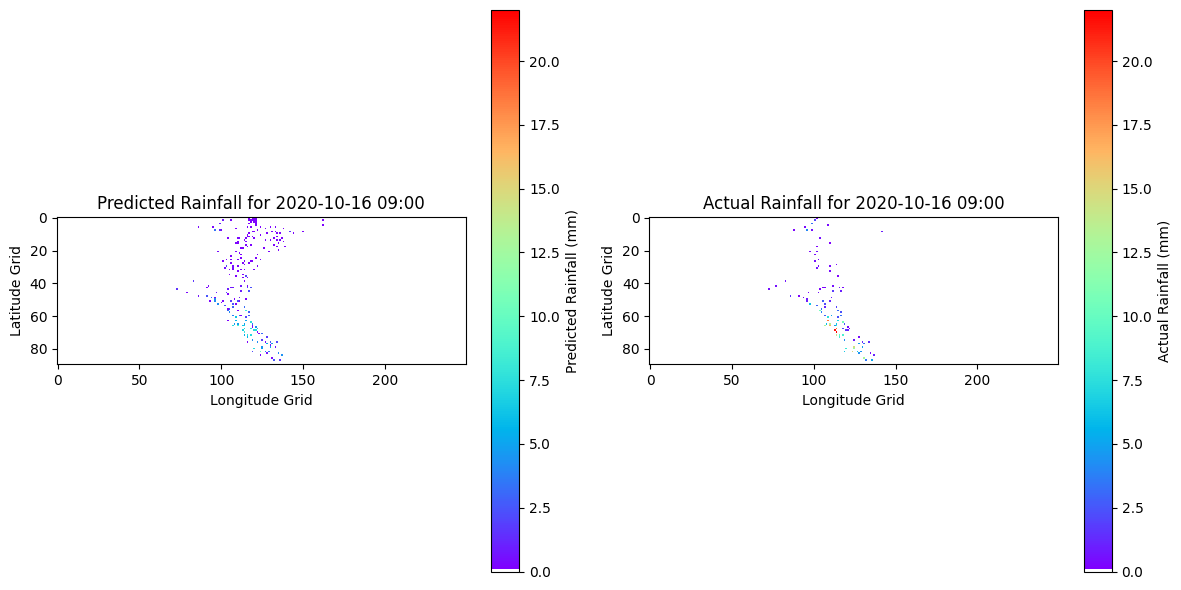

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


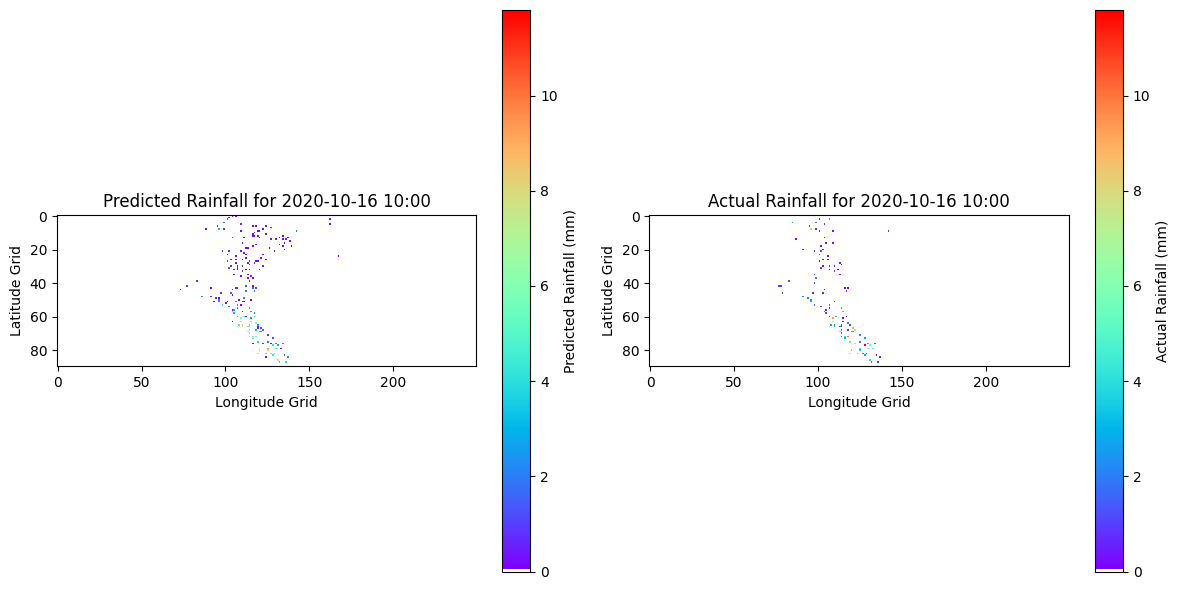

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


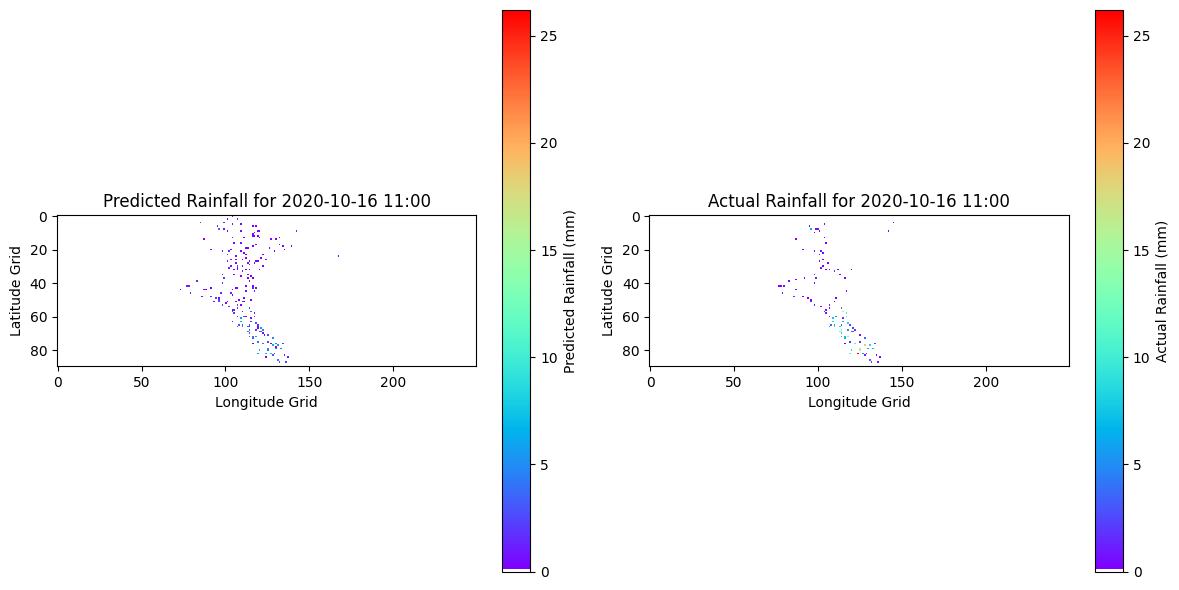

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


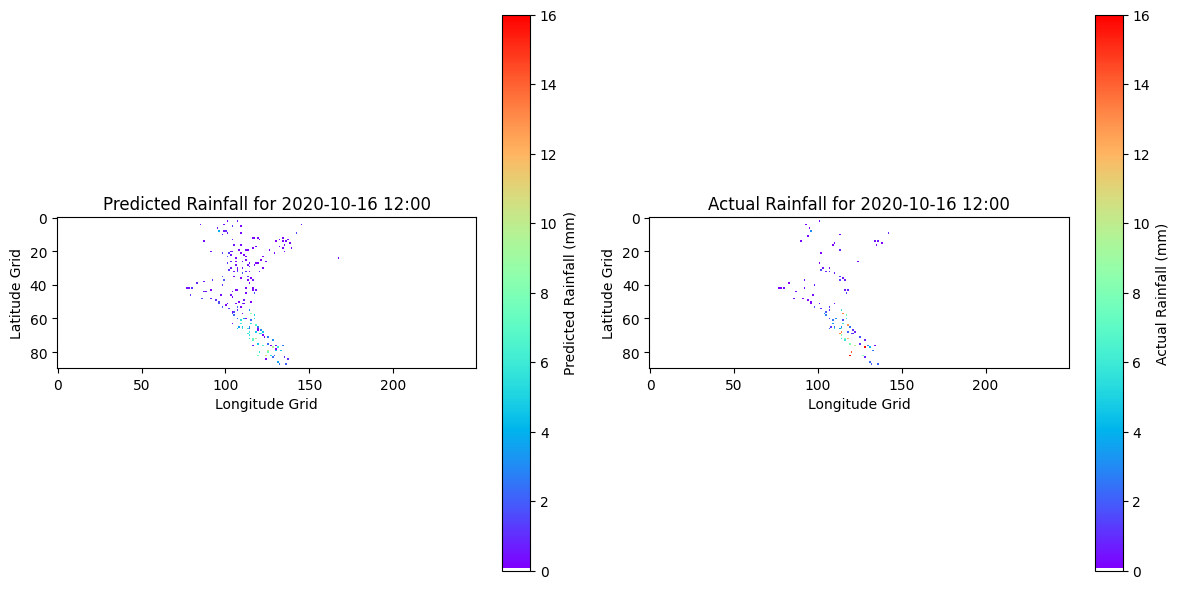

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


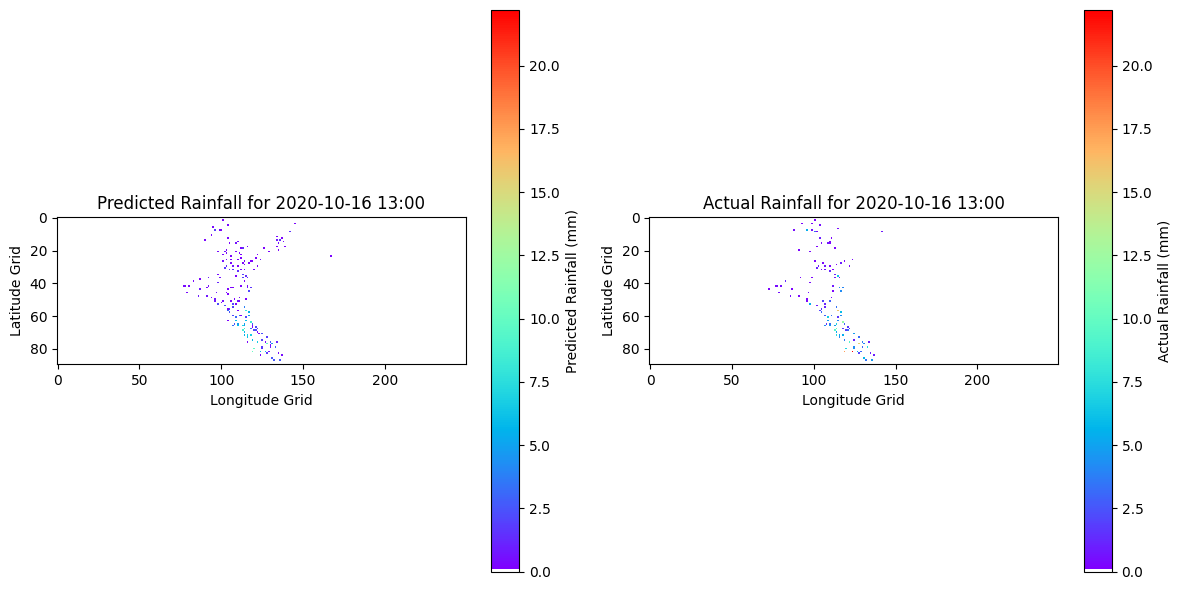

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


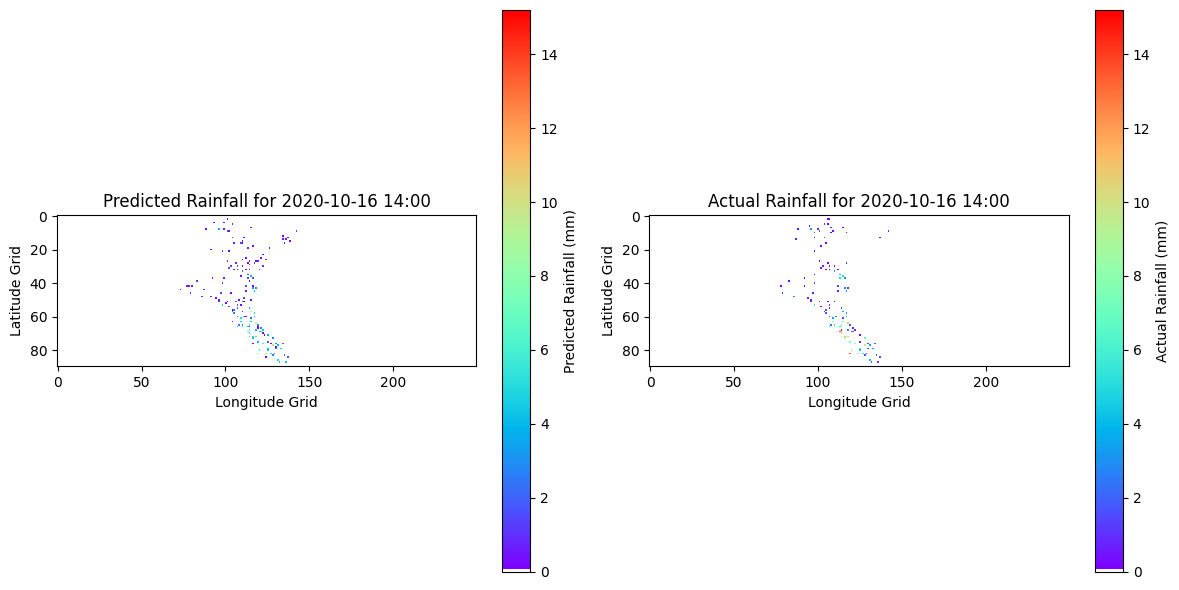

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


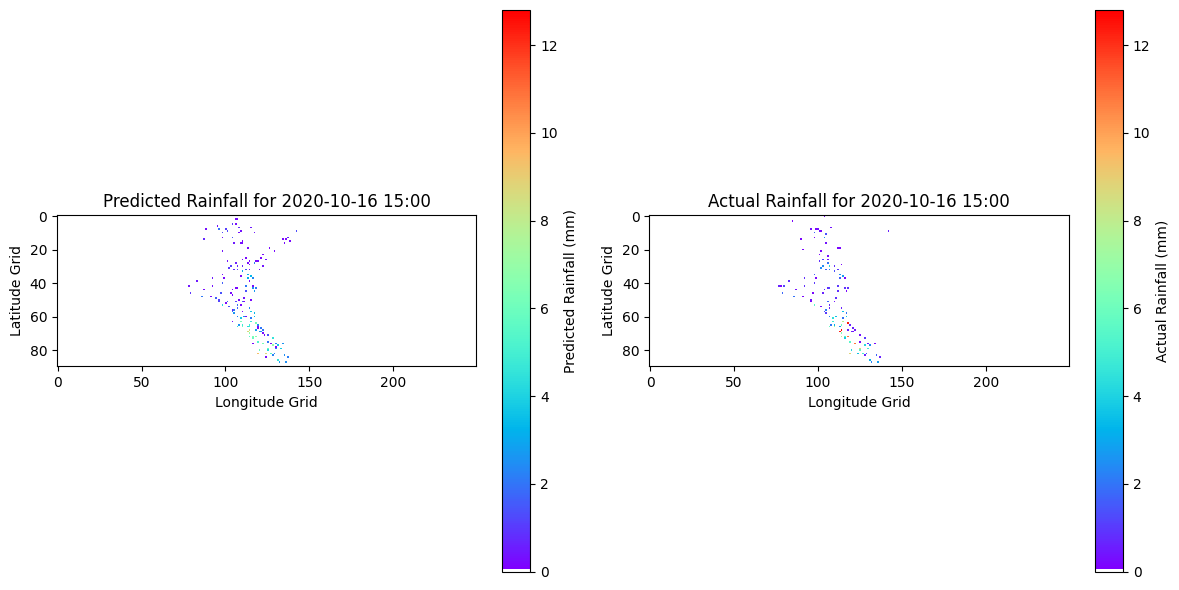

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


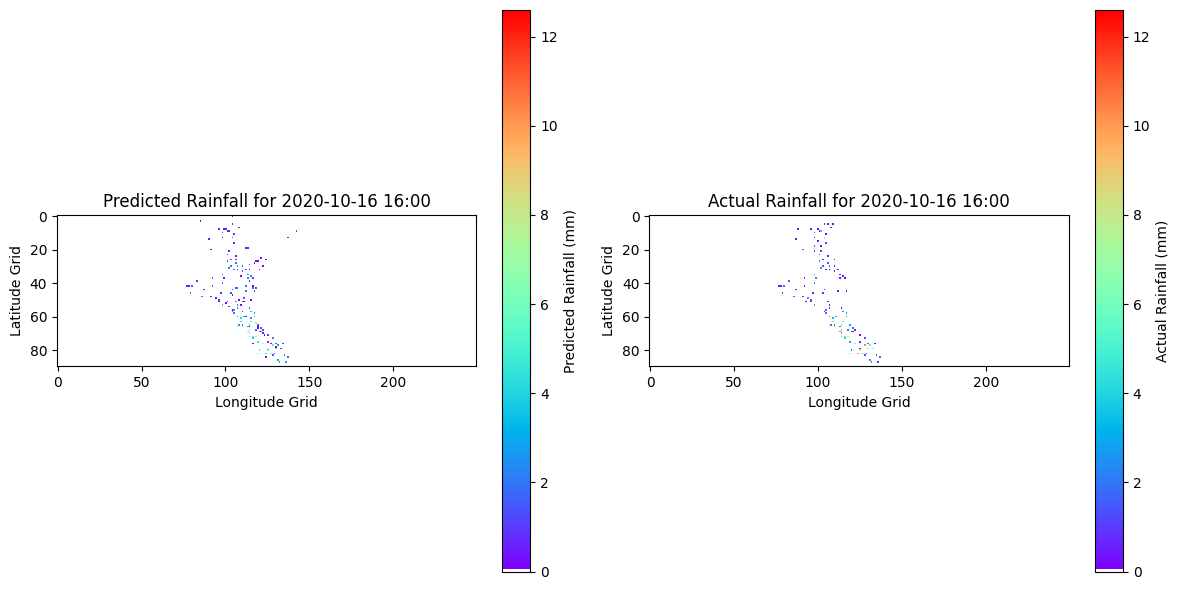

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


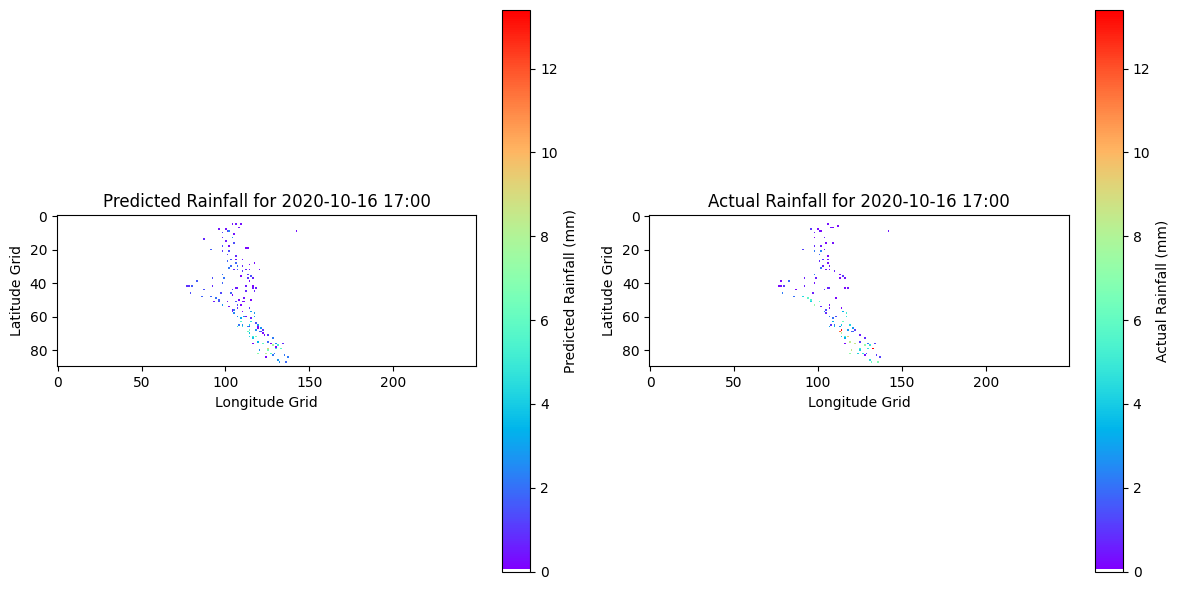

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


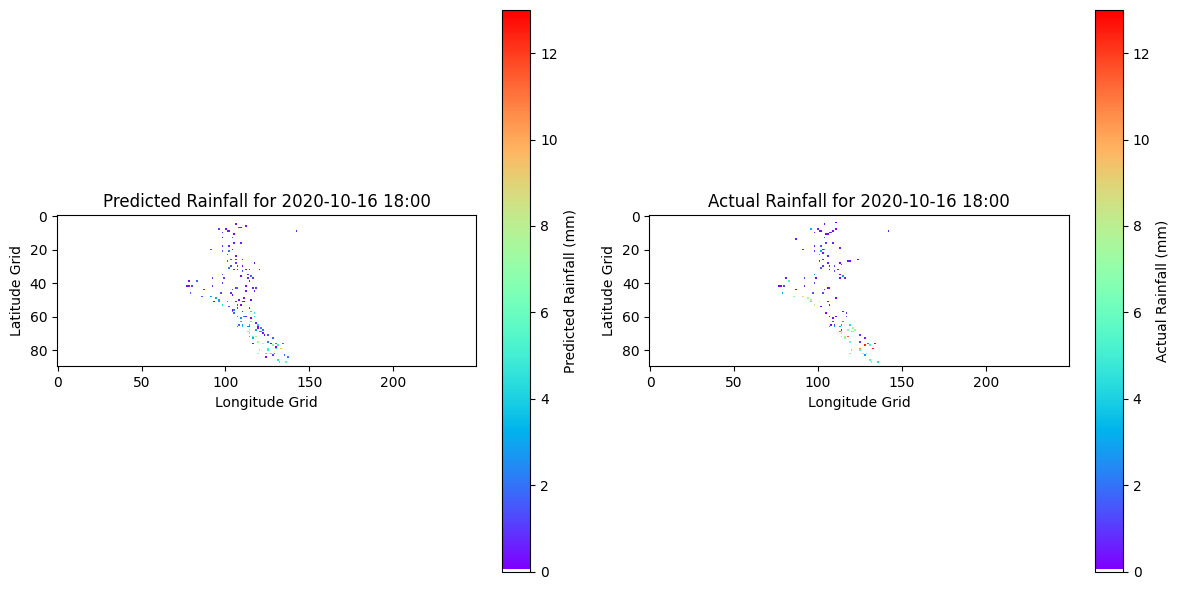

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


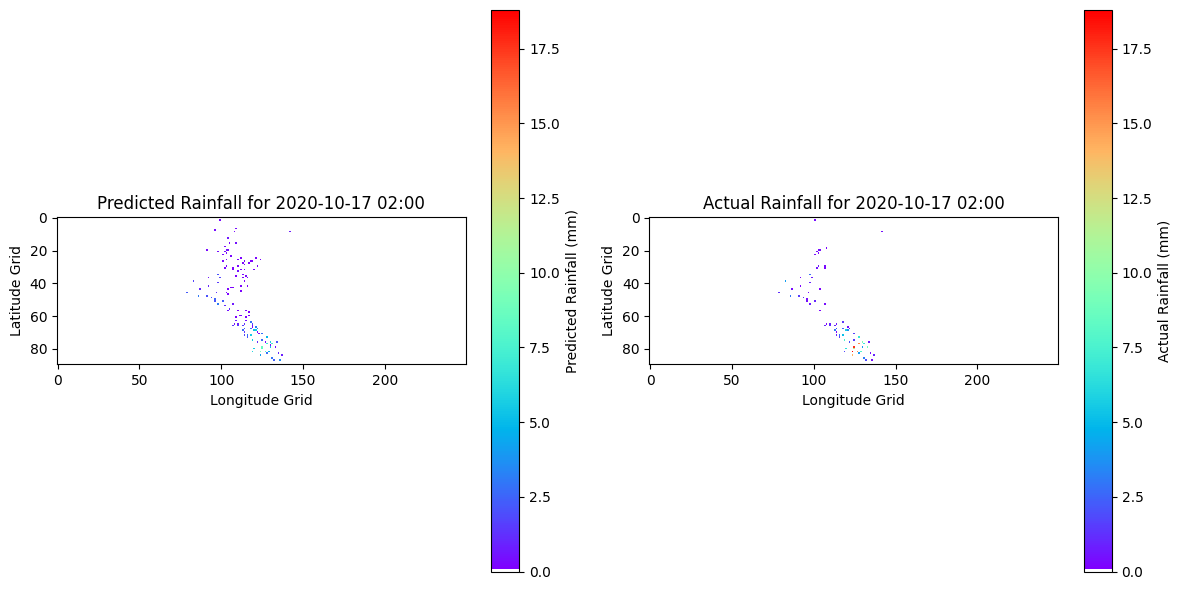

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


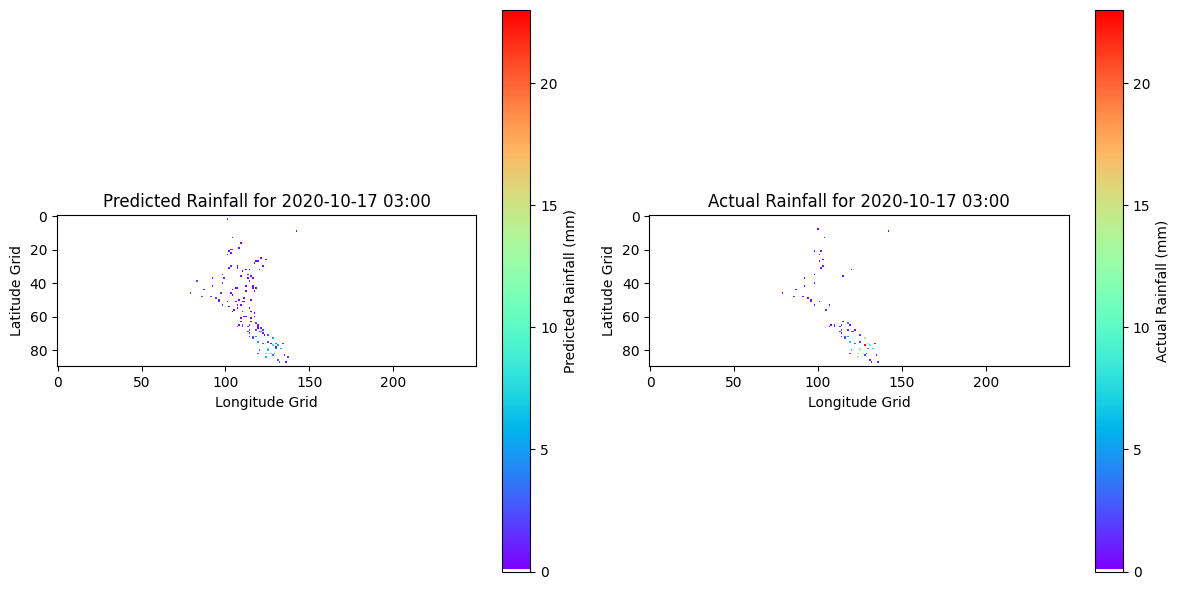

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


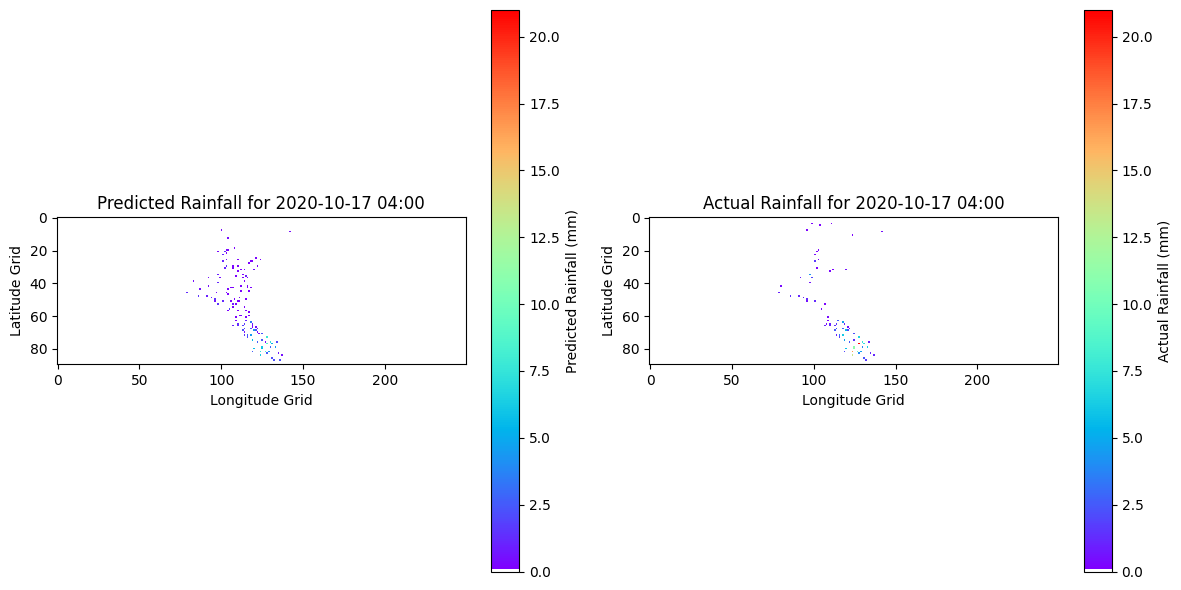

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


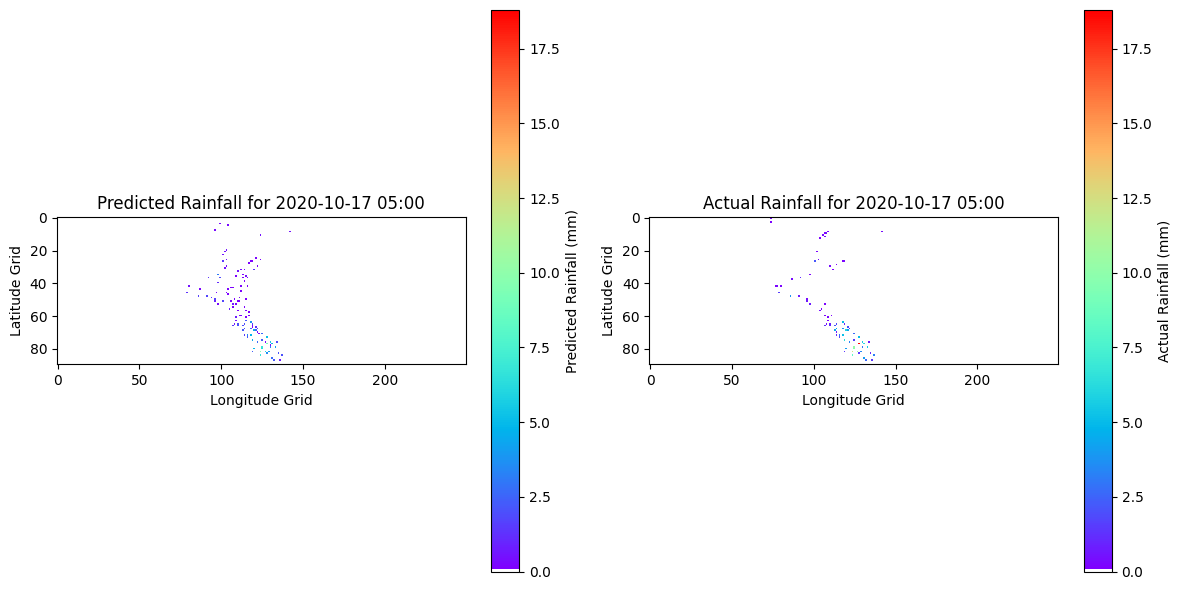

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


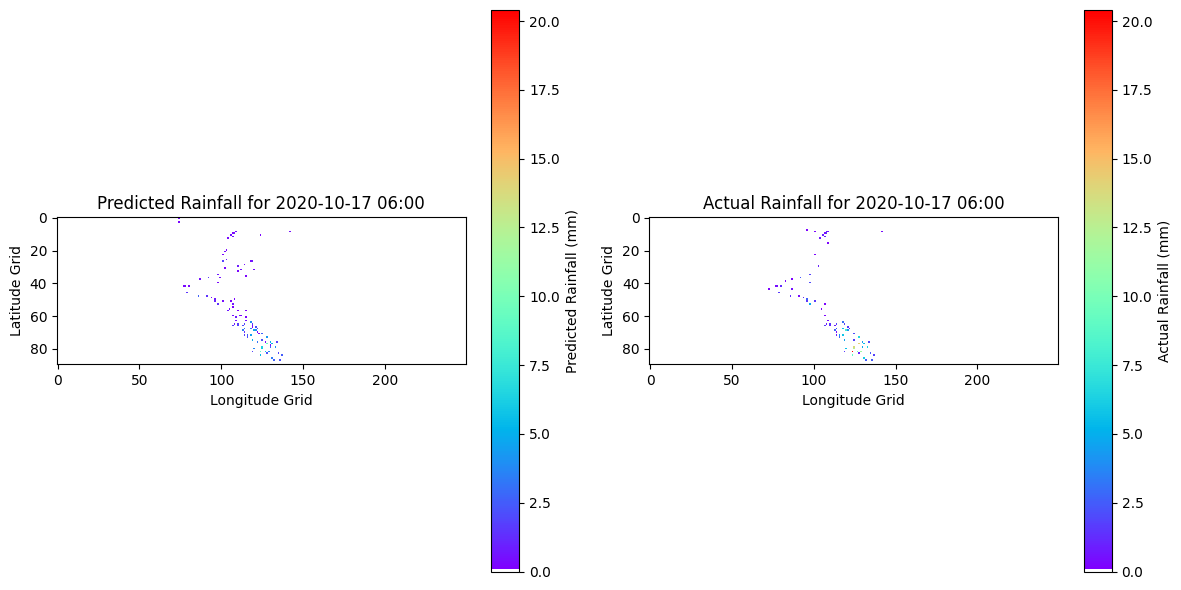

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


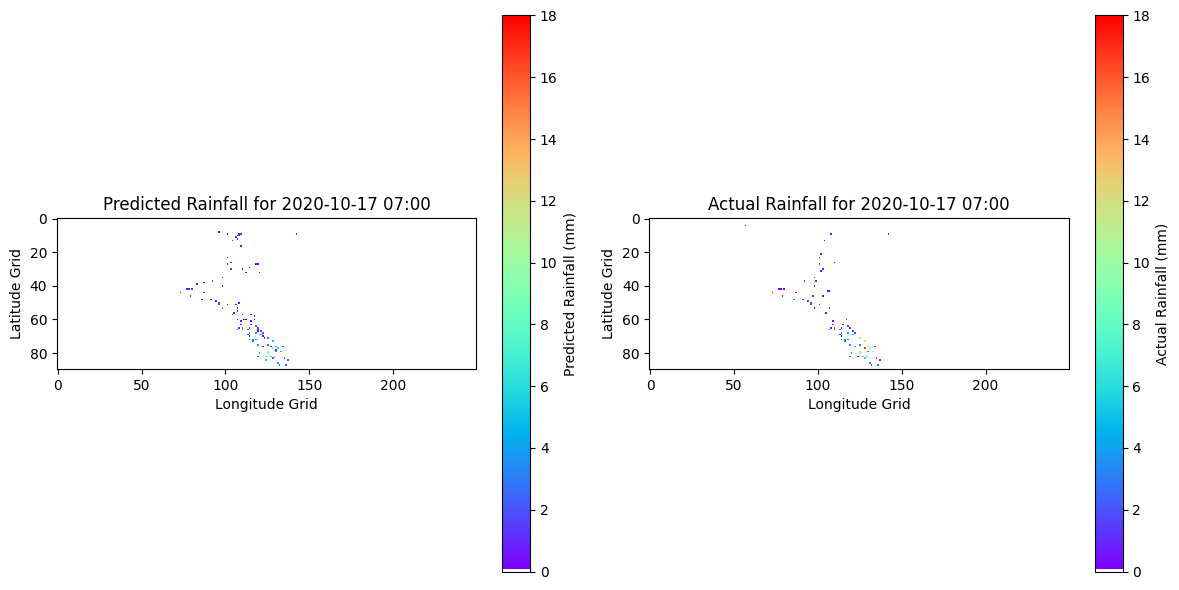

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


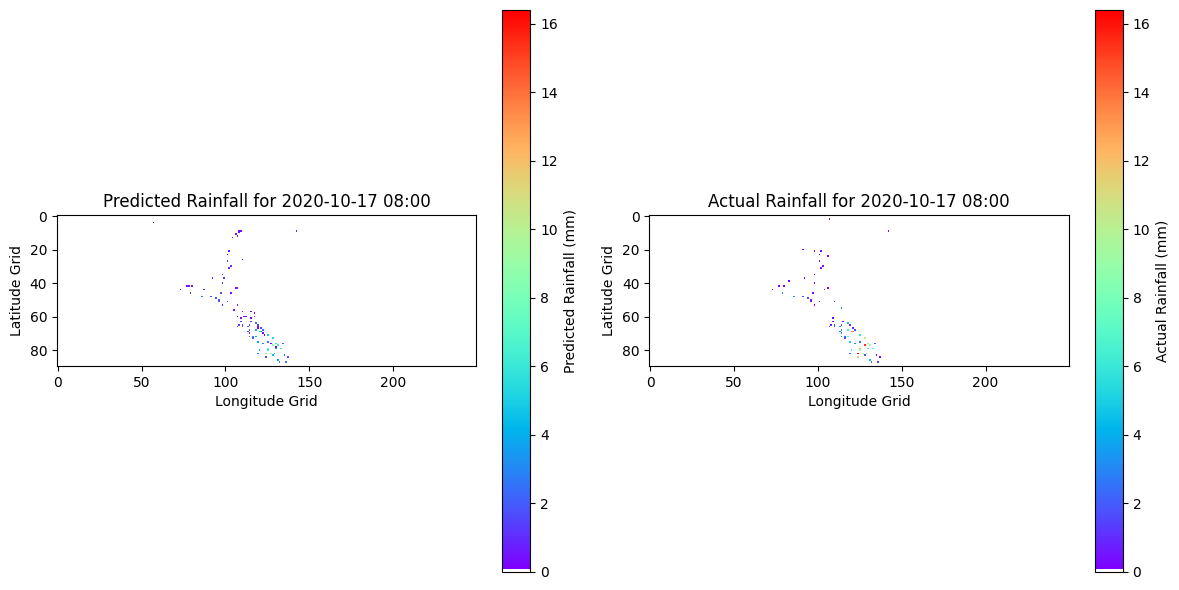

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


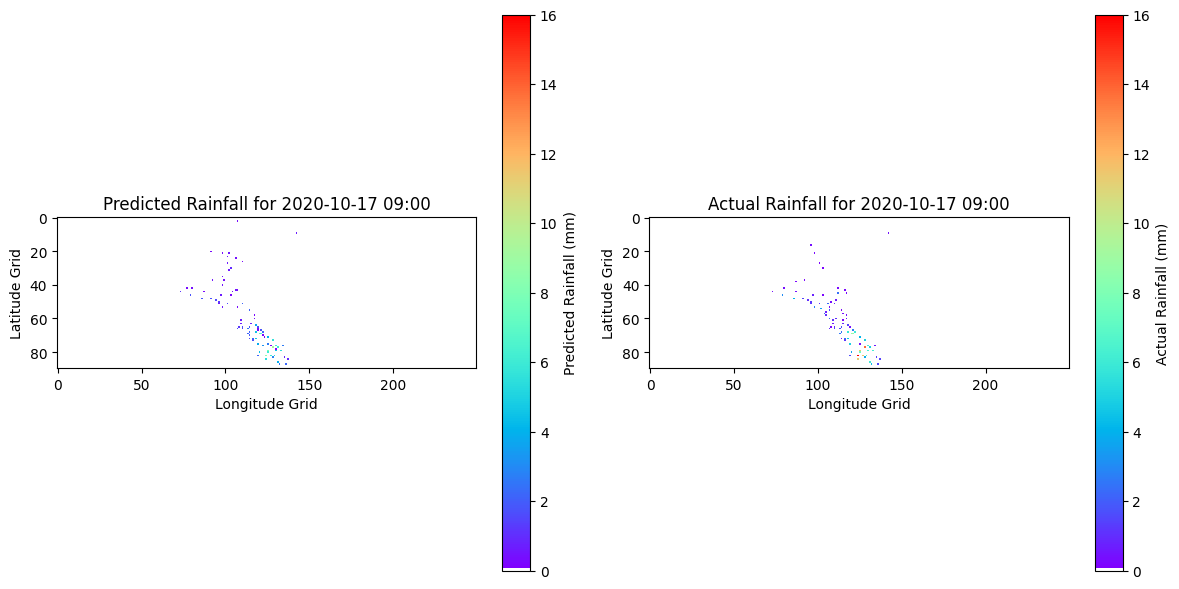

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


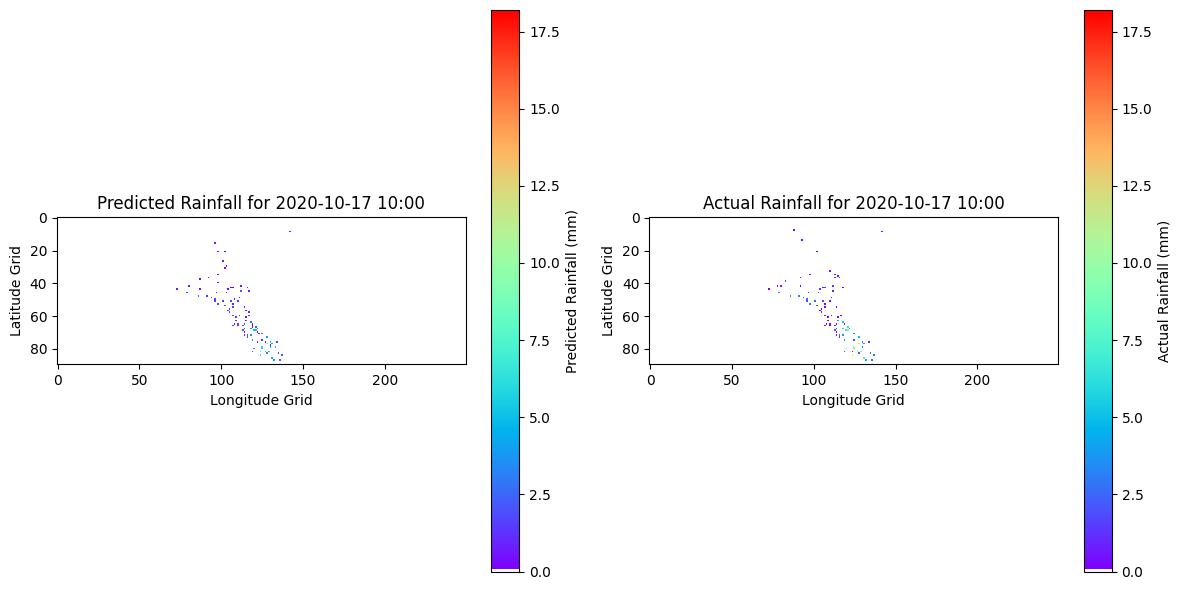

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


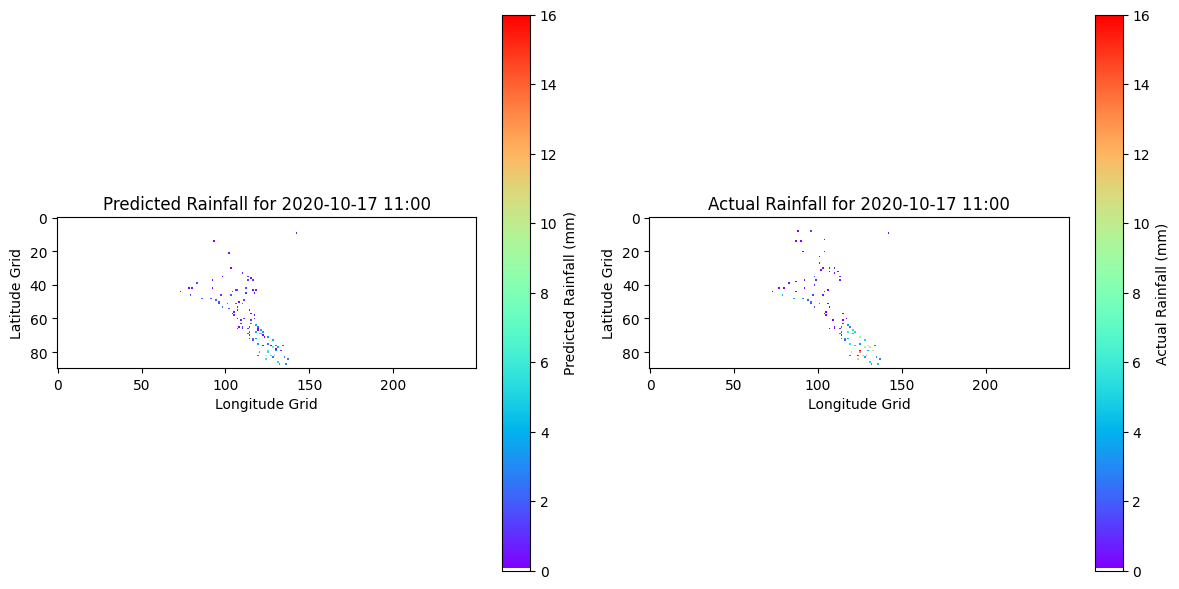

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


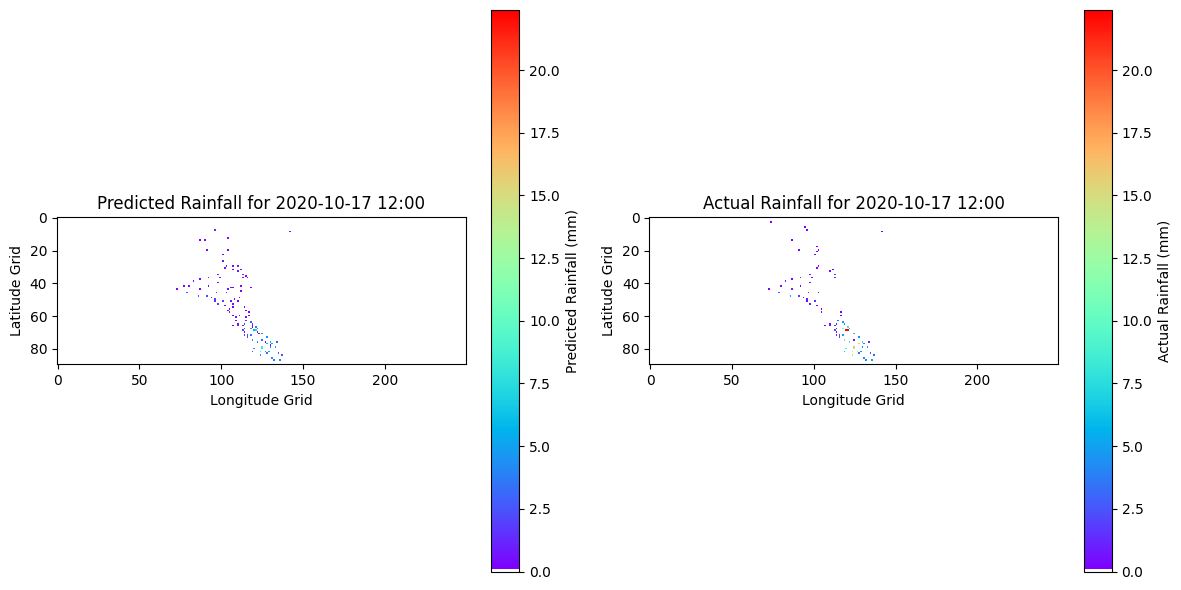

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


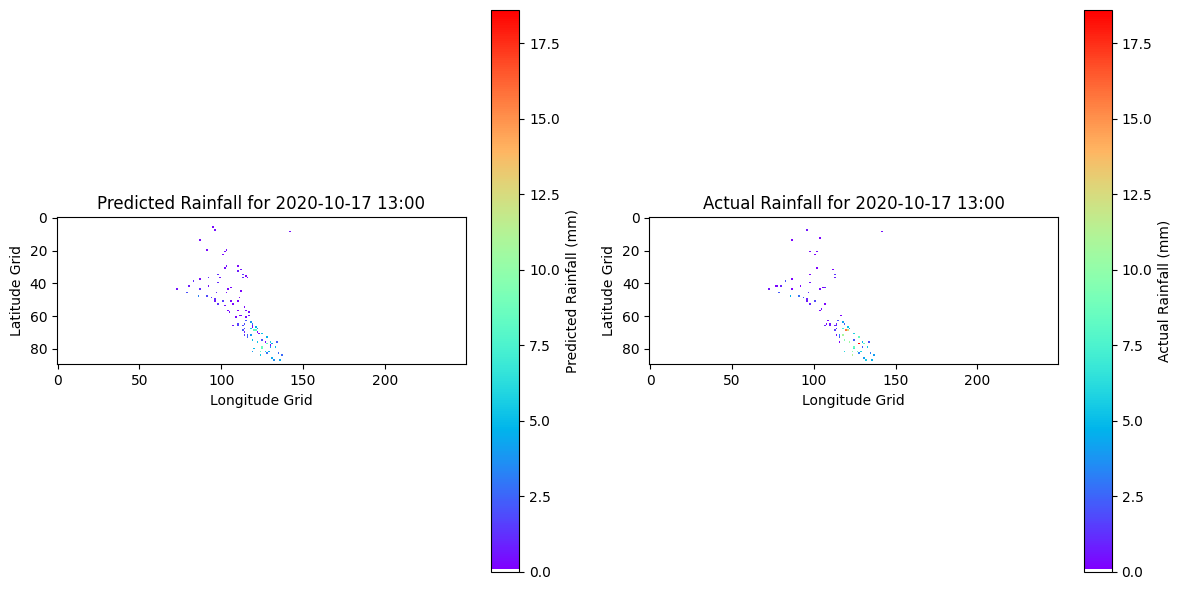

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


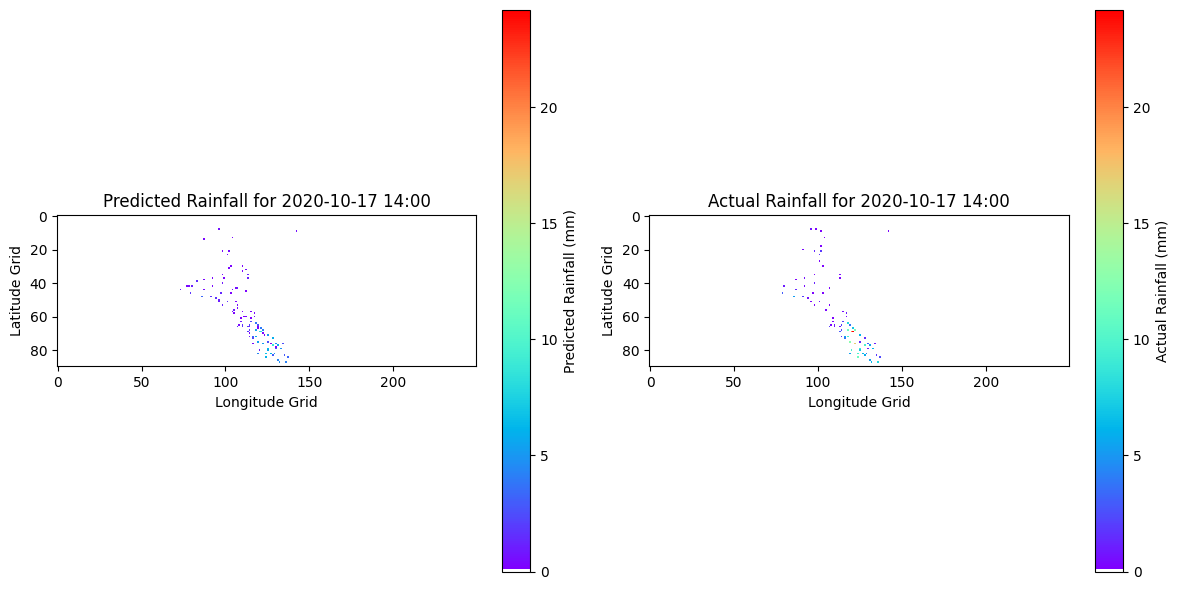

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


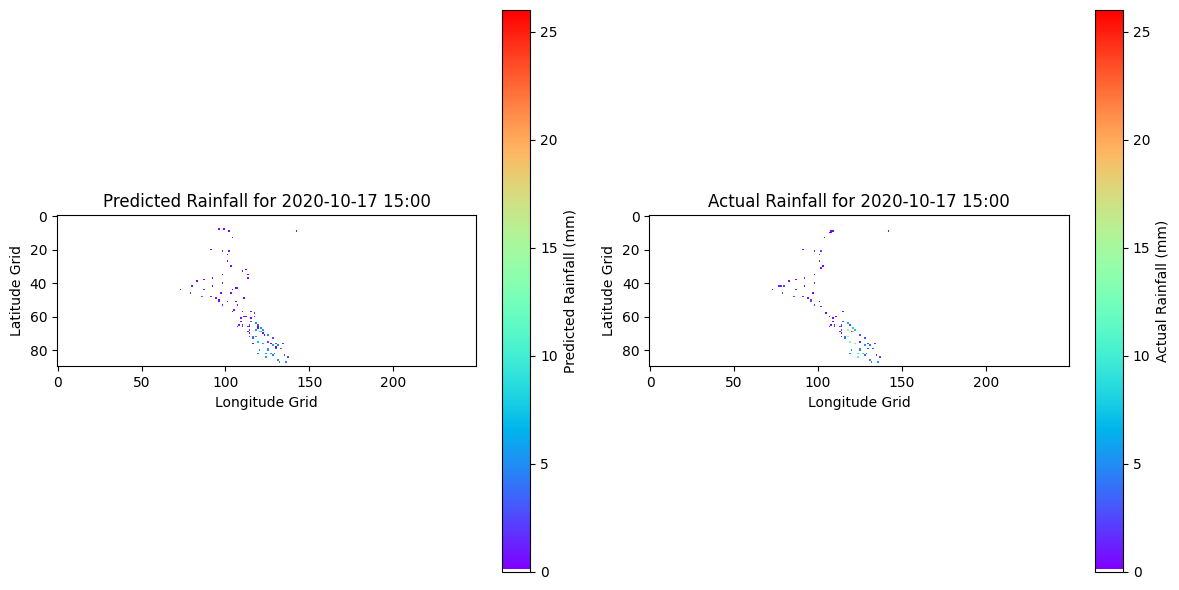

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


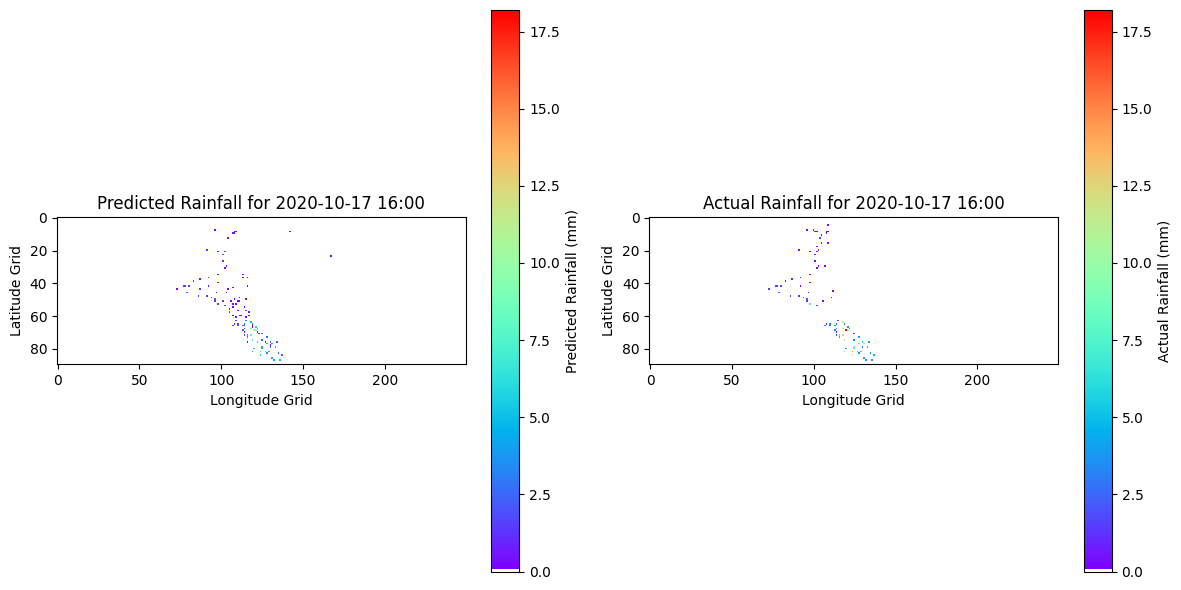

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


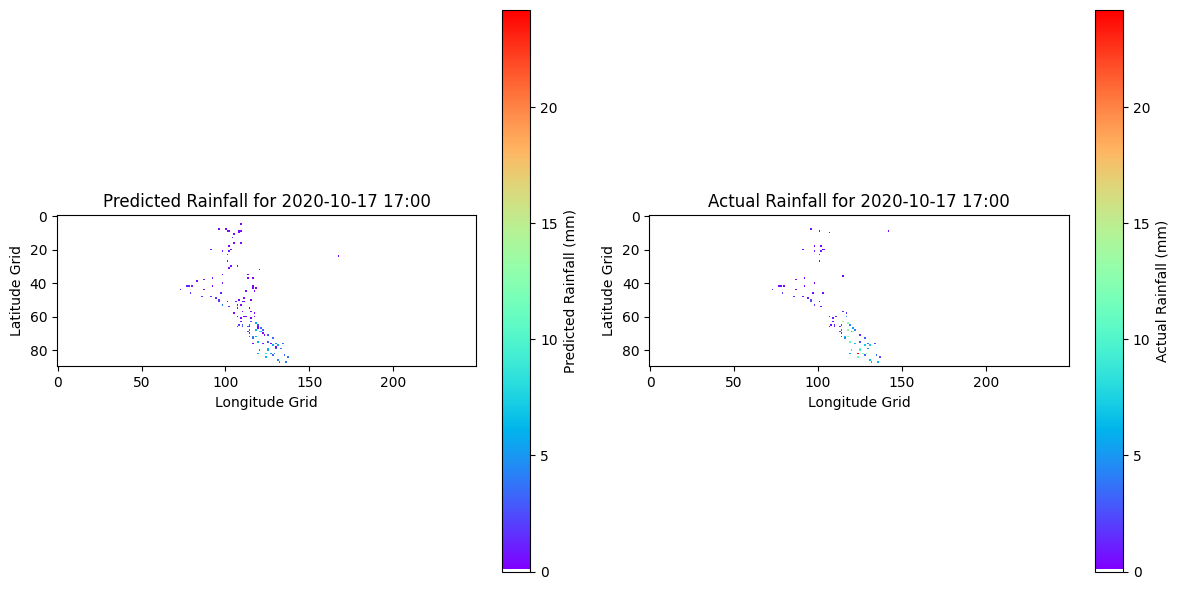

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


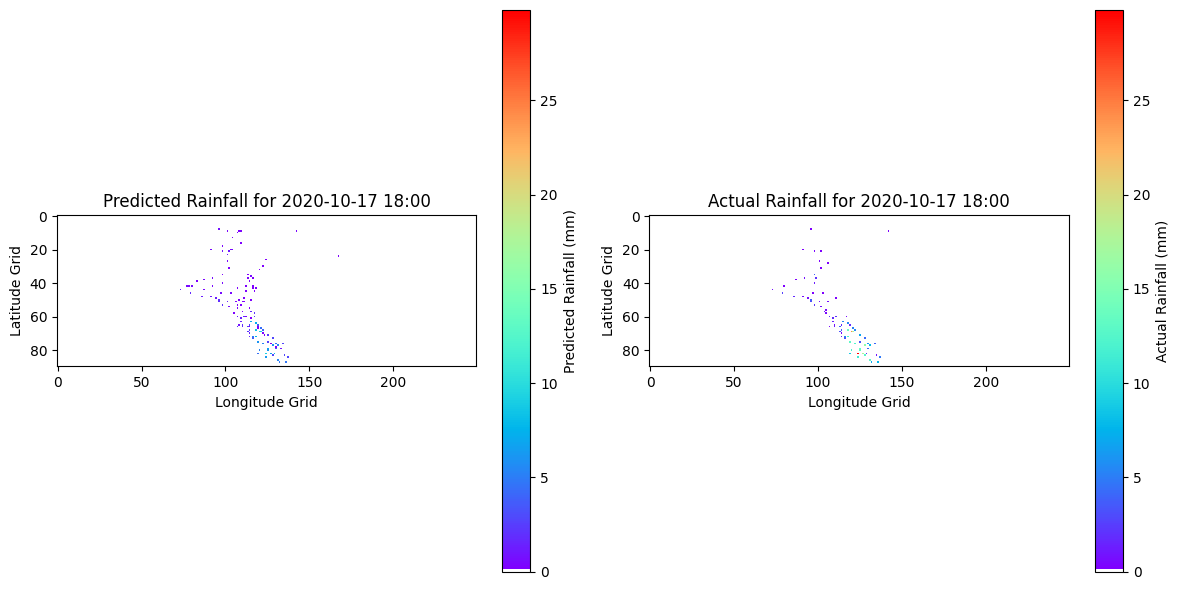

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


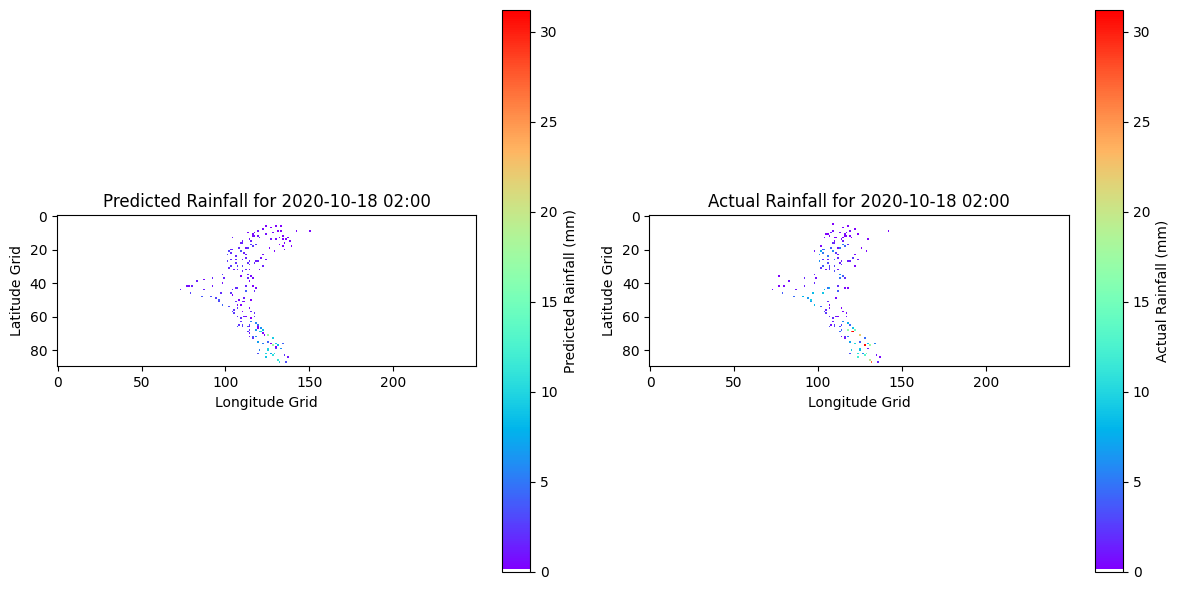

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


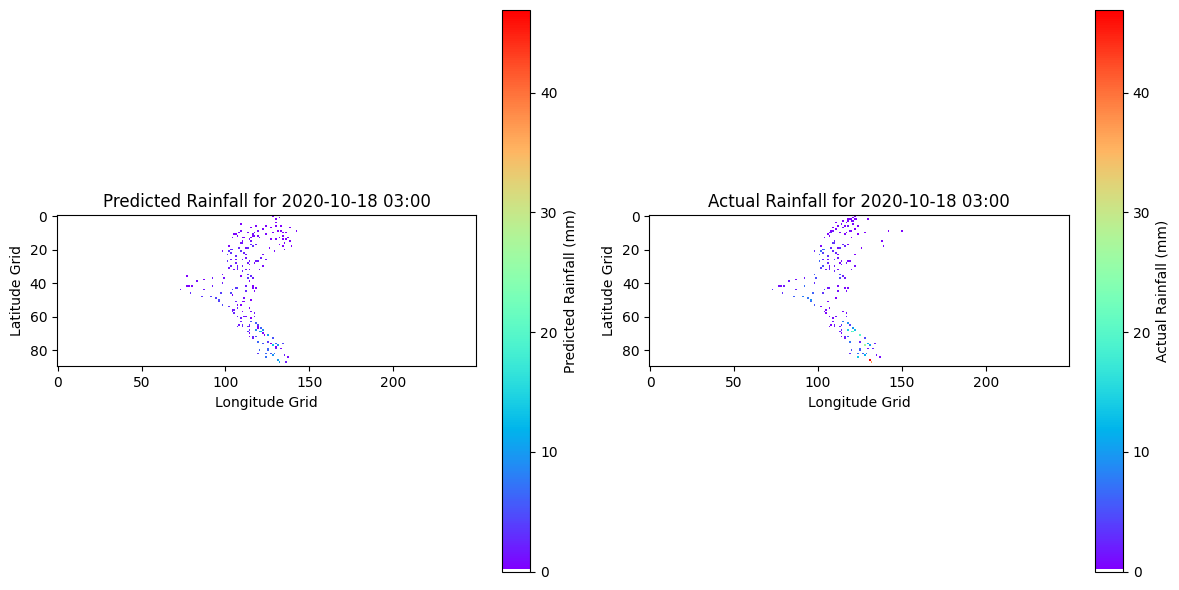

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


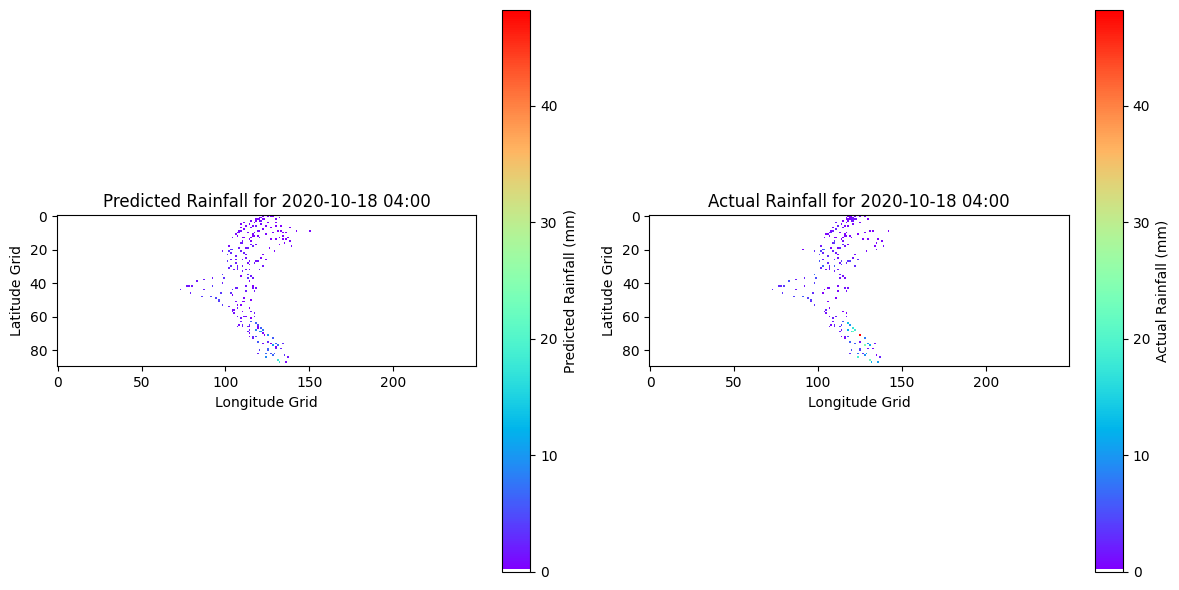

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


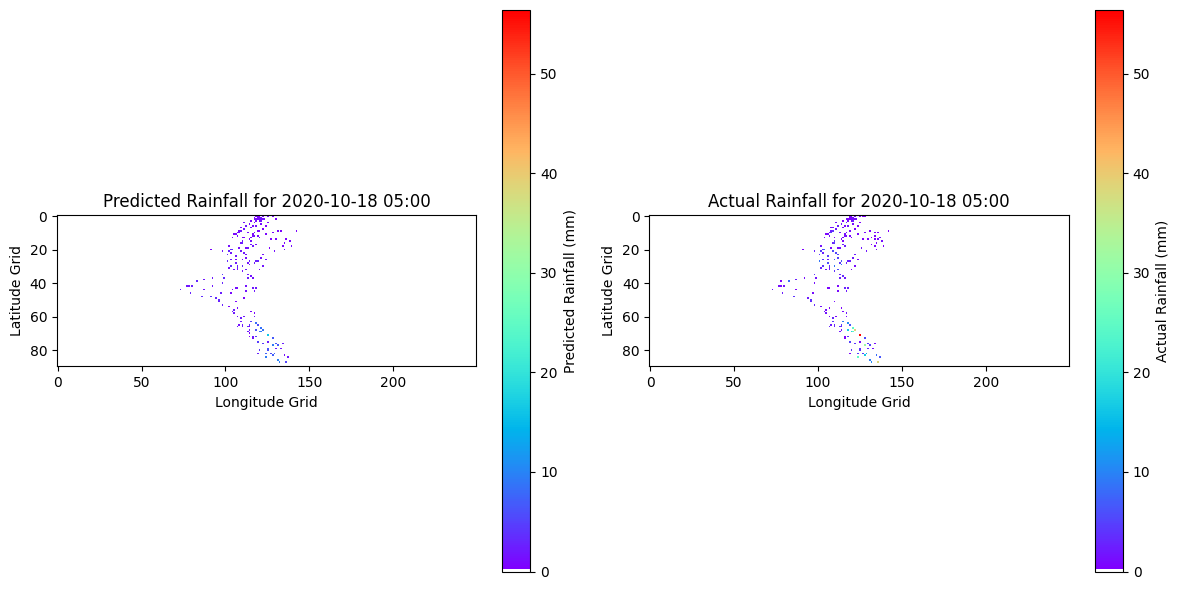

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


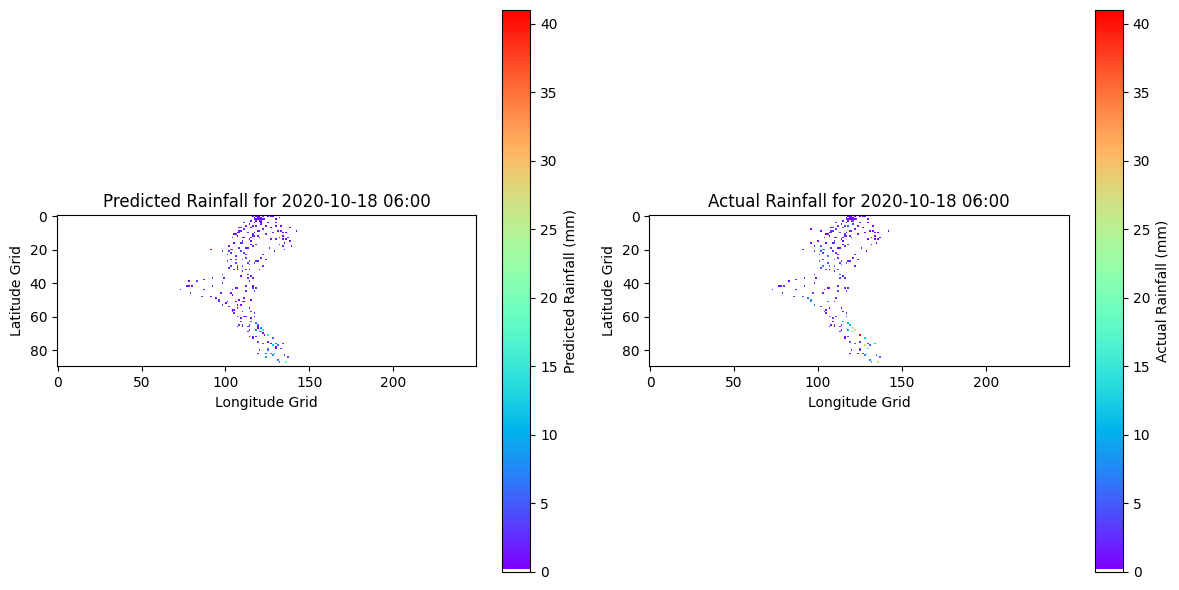

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


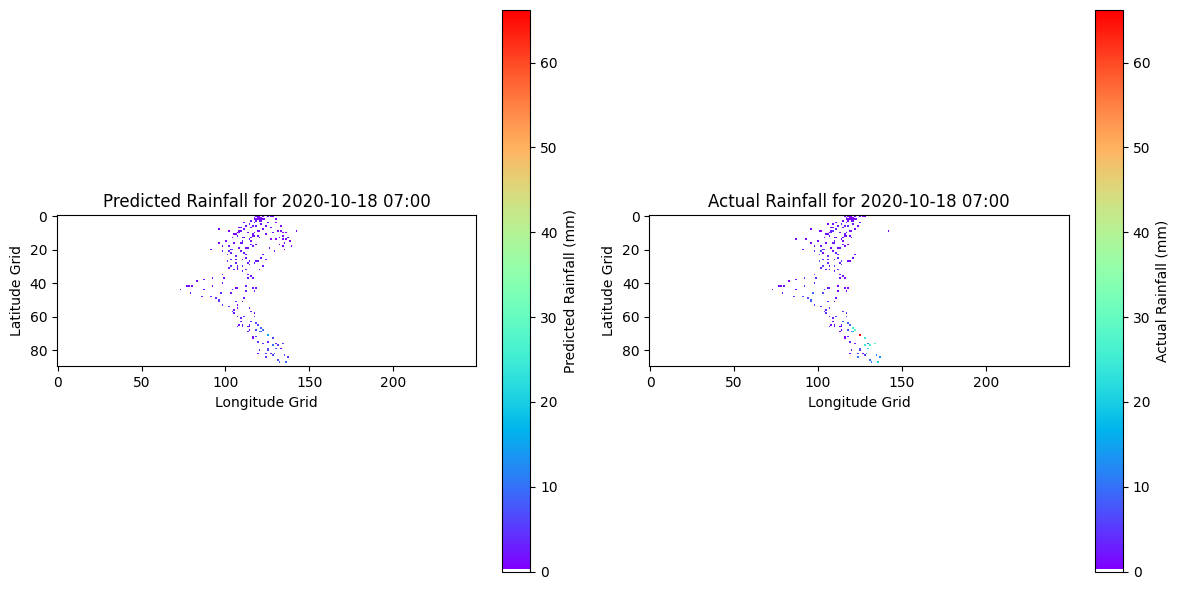

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


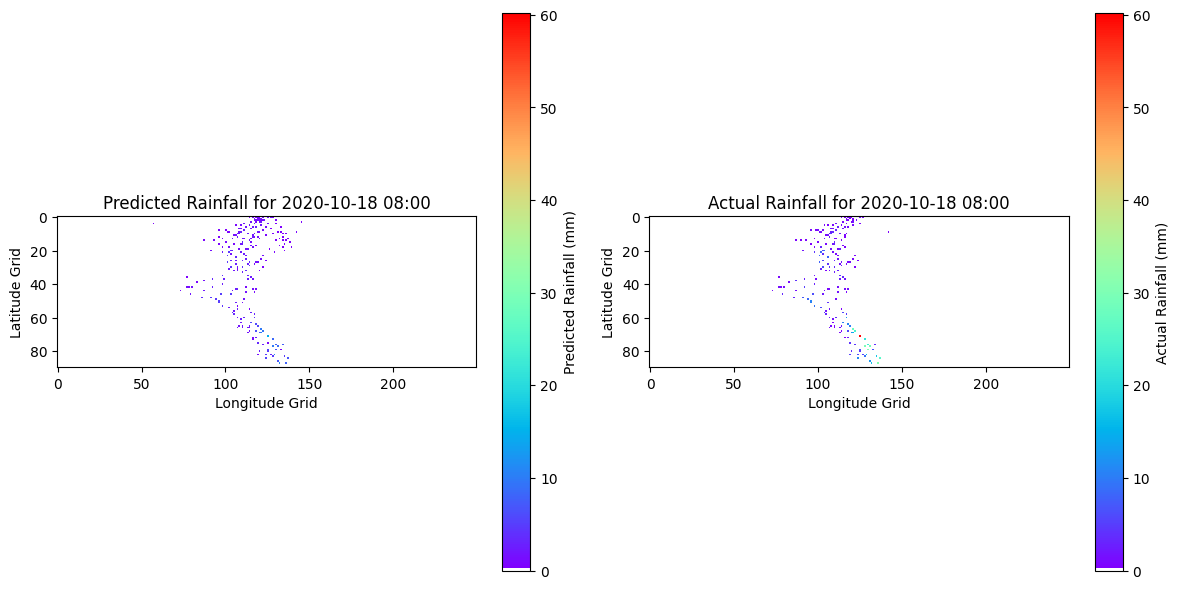

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


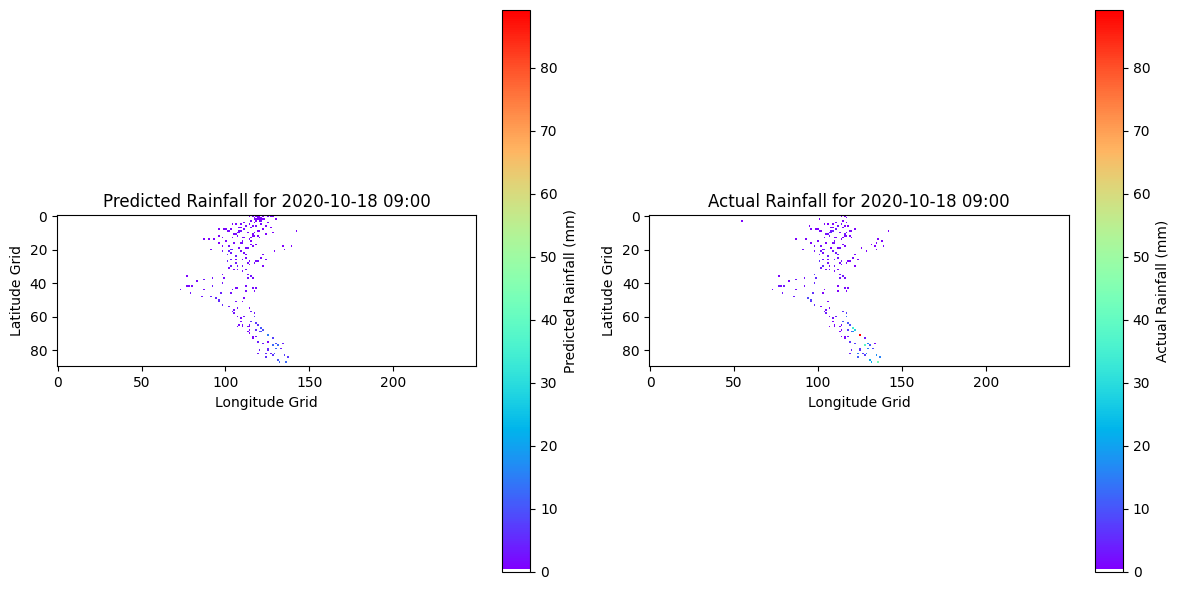

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


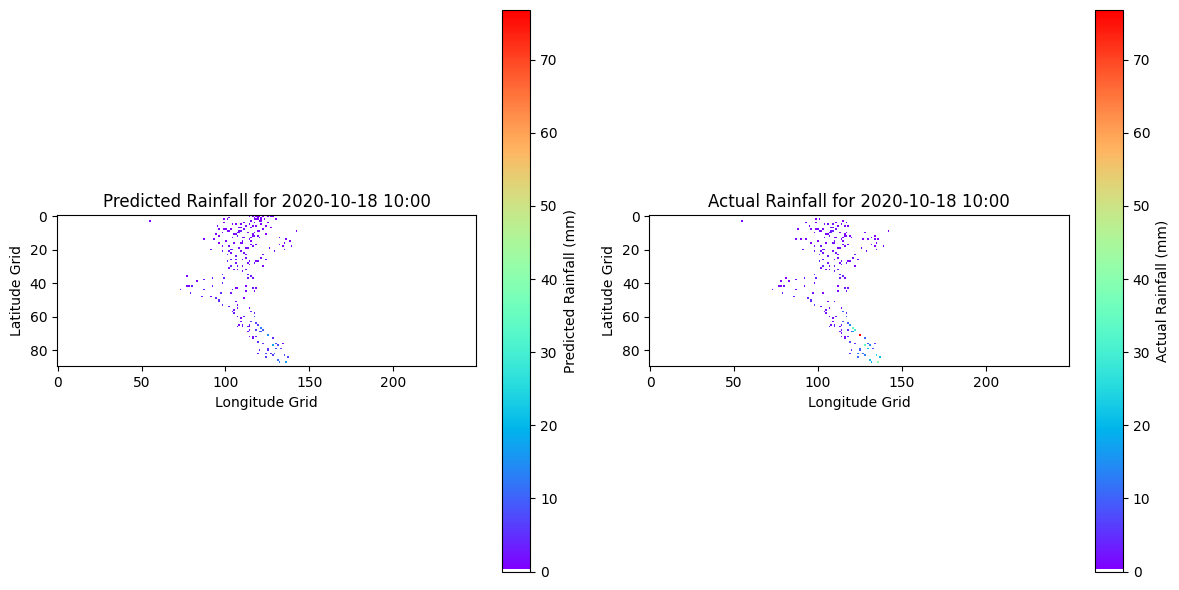

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


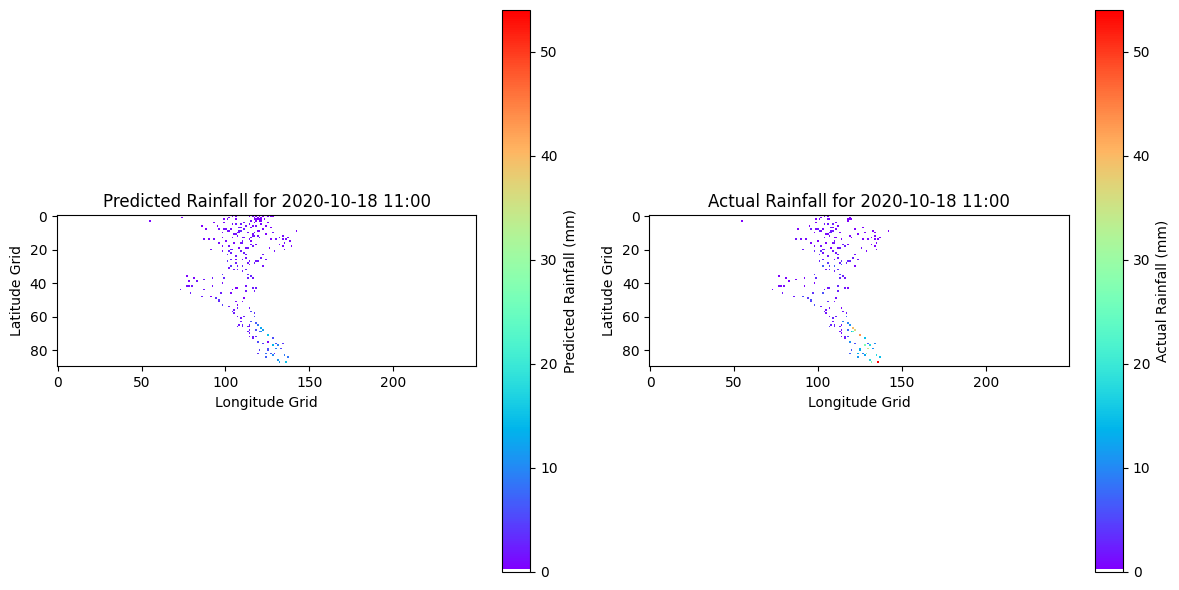

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


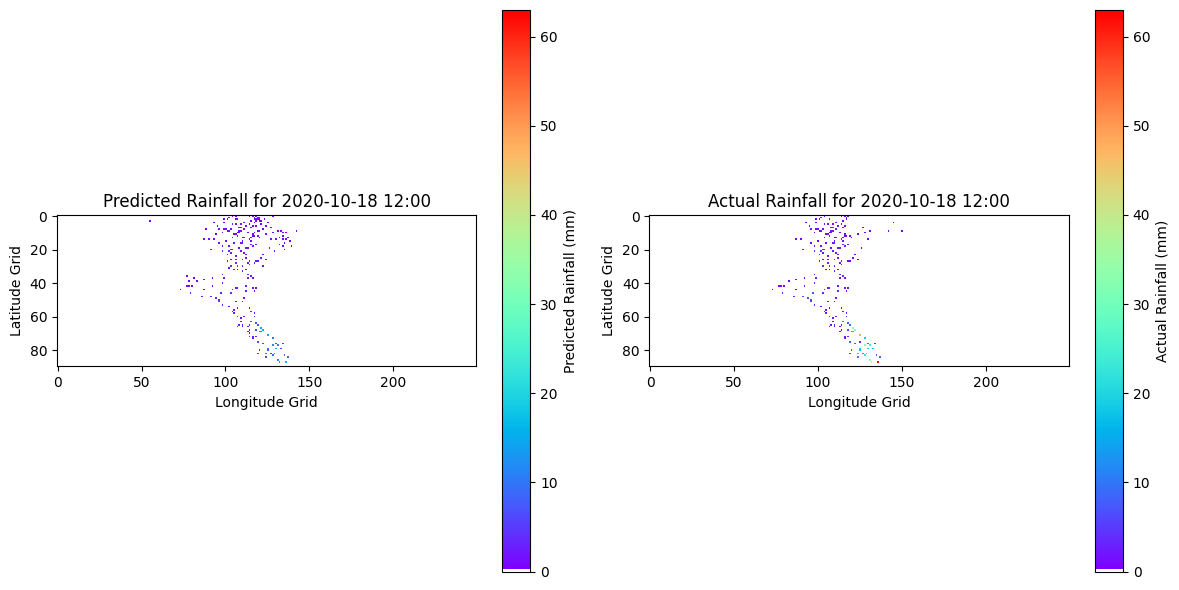

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


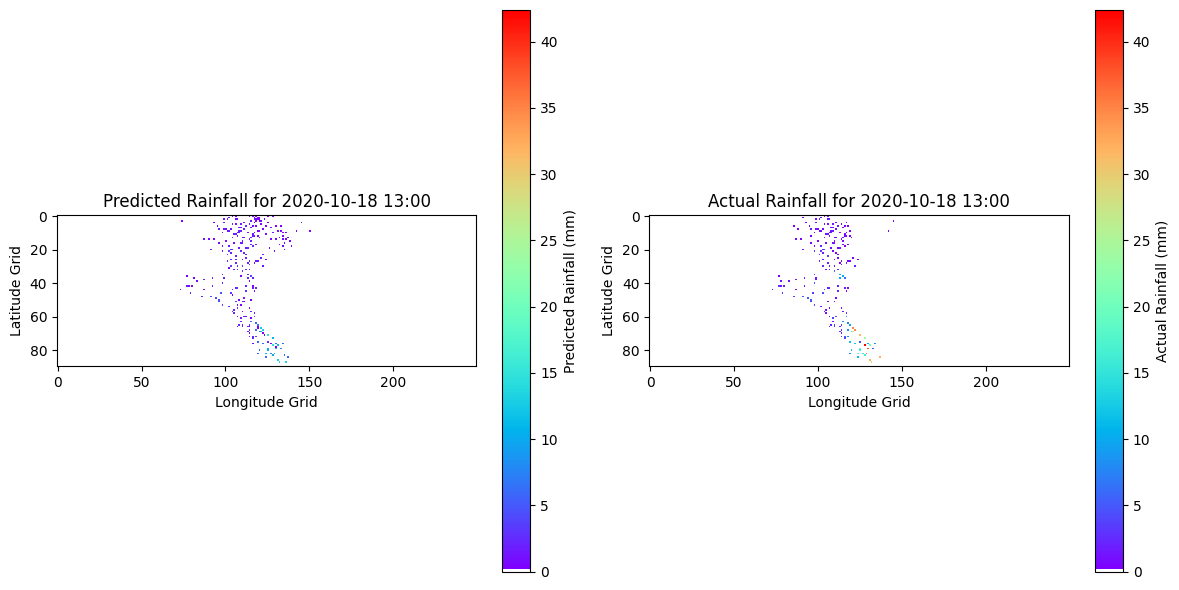

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


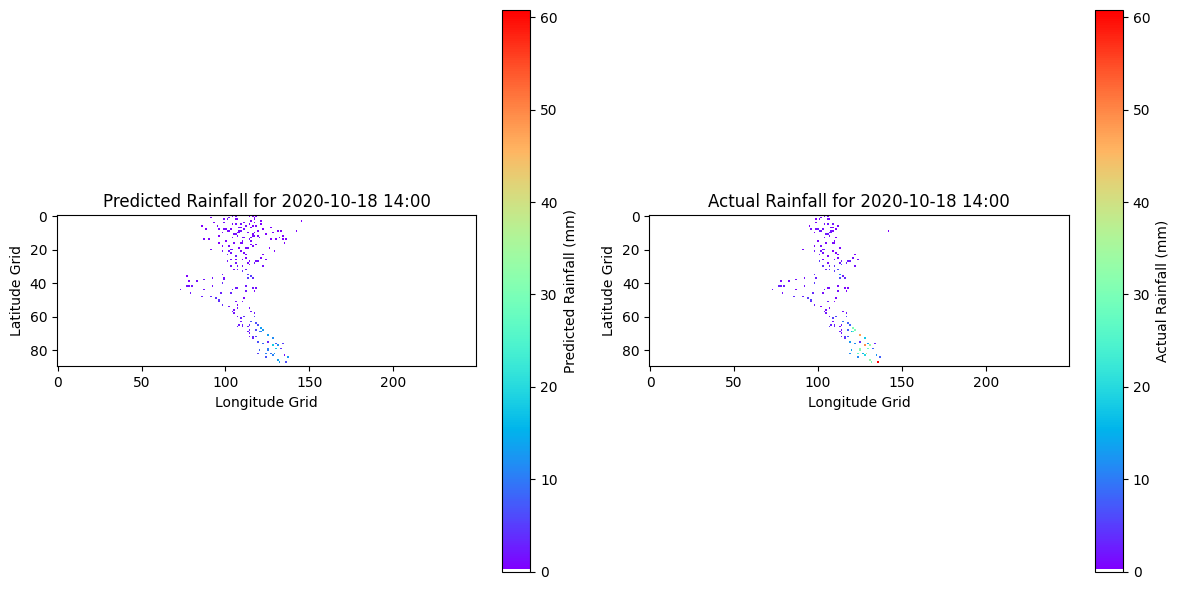

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


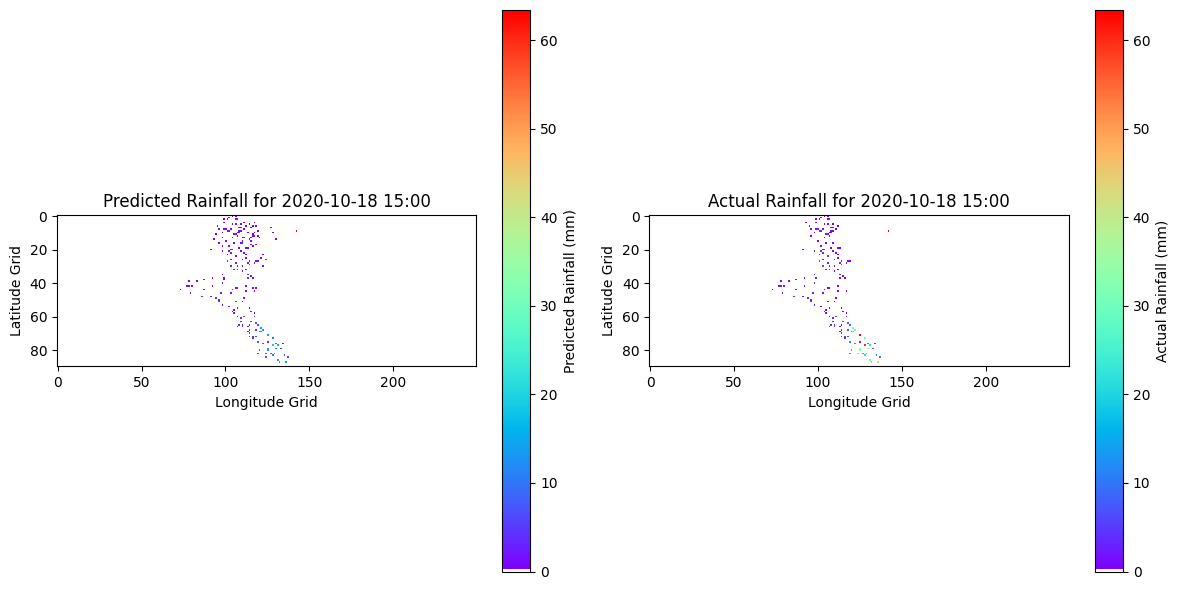

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


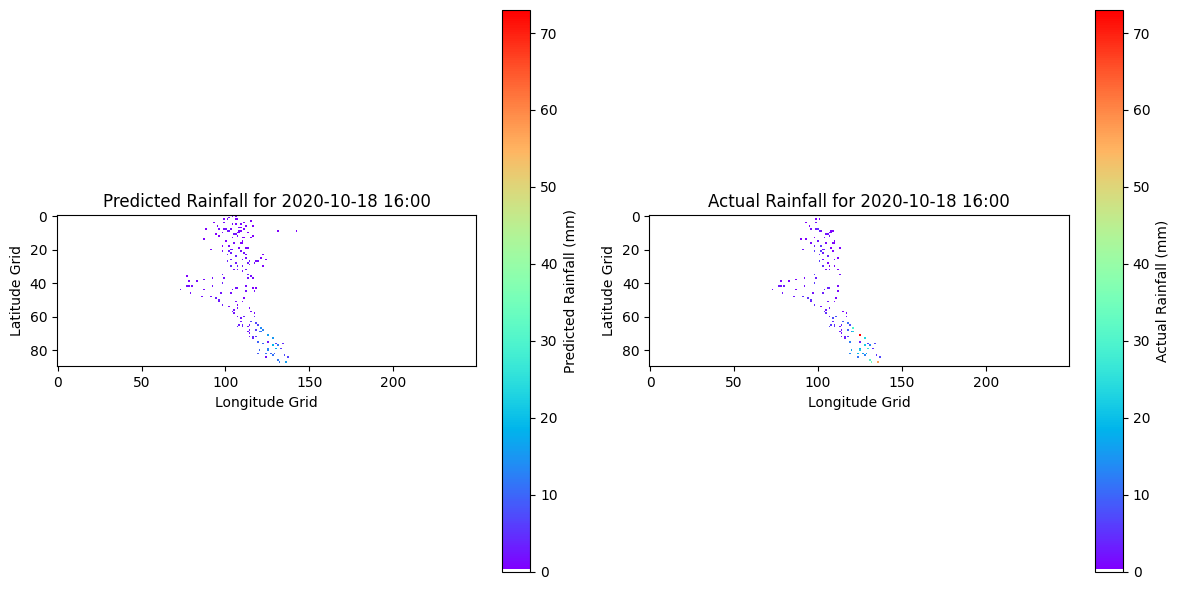

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


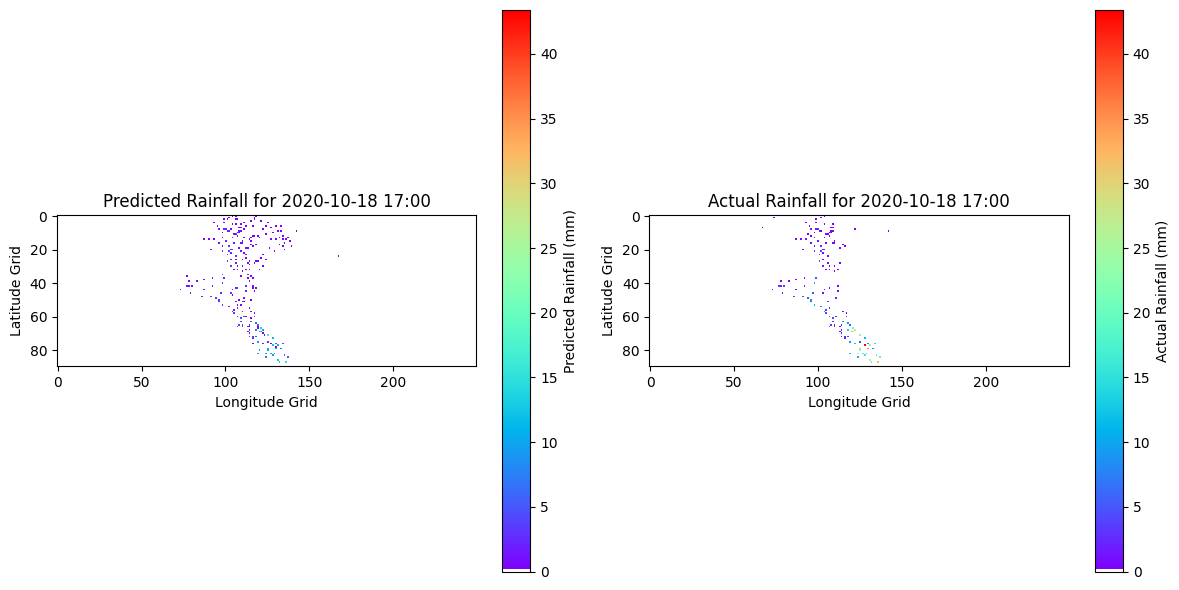

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


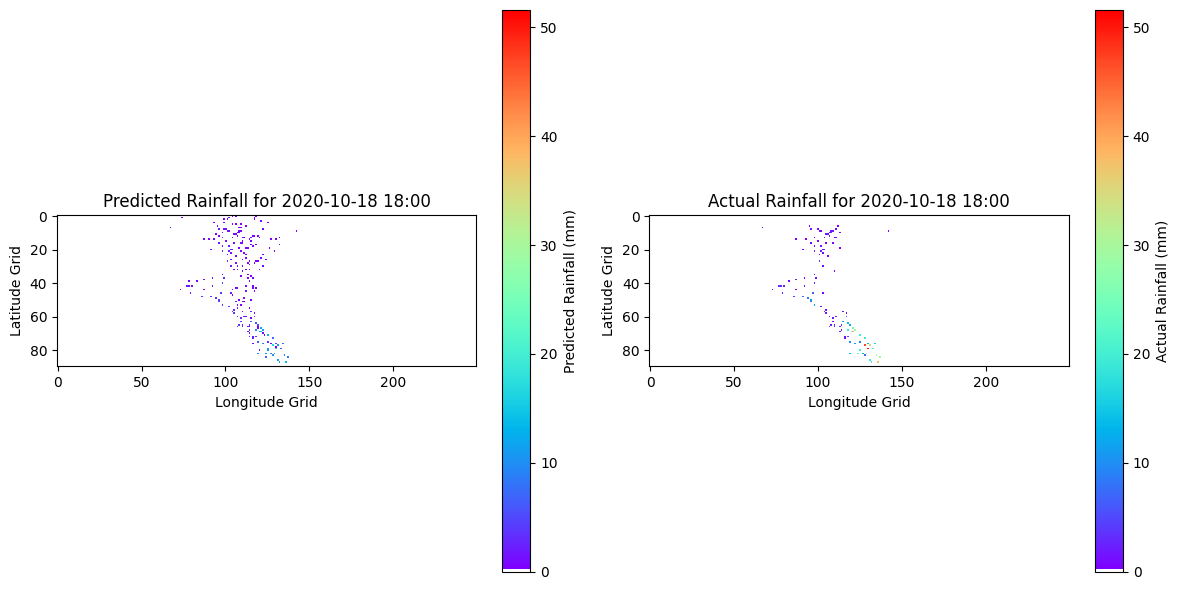

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


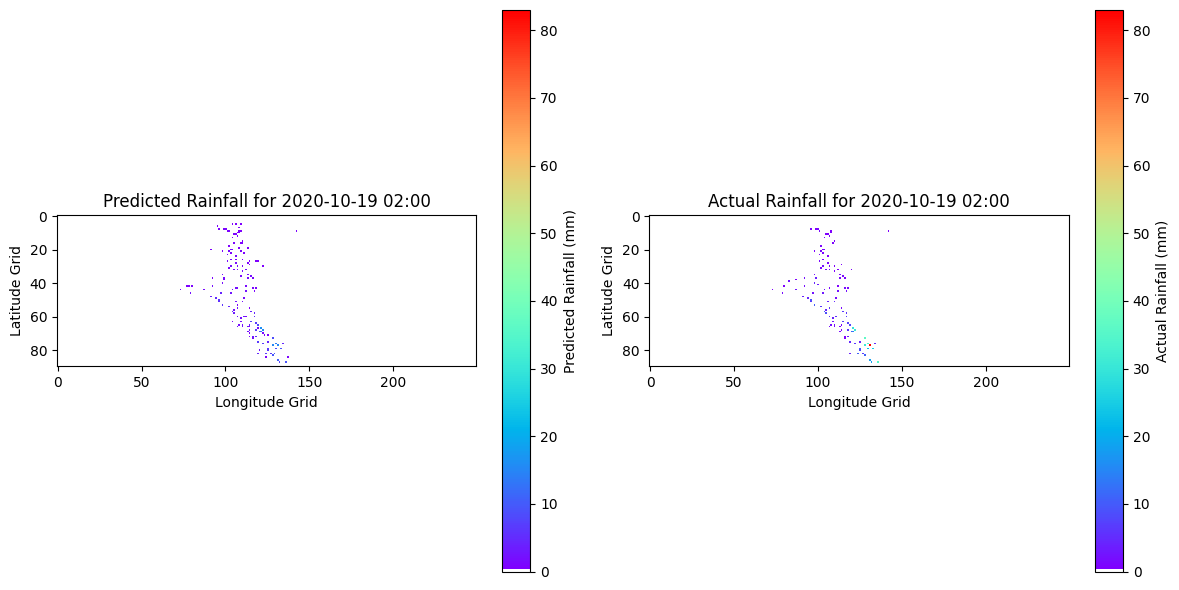

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


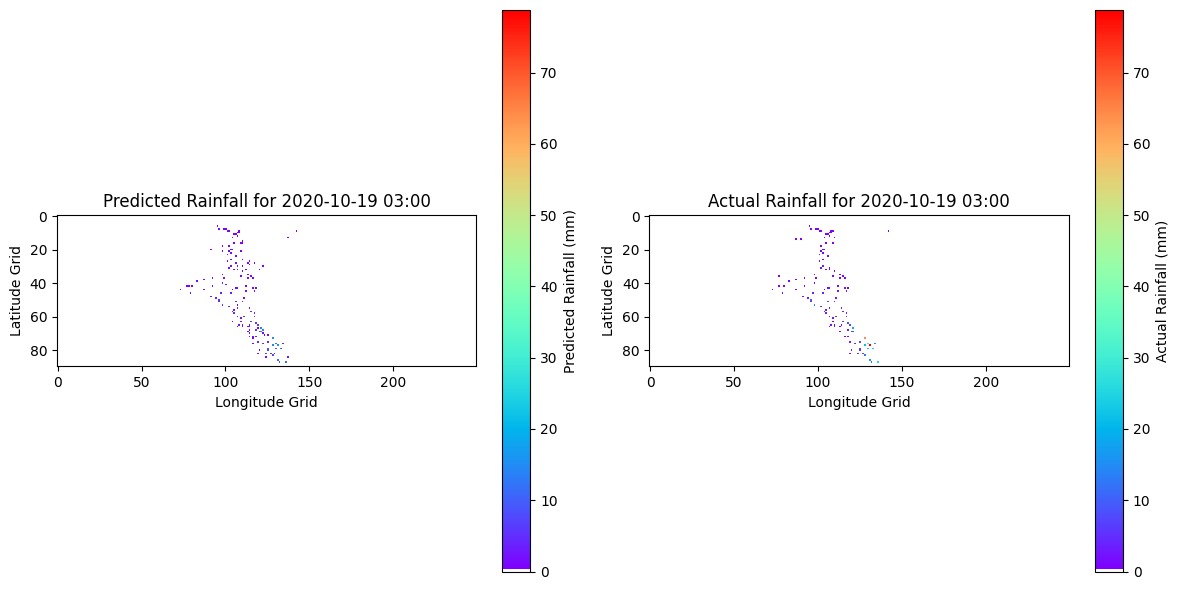

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


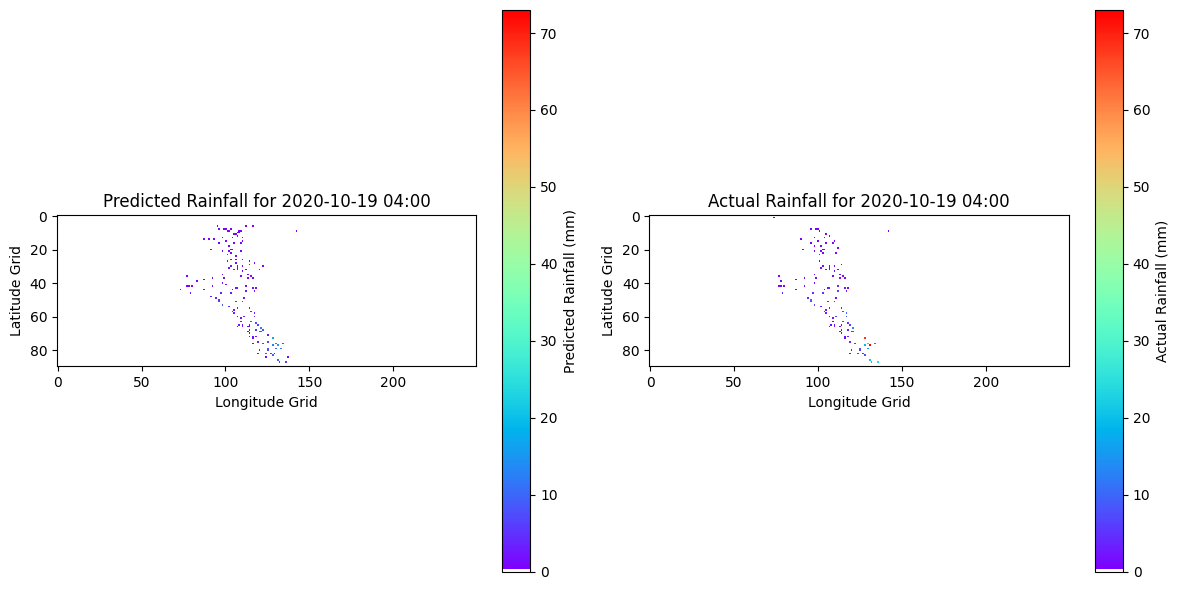

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


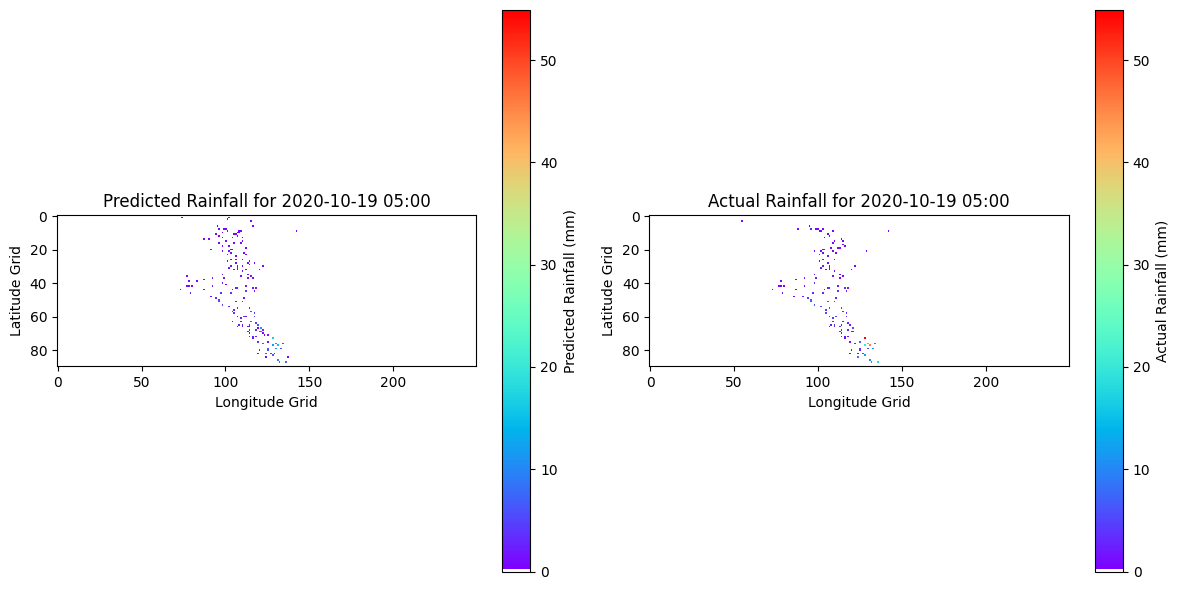

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


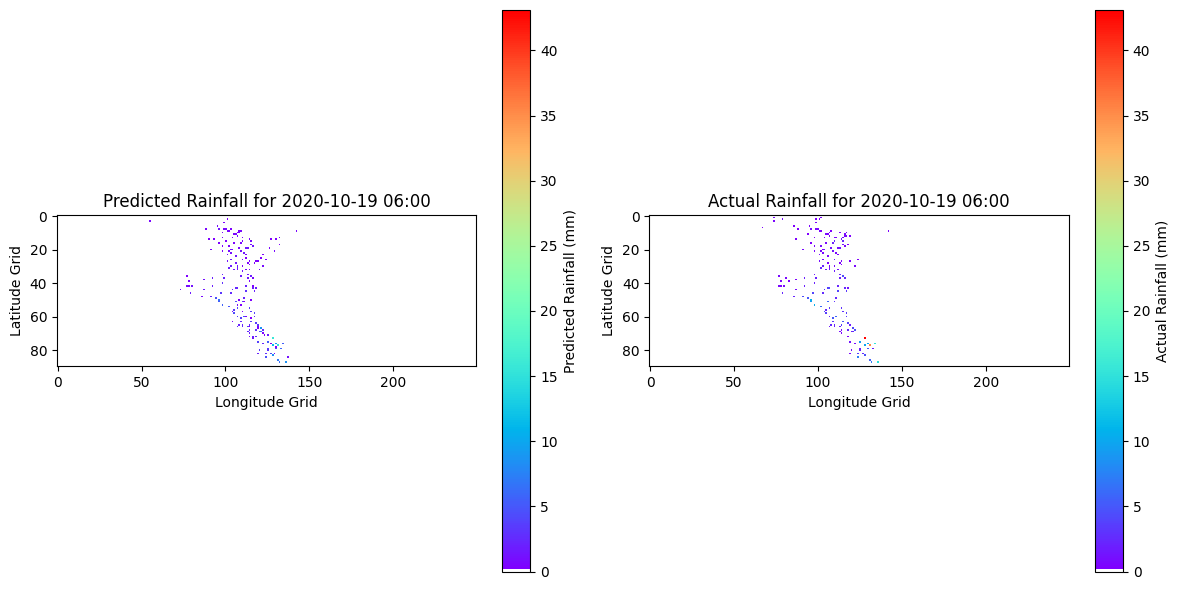

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


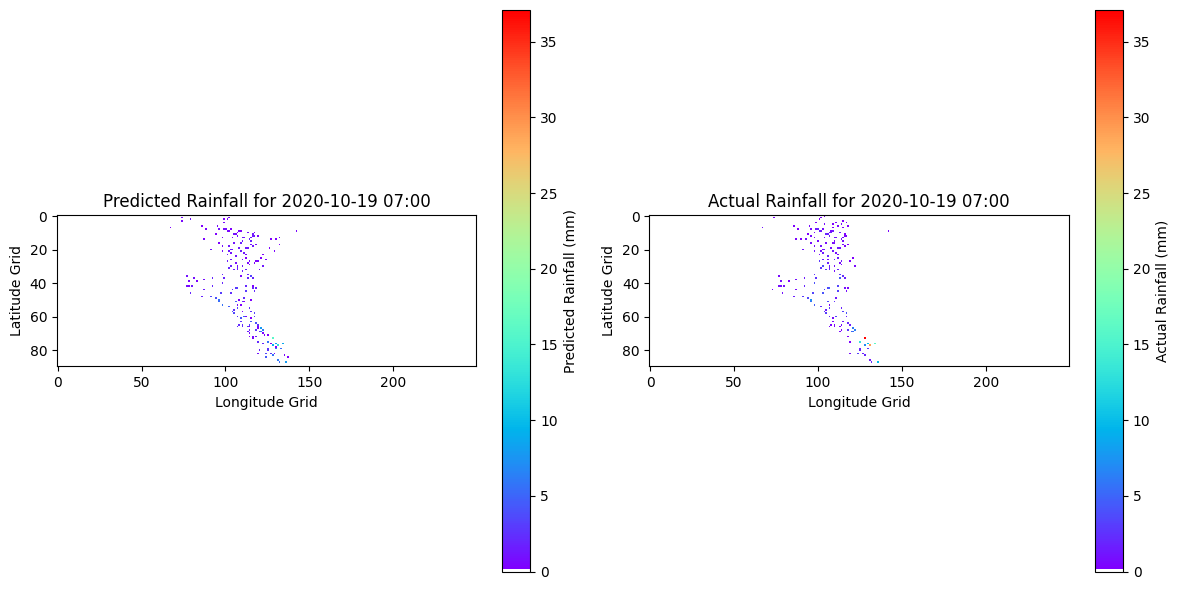

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


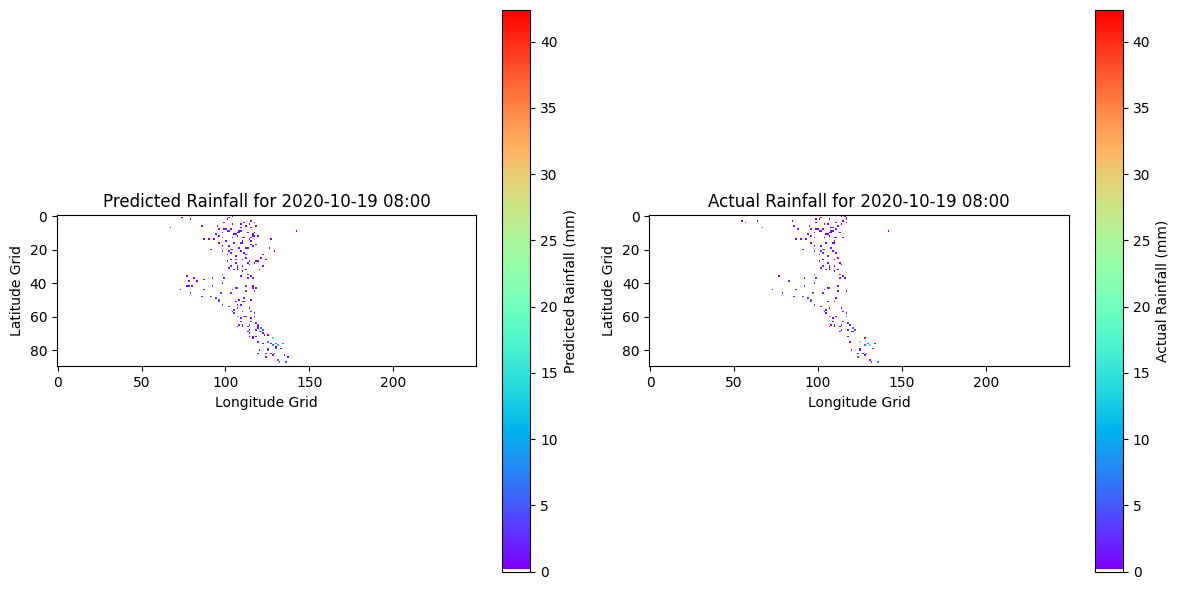

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


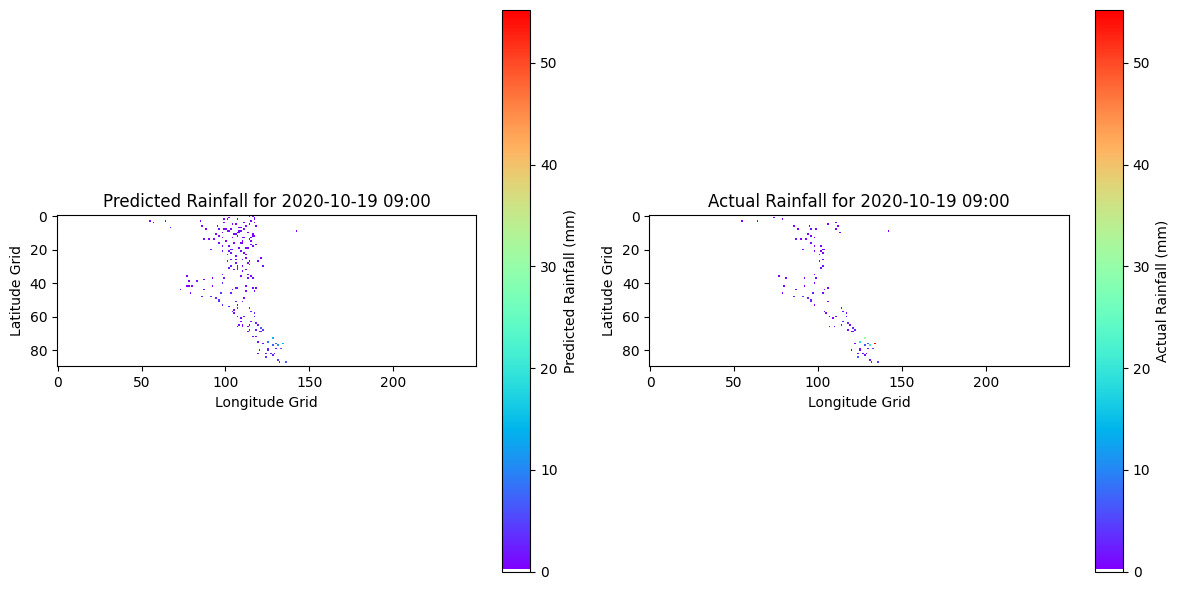

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


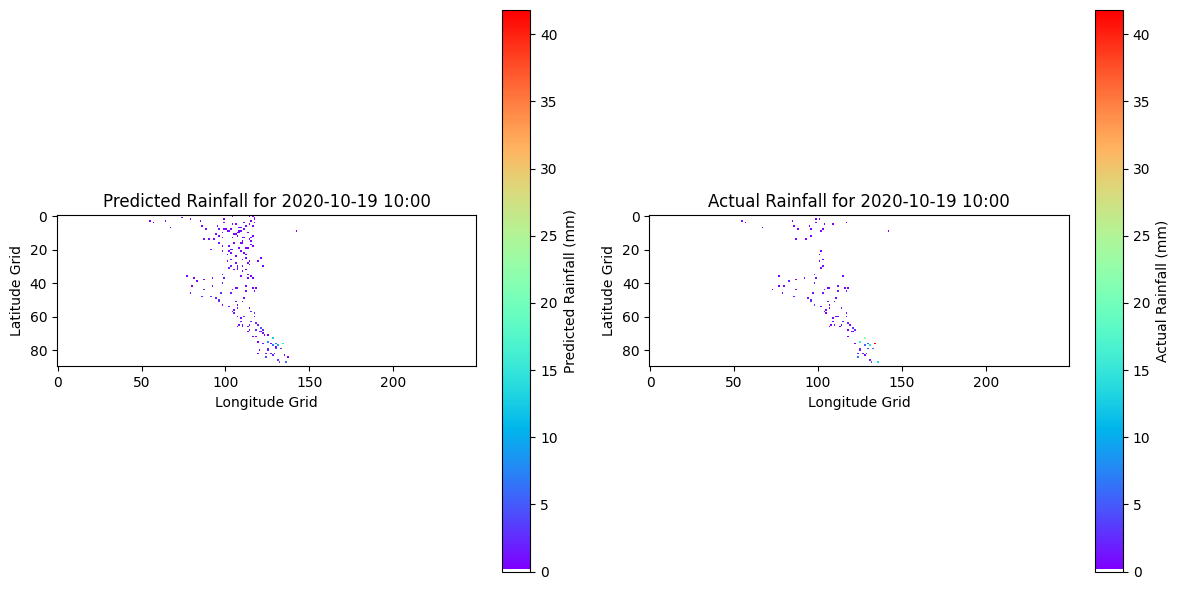

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


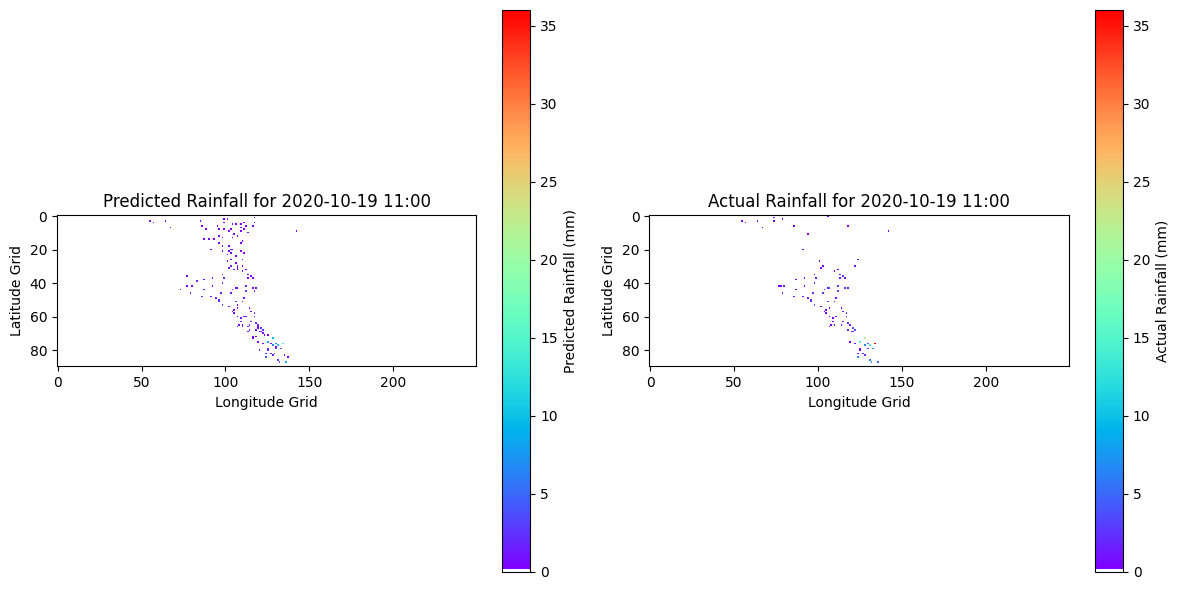

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


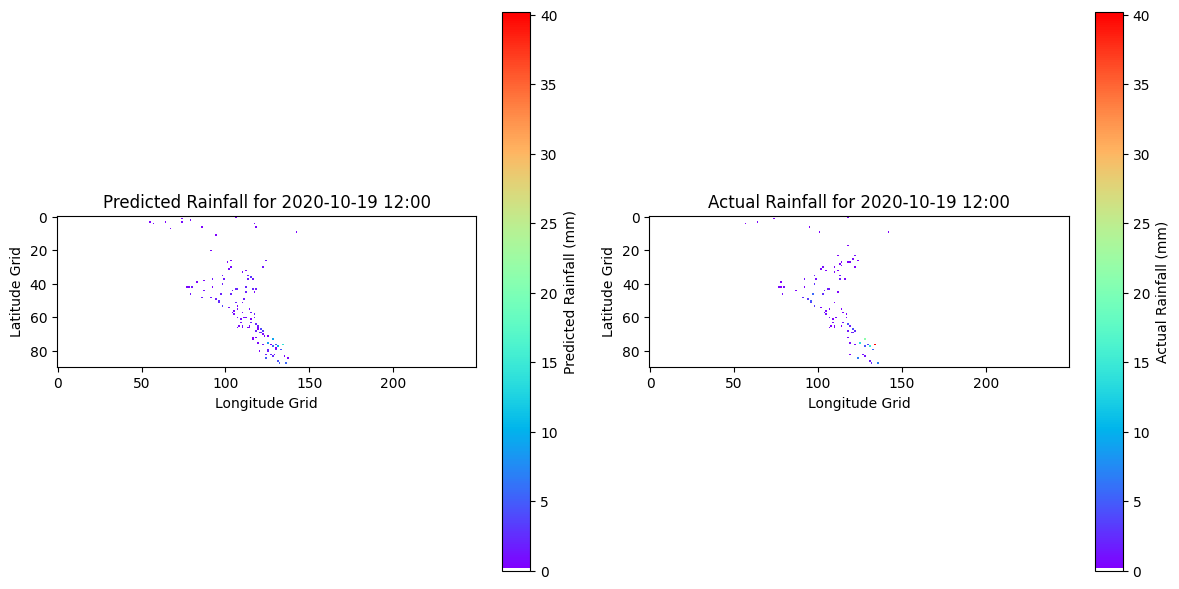

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


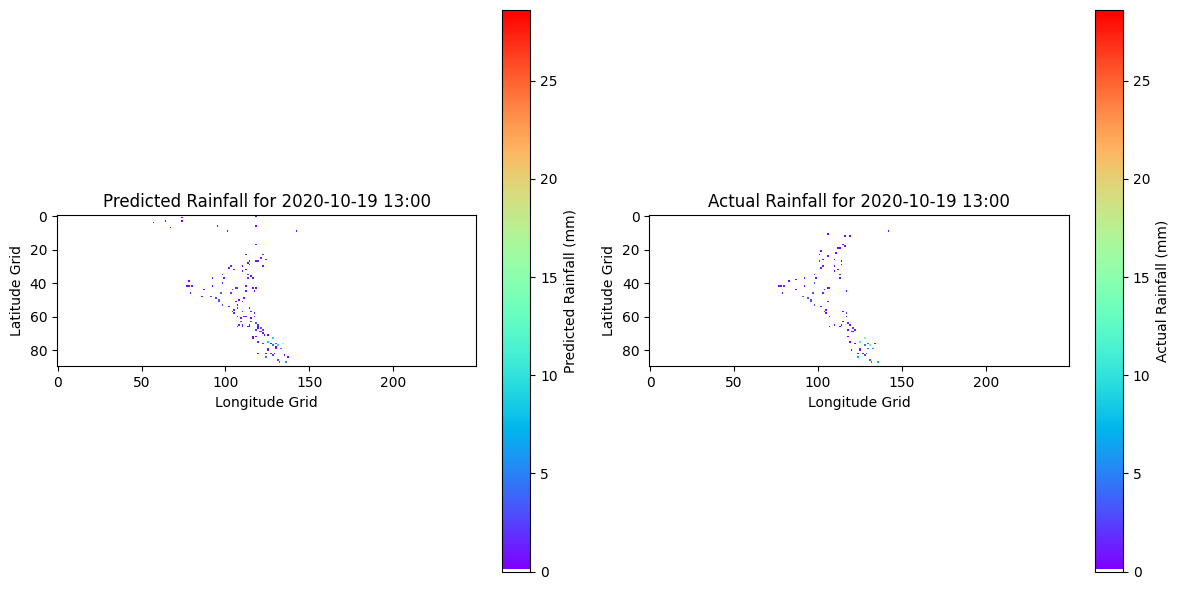

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


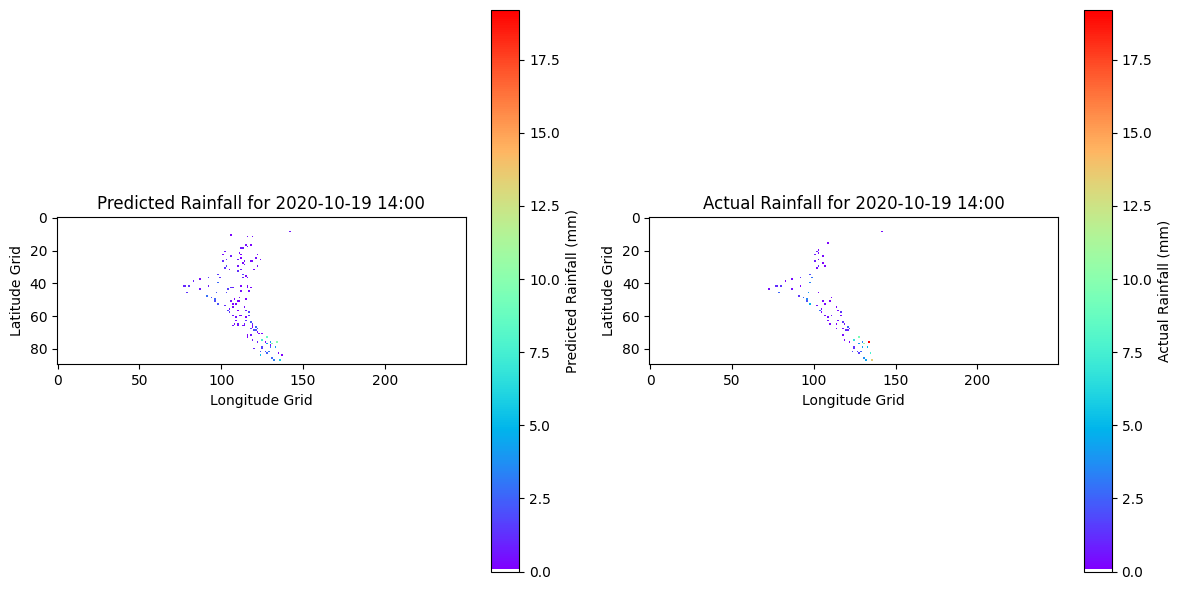

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


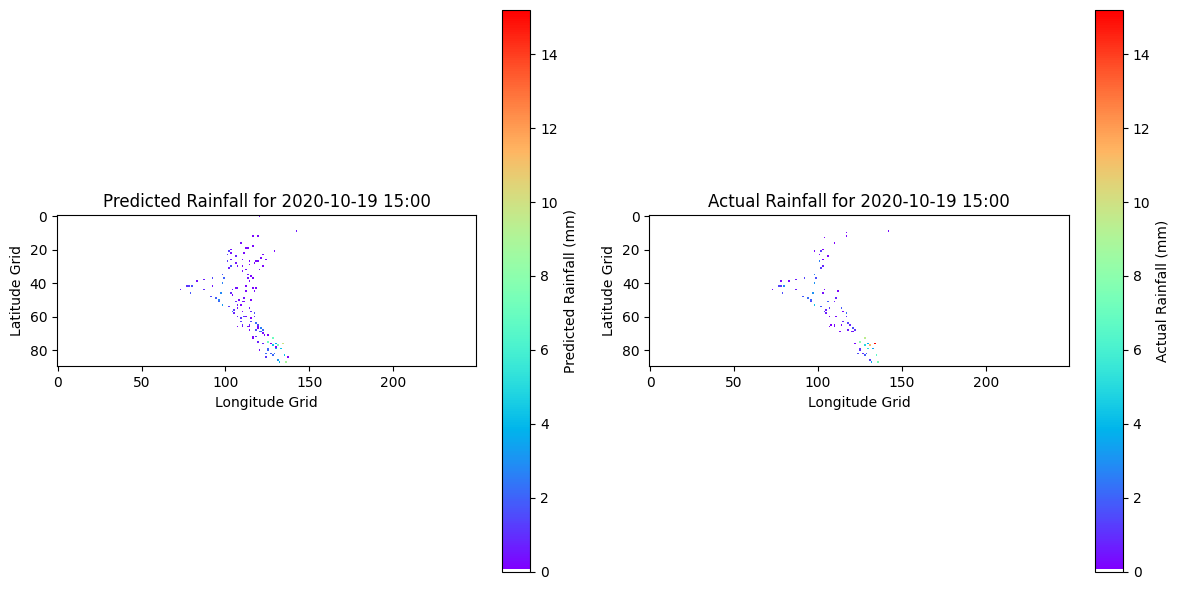

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


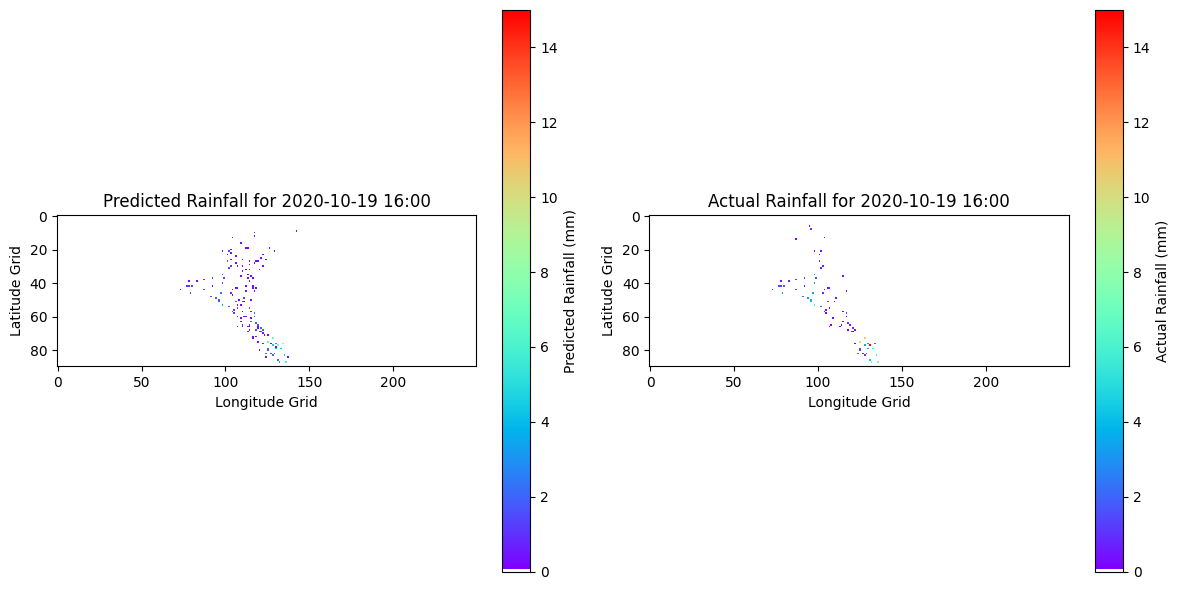

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


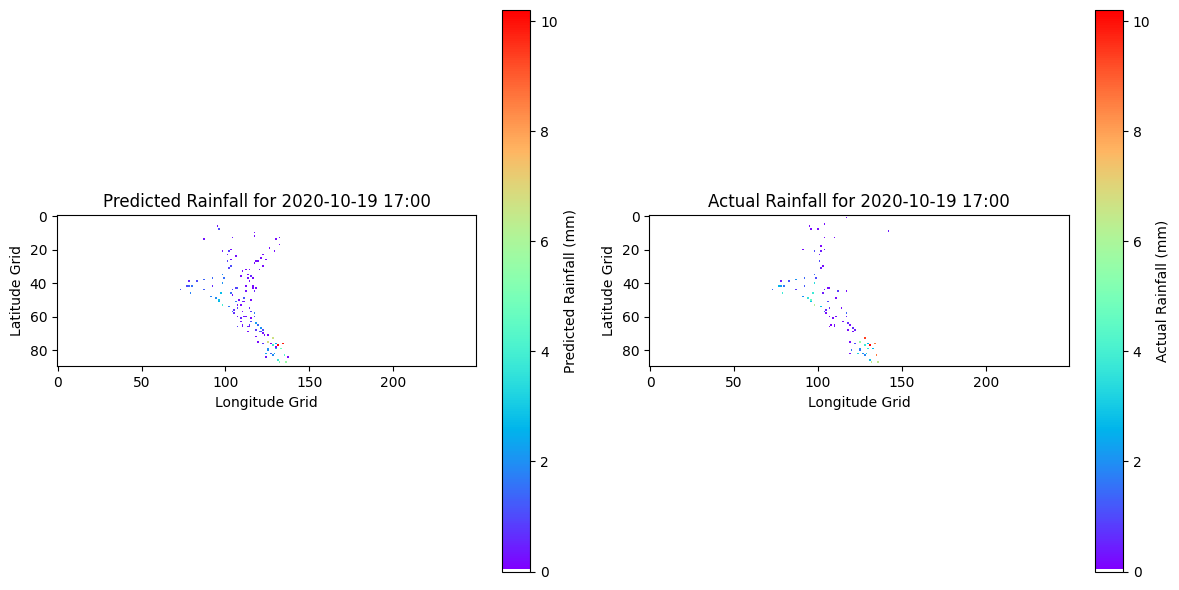

/tmp/ipykernel_19/2645841795.py:57: RuntimeWarning: invalid value encountered in less_equal
  rainfall_grid[rainfall_grid <= 0.01/threshold] = np.nan
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


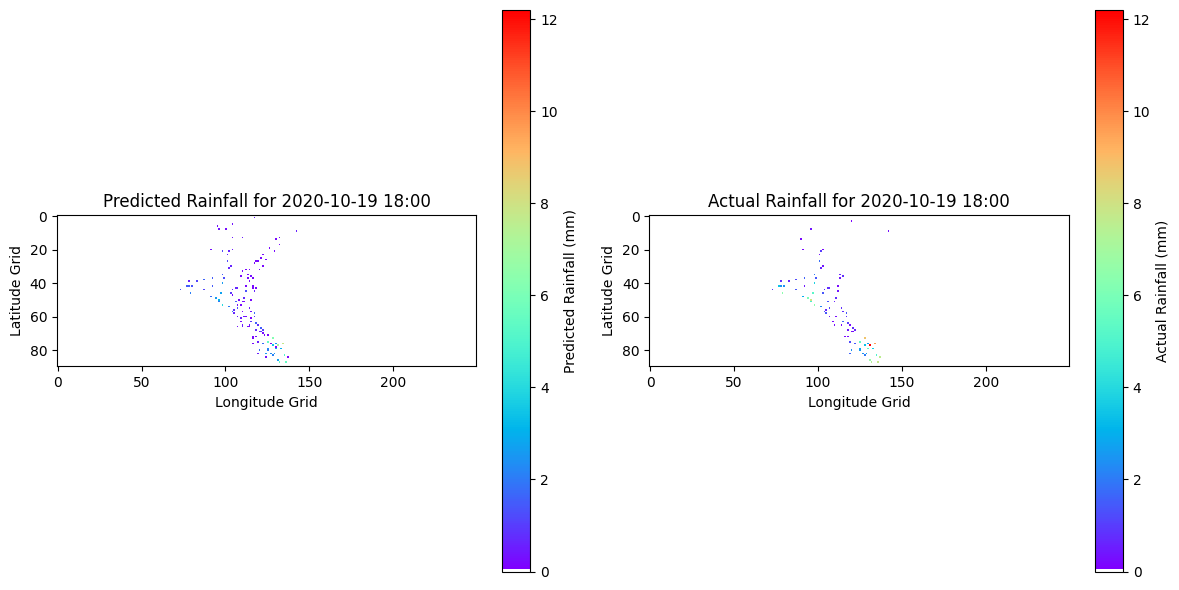

In [22]:
for i in range(11, 20):
    for j in range(2, 19):
        predict_rainfall(2020, 10, i, j, full_data, X_data, y_data, scaler1, scaler2, X_train, X_test, y_train, y_test, model)